In [1307]:
import numpy as np
import pandas as pd
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from pandas import read_csv, DataFrame
from tqdm import tqdm
from subprocess import call
from Bio.SeqIO import parse
from skbio.stats.composition import clr 


In [ ]:
for i in /mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/GUPPI_BARCODE/GUPPI_BARCODE_ITS1_5.8_ITS2/ITS1_5.8_ITS2_trimmed/*fastq; do nextflow run epi2me-labs/wf-metagenomics --fastq $i --threads 60 --out_dir all_res/kraken/$(basename $(basename $i) '.fastq') --database_set PlusPF-8 --classifier kraken2 ;done

In [1308]:
def create_fasta(output, mearged_pike_out, dbpath):
    # Create fasta file 
    consensus = {}
    cons_conter = 0
    
    with open(f'{output}/all_consensus.fasta', 'w') as opn_fasta:
        for cons in mearged_pike_out.index:
    
            opn_fasta.write(f'>{cons_conter}\n{cons}\n')
            consensus[cons_conter] = cons
            cons_conter += 1
    
    return consensus
    
def run_blast(base, path):
    
    call(f'makeblastdb -in {base} -dbtype nucl', shell=True)
    call(f'blastn -num_threads 60  -outfmt "7 qseqid sseqid pident evalue qcovs bitscore" -query {path}/all_consensus.fasta  -db {base} -out {path}/blast_results.txt', shell=True)
 #   pass
def decode_tax(base) -> dict:
    
    # DB decoder 
    # Use db header format: Kingdom    Phylum    Class    Order    Family    Genus    Species
    
    base = parse(base, 'fasta')
    taxonomy_linage = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    tax_decoder = {}
    
    for line in tqdm(base):
        
        tax_decoder[line.id] = {}
        linage = line.description.split(';')
        linage[0] = linage[0].split()[1]
    
        for i in range(len(taxonomy_linage)):
            try:
                if taxonomy_linage[i] != 'Species':
                
                    tax_decoder[line.id][taxonomy_linage[i]] = linage[i]
                
                else:
                    #print(linage[i].split())
                    tax_decoder[line.id][taxonomy_linage[i]] = ' '.join(linage[i].split()[:2])
                  
            except:
                
                tax_decoder[line.id][taxonomy_linage[i]] = 'NA'
    
    return tax_decoder

def parse_blast(path, 
                base, 
                data_tax, 
                consensus, 
                identity_filter, 
                cov_lim, 
                evalue_filter):
    
    # parser of blast table
    
    blast_header = ['qseqid',
                    'sseqid', 
                    'pident',
                    'evalue',
                    'qcovs', 
                    'bitscore']
    
    blasting_results = {}
    opn_blast = read_csv(f'{path}/blast_results.txt', sep='\t', comment='#', header=None, names=blast_header)
    
    for i in tqdm(opn_blast['qseqid'].unique()):
        
        blast_subset = opn_blast[opn_blast["qseqid"] == i]
        blast_subset = blast_subset[blast_subset['pident'] >= identity_filter]
        blast_subset = blast_subset[blast_subset['evalue'] <= evalue_filter]
        blast_subset = blast_subset[blast_subset['qcovs'] >= cov_lim]

        blast_subset = blast_subset.sort_values(by='evalue')
        blast_subset = blast_subset.sort_values(by='pident')[::-1]

        if len(blast_subset['sseqid'].values) == 0:
            continue
            
        subject = blast_subset['sseqid'].values[0]
        blasting_results[consensus[i]] = data_tax[subject]
        
    blasting_results_df = DataFrame(blasting_results).T
    
    return blasting_results_df
    
def processing_data_tax(data_tax):

    data_tax_df = DataFrame(data_tax).T.fillna(0)
    # Add pseudocunt
   # data_tax_df = data_tax_df + 1
    data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(data_tax_df.columns)]

    return  data_tax_df
    
def get_taxonomy(data_tax, 
                 blasting_results_df, 
                 mearged_pike_out, 
                 tax_level='OTU'):
    
    data_tax = {}
    avs = np.intersect1d(blasting_results_df.index, mearged_pike_out.index)
    count = 1
    OTU_decoder  = {'Seq': [], 'OTU_name' : []}
    
    for av in tqdm(avs):

        if tax_level == 'OTU':
        
            tax = f'OTU_{count}_{blasting_results_df["Species"][av]}'
        else:    
            tax = blasting_results_df[tax_level][av]
        count += 1
        OTU_decoder['Seq'].append(av)
        OTU_decoder['OTU_name'].append(tax)
        if tax == 'nan':
            
            tax = 'No Fungi'

        if tax not in data_tax.keys():
    
            data_tax[tax] = {col: 0 for col in mearged_pike_out.columns} 
        
        for col in mearged_pike_out.columns:
           
            data_tax[tax][col] += mearged_pike_out[col][av]
    
    data_tax_df = processing_data_tax(data_tax)
    
    return data_tax_df, OTU_decoder
    

def filter_data(output, 
                dbpath,
                mearged_pike_out,
                taxonomy_level, 
                identity_filter=0, 
                cov_lim=0, 
                evalue_filter=1e-10):

    # Creating output directory
    try:
        
        os.mkdir(output)
        
    except FileExistsError:
        
        print('The output directory already exists!')
        
    consensus = create_fasta(output, mearged_pike_out, dbpath)
    run_blast(dbpath, output)
    data_tax = decode_tax(dbpath)
    blasting_results_df = parse_blast(output, 
                                      dbpath, 
                                      data_tax, 
                                      consensus, 
                                      identity_filter, 
                                      cov_lim, 
                                      evalue_filter)

  #  mearged_pike_out = filter_av(mearged_pike_out, prevalence, detection, slice)
    data_tax_df, OTU_decoder = get_taxonomy(data_tax, 
                                            blasting_results_df, 
                                            mearged_pike_out,
                                            taxonomy_level)

    data_tax_df = data_tax_df[mearged_pike_out.columns]
    for col in data_tax_df.columns:
        
        data_tax_df[col] = data_tax_df[col] / np.sum(data_tax_df[col].values)
    
    data_tax_df = data_tax_df.fillna(0)[mearged_pike_out.columns]   
    data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)


    return data_tax_df, data_tax, blasting_results_df, DataFrame(OTU_decoder)

In [1347]:
nanoclust = {}

all_samples_levels = {}
for taxlevel in ['Genus', 'Species']:
    
    path = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/output/'
    all_samps = {}
    
    for samp in listdir(path):
        if 'work' in samp: continue
        samp = samp.split('.')[0]
        tax_tab = read_csv(f'{path}/{samp}.fastq/{samp}/rel_abundance_{samp}_{taxlevel[0]}.csv', index_col=0)
        
        all_samps[samp] = tax_tab['rel_abundance'].to_dict()
    
    all_samps = DataFrame(all_samps).fillna(0)
    all_samps = all_samps.assign(m=all_samps.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(all_samps.columns)]
    all_samples_levels[taxlevel] = all_samps
path = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/output/'
all_samps = {}

for samp in listdir(path):
    if 'work' in samp: continue
    
    samp = samp.split('.')[0]
    all_samps[samp] = {}
    opn_nanoclust_tab = read_csv(f'{path}/{samp}.fastq/{samp}/{samp}.nanoclust_out.txt', sep=';', index_col=0)
     
    for i in listdir(f'{path}/{samp}.fastq/{samp}'):
        if 'cluster' not in i: continue
        
        cluster_id = int(i[7:])
        opn_fasta = parse(f'{path}/{samp}.fastq/{samp}/{i}/consensus_medaka.fasta/consensus.fasta', 'fasta')

        for line in opn_fasta:
            
            seq = str(line.seq)
            
            if seq not in all_samps[samp].keys():
                
                all_samps[samp][seq] = int(opn_nanoclust_tab.reads_in_cluster[cluster_id])
            
all_samps = DataFrame(all_samps).fillna(0)
all_samps = all_samps/ all_samps.sum()
all_samples_levels['OTU'] = all_samps
otu_tab = read_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_res.tsv', sep='\t', index_col=0)
tax_tab = read_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_taxtab.tsv/tax_table.tsv', sep='\t', index_col=0)
ll_samples_levels_fung = {}

for taxlevel  in ['Genus', 'Species']:
    
    all_samps = {}
    
    for i in otu_tab.columns:
        try:
            if tax_tab[taxlevel][i] not in all_samps.keys():
                
                all_samps[tax_tab[taxlevel][i]] = {samp : 0 for samp in otu_tab.index}
            
            for samp in otu_tab.index:
                
                all_samps[tax_tab[taxlevel][i]][samp] += otu_tab[i][samp]
        except:
            #print(i)
            continue
    
    all_samps = DataFrame(all_samps)
    all_samps = (all_samps.T / all_samps.sum(axis=1)).T
    all_samps = all_samps.loc[np.sort(all_samps.index)].T
    all_samples_levels_fung[taxlevel] = all_samps
all_samples_levels_fung['OTU'] = (otu_tab.T / otu_tab.sum(axis=1))

nanoclust['16S'] = all_samples_levels
nanoclust['ITS'] = all_samples_levels_fung

In [1354]:
tax_tab.value_counts('Species')

Species
s__Kluyveromyces_marxianus      20
s__Issatchenkia_orientalis       6
s__Rhodotorula_mucilaginosa      5
s__Candida_albicans              4
s__Candida_parapsilosis          3
s__Meyerozyma_guilliermondii     3
s__Rhodotorula_sp                2
s__Candida_tropicalis            1
s__Kluyveromyces_lactis          1
s__Kluyveromyces_sp              1
Name: count, dtype: int64

In [1310]:
wf_meta_kraken = {'16S' : {
                           'Genus' : {},
                           'Species' : {}
                          }, 
                  'ITS' : {
                           'Genus' : {},
                           'Species' : {}
                          }
                 }
wf_meta_minimap = {'16S' : {
                           'Genus' : {},
                           'Species' : {}
                           }, 
                   'ITS' : {
                           'Genus' : {},
                           'Species' : {}
                           }
                  }

for samp in listdir('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/all_res/minimap/'):
    
    opn_res = read_csv(f'/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/all_res/minimap/{samp}/abundance_table_species.tsv', sep='\t', index_col=0)
    if 'V' in samp:
        
        wf_meta_minimap['16S']['Genus'][samp] = {}
        wf_meta_minimap['16S']['Species'][samp] = {}
        for i in opn_res.index:
            if 'Bacteria' not in i:continue
            tax = i.split(';')[-2]
            
            if tax not in wf_meta_minimap['16S']['Genus'][samp]:
                
                wf_meta_minimap['16S']['Genus'][samp][tax] = 0
            
            wf_meta_minimap['16S']['Genus'][samp][tax] += opn_res['total'][i]

        
        for i in opn_res.index:
            if 'Bacteria' not in i:continue
            tax = ' '.join(i.split(';')[-1].split()[:2])
            
            if tax not in wf_meta_minimap['16S']['Species'][samp]:
                
                wf_meta_minimap['16S']['Species'][samp][tax] = 0
            
            wf_meta_minimap['16S']['Species'][samp][tax] += opn_res['total'][i]
            
    else:
        wf_meta_minimap['ITS']['Genus'][samp] = {}
        wf_meta_minimap['ITS']['Species'][samp] = {}
        for i in opn_res.index:
            if 'Fungi' not in i:continue
            tax = i.split(';')[-2]
            
            if tax not in wf_meta_minimap['ITS']['Genus'][samp]:
                
                wf_meta_minimap['ITS']['Genus'][samp][tax] = 0
            
            wf_meta_minimap['ITS']['Genus'][samp][tax] += opn_res['total'][i]

        
        for i in opn_res.index:
            if 'Fungi' not in i:continue
            tax = ' '.join(i.split(';')[-1].split()[:2])
            
            if tax not in wf_meta_minimap['ITS']['Species'][samp]:
                
                wf_meta_minimap['ITS']['Species'][samp][tax] = 0
            
            wf_meta_minimap['ITS']['Species'][samp][tax] += opn_res['total'][i]
for samp in listdir('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/all_res/kraken/'):
    
    opn_res = read_csv(f'/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/all_res/kraken/{samp}/abundance_table_species.tsv', sep='\t', index_col=0)
    
    if 'V' in samp:

        
        wf_meta_kraken['16S']['Genus'][samp] = {}
        wf_meta_kraken['16S']['Species'][samp] = {}
        for i in opn_res.index:
            if 'Bacteria' not in i:continue
            tax = i.split(';')[-2]
            
            if tax not in wf_meta_kraken['16S']['Genus'][samp]:
                
                wf_meta_kraken['16S']['Genus'][samp][tax] = 0
            
            wf_meta_kraken['16S']['Genus'][samp][tax] += opn_res['total'][i]
        
        for i in opn_res.index:
            if 'Bacteria' not in i:continue
            tax = ' '.join(i.split(';')[-1].split()[:2])
            
            if tax not in wf_meta_kraken['16S']['Species'][samp]:
                
                wf_meta_kraken['16S']['Species'][samp][tax] = 0
            
            wf_meta_kraken['16S']['Species'][samp][tax] += opn_res['total'][i]

    else:        
        wf_meta_kraken['ITS']['Genus'][samp] = {}
        wf_meta_kraken['ITS']['Species'][samp] = {}
        for i in opn_res.index:
            if 'Fungi' not in i:continue
            tax = i.split(';')[-2]
            
            if tax not in wf_meta_kraken['ITS']['Genus'][samp]:
                
                wf_meta_kraken['ITS']['Genus'][samp][tax] = 0
            
            wf_meta_kraken['ITS']['Genus'][samp][tax] += opn_res['total'][i]

        
        for i in opn_res.index:
            if 'Fungi' not in i:continue
            tax = ' '.join(i.split(';')[-1].split()[:2])
            
            if tax not in wf_meta_kraken['ITS']['Species'][samp]:
                
                wf_meta_kraken['ITS']['Species'][samp][tax] = 0
            
            wf_meta_kraken['ITS']['Species'][samp][tax] += opn_res['total'][i]


In [1311]:
paths = ['/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/16S/V3_V4/pool_V3_V4_k6_150000_reads/',
         '/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/16S/V1_V9/pool_V1_V9_k6_100000_reads/',
         '/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS1/pool_ITS1_k6_150000_reads/',
         '/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS2/pool_ITS2_k6_100000_reads/',
         '/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/ITS/ITS_full/pool_ITS_full_k6_100000_reads/',
        ]
def get_otu_tab(taxtab, otutab):
    
    tax_info = {}
    otucount = 0
    
    for idx in taxtab.index:
        
        tax = ' '.join(taxtab['Species'][idx].split()[:2])
        
        if tax not in tax_info.keys():
            
            tax_info[f'OTU{otucount}_{tax}'] = {}
            
        for samp in otutab.index:
            
            tax_info[f'OTU{otucount}_{tax}'][samp] = otutab[idx][samp]
            
        otucount += 1
    tax_info = DataFrame(tax_info)    
    tax_info = tax_info.T/tax_info.sum(axis=1)
    tax_info = tax_info.assign(m=tax_info.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(tax_info.columns)]

    return tax_info
def get_tab(taxtab, otutab, level):
    tax_info = {}
    otucount = 0
    
    for idx in taxtab.index:
        
        tax = taxtab[level][idx] 
        if level == 'Species':
            tax= ' '.join(taxtab['Species'][idx].split()[:2])
            
        if tax not in tax_info.keys():
            
            tax_info[tax] = {}
            
        for samp in otutab.index:
            if samp not in tax_info[tax]:
                
                tax_info[tax][samp] = 0
                
            tax_info[tax][samp] += otutab[idx][samp]
            
        otucount += 1
    tax_info = DataFrame(tax_info)    
    tax_info = tax_info.T/tax_info.sum(axis=1)
    tax_info = tax_info.assign(m=tax_info.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(tax_info.columns)]
    return tax_info
    
full_data_pool = {}

for path in tqdm(paths):

    samp =  path.split('/')[-3]
    taxtab = read_csv(f'{path}/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)
    otutab = read_csv(f'{path}/merged_otu_table.tsv', sep='\t', index_col=0)

    full_data_pool[samp] = {'Genus' : get_tab(taxtab, otutab, 'Genus'),
                            'Species' : get_tab(taxtab, otutab, 'Species'),
                            'OTU' : get_otu_tab(taxtab, otutab)
                           }
    
    

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


In [1312]:
amplicon_type = 'V3_V4_final_version' #guppi_barcode
#amplicon_type = 'V1_V9_final_version' #guppi_barcode
#CHECK K=6 and all 
all_mearged = {}

mearged_otu_table = []
#for amplicon_type in ['ITS1_5.8_ITS2_TEST_OTU_TABLE_20000_k6']:
for amplicon_type in ['V3_V4_final_version', 'V1_V9_final_version']:
    for samp in listdir(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27//{amplicon_type}/results/'):
        
        opn_res = read_csv(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/{amplicon_type}/results/{samp}/results.tsv', sep='\t', index_col=0)
        count = 0
        mearged_otu_table.append(DataFrame(data=opn_res.values, index=opn_res.index, columns=[samp]))
        
        with open(f'//mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/{amplicon_type}/{samp}.fasta', 'w') as opn_fasta:
    
            for line in opn_res.index:
                
                opn_fasta.write(f'>{count}_{opn_res["Count"][line]}\n{line}\n')
                count += 1
mearged_otu_table = pd.concat(mearged_otu_table, axis=1).fillna(0)
mearged_otu_table = mearged_otu_table[np.sort(mearged_otu_table.columns)]
all_mearged['16S'] = mearged_otu_table

#__________________________________________________________________________________________________________________________
mearged_otu_table = []

for amplicon_type in ['ITS1_true', 'ITS2_true', 'ITS1_5.8_ITS2_final_version']:
    for samp in listdir(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/{amplicon_type}/results/'):
        
        opn_res = read_csv(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/{amplicon_type}/results/{samp}/results.tsv', sep='\t', index_col=0)
        count = 0
        mearged_otu_table.append(DataFrame(data=opn_res.values, index=opn_res.index, columns=[samp]))
        
        with open(f'//mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/{amplicon_type}/{samp}.fasta', 'w') as opn_fasta:
    
            for line in opn_res.index:
                
                
                opn_fasta.write(f'>{count}_{opn_res["Count"][line]}\n{line}\n')
                count += 1
mearged_otu_table = pd.concat(mearged_otu_table, axis=1).fillna(0)
mearged_otu_table = mearged_otu_table[np.sort(mearged_otu_table.columns)]
all_mearged['ITS'] = mearged_otu_table
#mearged_otu_table.T.to_csv(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/{amplicon_type}/merged_otu_table.tsv',sep='\t')

In [1313]:
output = f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/pike_2023_03_27/16S_TAXONOMY'
dbpath = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta'
#dbpath = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta'

taxonomy_level = 'Genus'
taxonomy_level = 'Species'
taxonomy_level = 'OTU'
full_data = {}

for amplic in all_mearged.keys():

    full_data[amplic] = {}
    
    if 'V' in amplic:
        dbpath = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta'
        
    if 'ITS' in amplic:
        dbpath = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta'
        
    for taxonomy_level in ['Genus', 'Species', 'OTU']:
        
        data_tax_df, data_tax, blasting_results_df, OTU_decoder = filter_data(output, 
                                                                             dbpath,
                                                                             all_mearged[amplic],
                                                                             taxonomy_level, 
                                                                             identity_filter=0, 
                                                                             cov_lim=0, 
                                                                             evalue_filter=1e-10)
        full_data[amplic][taxonomy_level] = [data_tax_df, data_tax, blasting_results_df, OTU_decoder]
        

The output directory already exists!


Building a new DB, current time: 08/21/2024 06:35:25
New DB name:   /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
New DB title:  /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 510508 sequences in 10.6807 seconds.




510508it [00:06, 78353.58it/s]
100%|████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 17588.71it/s]


The output directory already exists!


Building a new DB, current time: 08/21/2024 06:36:44
New DB name:   /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
New DB title:  /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 510508 sequences in 11.0252 seconds.




510508it [00:06, 78791.78it/s]
100%|████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 18262.77it/s]


The output directory already exists!


Building a new DB, current time: 08/21/2024 06:38:03
New DB name:   /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
New DB title:  /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/METAGENOME/SILVA_138.1_SSURef_NR99_tax_silva.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 510508 sequences in 10.5766 seconds.




510508it [00:06, 77048.84it/s]
100%|████████████████████████████████████████████████████████████████████████████| 131/131 [00:00<00:00, 17097.23it/s]


The output directory already exists!


Building a new DB, current time: 08/21/2024 06:39:20
New DB name:   /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
New DB title:  /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1039010 sequences in 15.9753 seconds.




1039010it [00:08, 128696.13it/s]
100%|████████████████████████████████████████████████████████████████████████████| 882/882 [00:00<00:00, 13329.36it/s]


The output directory already exists!


Building a new DB, current time: 08/21/2024 06:52:32
New DB name:   /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
New DB title:  /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1039010 sequences in 16.2986 seconds.




1039010it [00:08, 127336.21it/s]
100%|████████████████████████████████████████████████████████████████████████████| 882/882 [00:00<00:00, 13911.82it/s]


The output directory already exists!


Building a new DB, current time: 08/21/2024 07:05:29
New DB name:   /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
New DB title:  /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/ITS_AMPLICON/dada_unite.fasta
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 1039010 sequences in 15.8645 seconds.




1039010it [00:07, 131714.57it/s]
100%|████████████████████████████████████████████████████████████████████████████| 882/882 [00:00<00:00, 12994.08it/s]


In [1314]:
df_minimap = DataFrame(wf_meta_minimap['16S']['Species']).fillna(0) 
df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
df_minimap = df_minimap/df_minimap.sum(axis=0)
#df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
df_minimap['V3_V4_1']

Acinetobacter radioresistens    0.101699
Bifidobacterium animalis        0.137021
Streptococcus thermophilus      0.107025
Mycoplasmoides gallisepticum    0.079228
Lactococcus lactis              0.078694
                                  ...   
Heyndrickxia oleronia           0.000000
Anoxybacillus kaynarcensis      0.000000
Ligilactobacillus apodemi       0.000000
Sinomonas notoginsengisoli      0.000000
Rhodoglobus vestalii            0.000000
Name: V3_V4_1, Length: 1890, dtype: float64

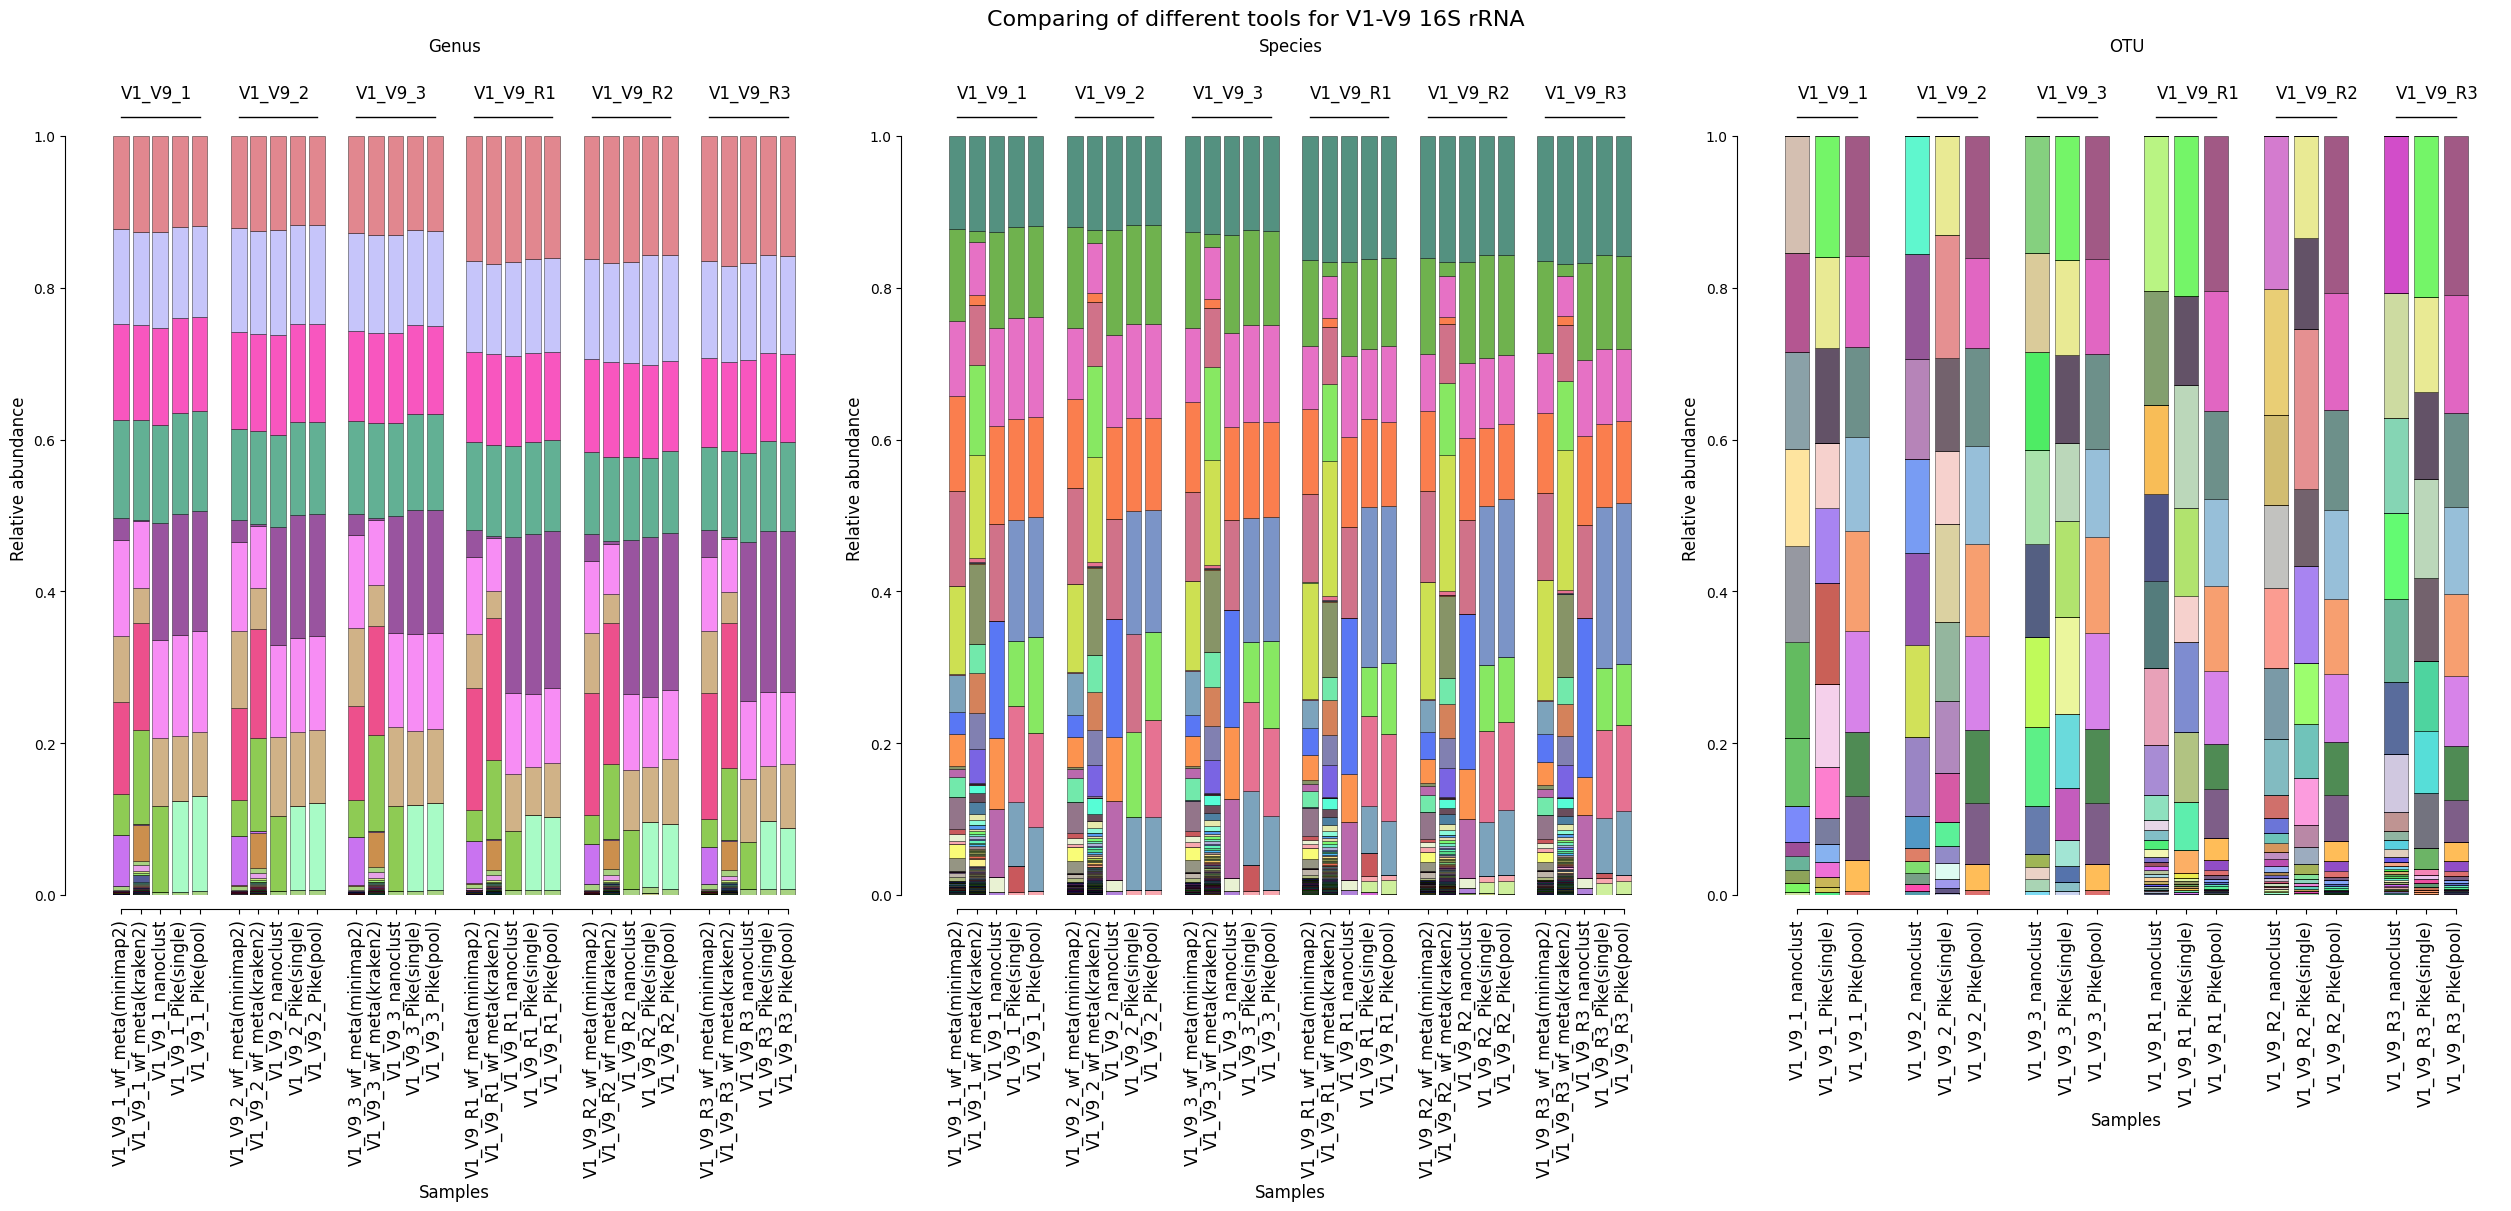

In [1339]:
amplicon = 'V1_V9'
composition = '16S'
dif_taxlev_data = {}

for taxlevel in ['Genus', 'Species', 'OTU']:
    if taxlevel != 'OTU':
        
        df_minimap = DataFrame(wf_meta_minimap[composition][taxlevel]).fillna(0) 
        df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
        df_minimap = df_minimap/df_minimap.sum(axis=0)
        df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
        
        df_kaken = DataFrame(wf_meta_kraken[composition][taxlevel]).fillna(0) 
        df_kaken = df_kaken.loc[df_kaken.index[df_kaken.index.str.contains('Unknown')!=1]]
        df_kaken = df_kaken/df_kaken.sum(axis=0)
        df_kaken = df_kaken[df_kaken.columns[df_kaken.columns.str.contains(amplicon)]]
    
    nanoclust_res = nanoclust[composition][taxlevel]
    
    pike_single = full_data[composition][taxlevel][0]
    pike_single = pike_single[pike_single.columns[pike_single.columns.str.contains(amplicon)]]
    pike_pool = full_data_pool[amplicon][taxlevel]
    
    df_to_viz = {}
    for samp in pike_single.columns:
        if taxlevel != 'OTU':
            df_to_viz[f'{samp}_wf_meta(minimap2)'] = df_minimap[samp]
            df_to_viz[f'{samp}_wf_meta(kraken2)'] = df_kaken[samp]
            
        df_to_viz[f'{samp}_nanoclust'] = nanoclust_res[samp]
        
        df_to_viz[f'{samp}_Pike(single)'] = pike_single[samp]
        df_to_viz[f'{samp}_Pike(pool)'] = pike_pool[samp]
        
    
    df_to_viz = DataFrame(df_to_viz).fillna(0)
    df_to_viz = df_to_viz.assign(m=df_to_viz.mean(axis=1)).sort_values('m').drop('m', axis=1)#[np.sort(df_to_viz.columns)]
    dif_taxlev_data[taxlevel] = df_to_viz
    
fig, axs = plt.subplots(1, 3, figsize=(25, 12), constrained_layout=True)
x_coord = 0
for taxlevel in ['Genus', 'Species', 'OTU']:

    data_tax_df = dif_taxlev_data[taxlevel]
    
    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 1
    c = []
    fst = True
    st = 1
    s_name = ''
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        if taxlevel == 'OTU':
            if sample_coord%4 == 0 : 
                
                axs[x_coord].text(st, 1.05, s_name, fontsize=12)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
        else:
            if sample_coord%6 == 0 : 

                
                axs[x_coord].text(st, 1.05, s_name, fontsize=12)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
            
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
    
            axs[x_coord].bar(sample_coord, 
                          data_tax_df[sample][otu], 
                          width, 
                          bottom=bottom,
                          edgecolor='black',
                          alpha=.7,
                          linewidth=0.4, 
                          color=Color_collection[otu])
            
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
        s_name = '_'.join(sample.split('_')[:3])
        
    if taxlevel == 'OTU':
        if sample_coord%4 == 0 : 

            axs[x_coord].text(st, 1.05, s_name, fontsize=12)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
            
    else:
        if sample_coord%6 == 0 : 

            
            axs[x_coord].text(st, 1.05, s_name, fontsize=12)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
    axs[x_coord].set_ylim(0, 1.1)
    #if taxlevel != 'OTU':
    #    axs[x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=12)
    axs[x_coord].set_ylabel('Relative abundance', fontsize=12)
    axs[x_coord].set_xlabel('Samples', fontsize=12)
    axs[x_coord].set_title(taxlevel, fontsize=12)
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[x_coord])
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=12)
    x_coord += 1
    
fig.suptitle('Comparing of different tools for V1-V9 16S rRNA', fontsize=16)
plt.savefig('VIZ/COMAPRE_ALL_V1_V9.pdf', bbox_inches='tight')
plt.savefig('VIZ/COMAPRE_ALL_V1_V9.png', bbox_inches='tight')
plt.show()

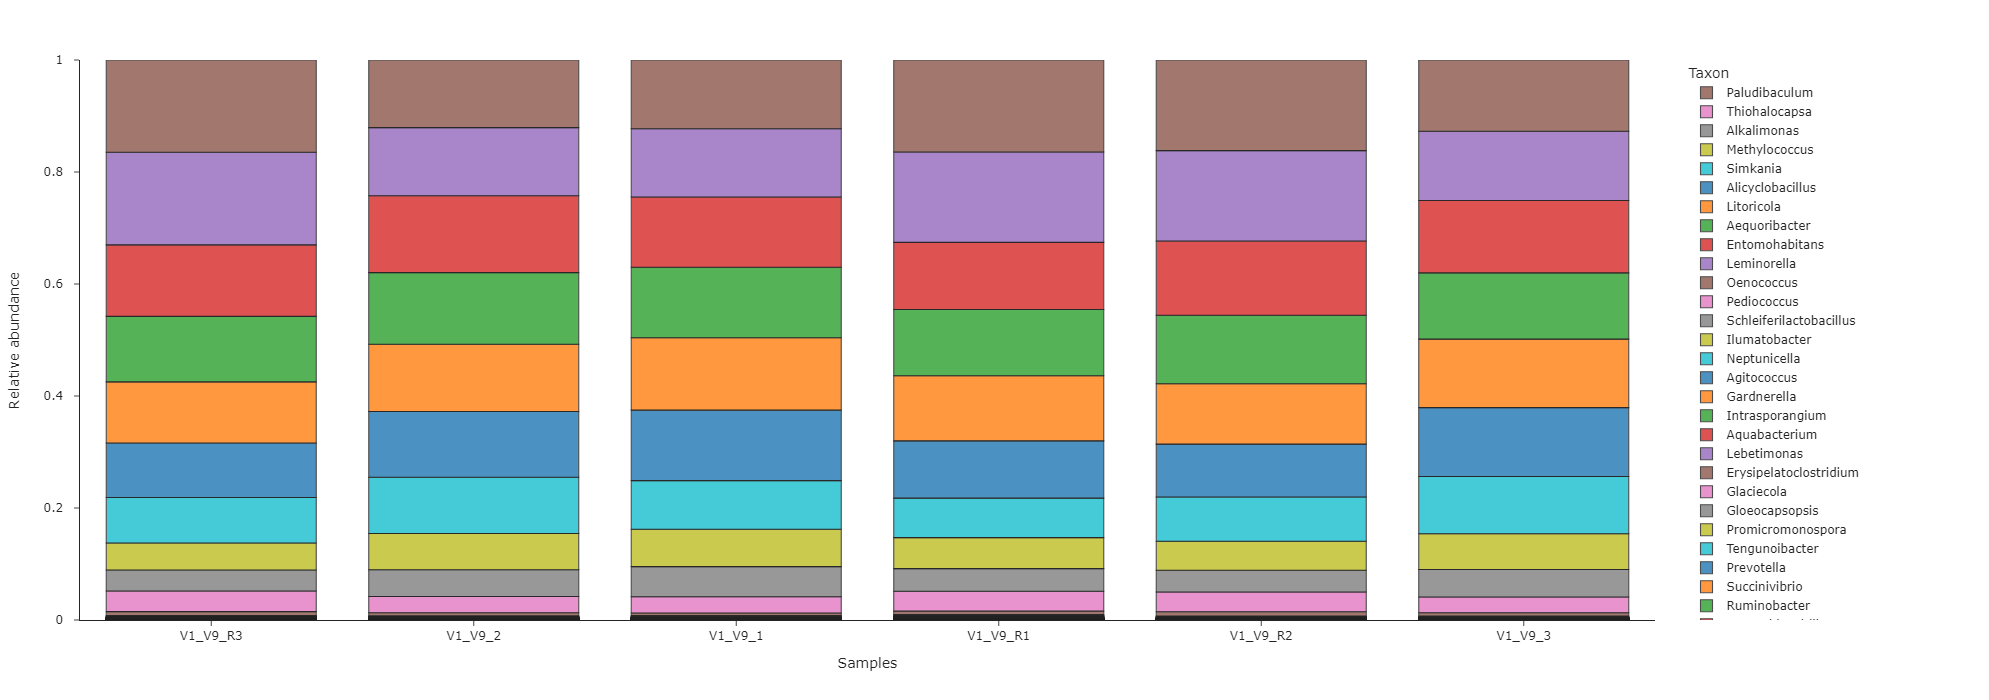

In [1316]:
import warnings 
warnings.filterwarnings('ignore')

df_minimap = DataFrame(wf_meta_minimap[composition]['Genus']).fillna(0) 
df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
df_minimap = df_minimap/df_minimap.sum(axis=0)
df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
        
df_minimap = df_minimap.assign(m=df_minimap.mean(axis=1)).sort_values('m').drop('m', axis=1)#[np.sort(df_to_viz.columns)]

import plotly.express as px
fig = px.bar(df_minimap.T, 
             x=df_minimap.columns, 
             y=df_minimap.index,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',
             color_discrete_map=Color_collection)
fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon')#, legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
#fig.update_xaxes(range=[-0.7, 5.7], autorangeoptions_clipmax=len(data_tax_df.T))

fig.show()

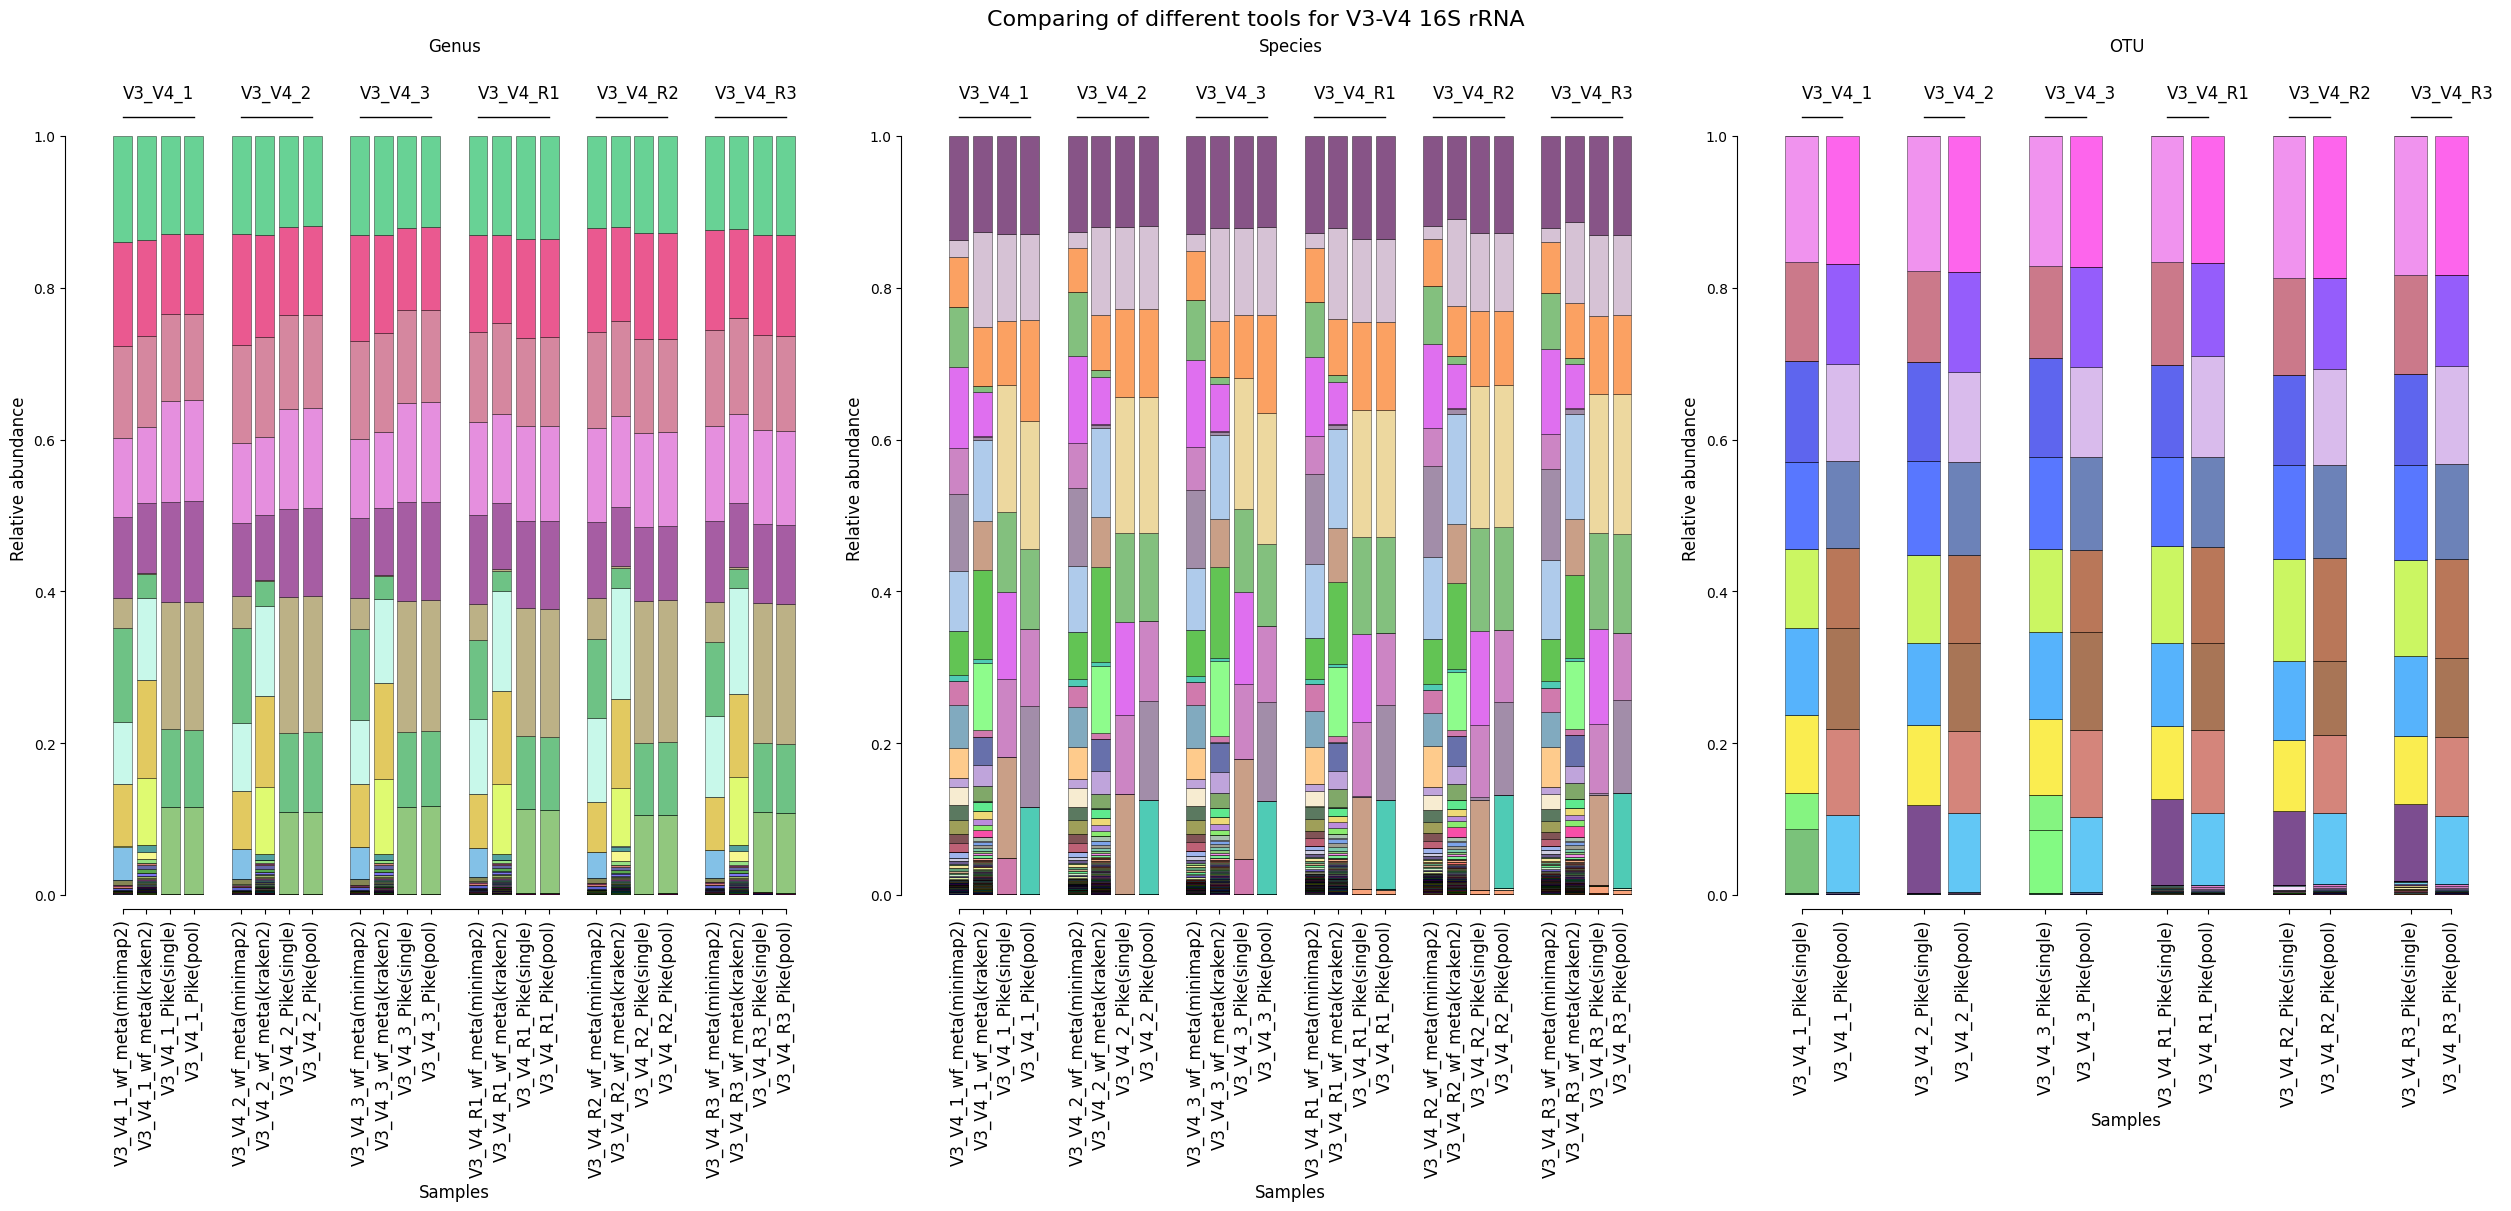

In [1328]:
amplicon = 'V3_V4'
composition = '16S'
dif_taxlev_data = {}

for taxlevel in ['Genus', 'Species', 'OTU']:
    if taxlevel != 'OTU':
        
        df_minimap = DataFrame(wf_meta_minimap[composition][taxlevel]).fillna(0) 
        df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
        df_minimap = df_minimap/df_minimap.sum(axis=0)
        df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
        
        df_kaken = DataFrame(wf_meta_kraken[composition][taxlevel]).fillna(0) 
        df_kaken = df_kaken.loc[df_kaken.index[df_kaken.index.str.contains('Unknown')!=1]]
        df_kaken = df_kaken/df_kaken.sum(axis=0)
        df_kaken = df_kaken[df_kaken.columns[df_kaken.columns.str.contains(amplicon)]]
    
    
    pike_single = full_data[composition][taxlevel][0]
    pike_single = pike_single[pike_single.columns[pike_single.columns.str.contains(amplicon)]]
    pike_pool = full_data_pool[amplicon][taxlevel]
    
    df_to_viz = {}
    for samp in pike_single.columns:
        if taxlevel != 'OTU':
            df_to_viz[f'{samp}_wf_meta(minimap2)'] = df_minimap[samp]
            df_to_viz[f'{samp}_wf_meta(kraken2)'] = df_kaken[samp]
            
       # df_to_viz[f'{samp}_nanoclust'] = nanoclust_res[samp]
        
        df_to_viz[f'{samp}_Pike(single)'] = pike_single[samp]
        df_to_viz[f'{samp}_Pike(pool)'] = pike_pool[samp]
        
    
    df_to_viz = DataFrame(df_to_viz).fillna(0)
    df_to_viz = df_to_viz.assign(m=df_to_viz.mean(axis=1)).sort_values('m').drop('m', axis=1)#[np.sort(df_to_viz.columns)]
    dif_taxlev_data[taxlevel] = df_to_viz
    
fig, axs = plt.subplots(1, 3, figsize=(25, 12), constrained_layout=True)
x_coord = 0
for taxlevel in ['Genus', 'Species', 'OTU']:

    data_tax_df = dif_taxlev_data[taxlevel]
    
    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 1
    c = []
    fst = True
    st = 1
    s_name = ''
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        if taxlevel == 'OTU':
            if sample_coord%3 == 0 : 
                
                axs[x_coord].text(st, 1.05, s_name, fontsize=12)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
        else:
            if sample_coord%5 == 0 : 

                
                axs[x_coord].text(st, 1.05, s_name, fontsize=12)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
            
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
    
            axs[x_coord].bar(sample_coord, 
                          data_tax_df[sample][otu], 
                          width, 
                          bottom=bottom,
                          edgecolor='black',
                          alpha=.7,
                          linewidth=0.4, 
                          color=Color_collection[otu])
            
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
        s_name = '_'.join(sample.split('_')[:3])
        
    if taxlevel == 'OTU':
        if sample_coord%3 == 0 : 

            axs[x_coord].text(st, 1.05, s_name, fontsize=12)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
            
    else:
        if sample_coord%5 == 0 : 

            
            axs[x_coord].text(st, 1.05, s_name, fontsize=12)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
    axs[x_coord].set_ylim(0, 1.1)
    #if taxlevel != 'OTU':
    #    axs[x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=12)
    axs[x_coord].set_ylabel('Relative abundance', fontsize=12)
    axs[x_coord].set_xlabel('Samples', fontsize=12)
    axs[x_coord].set_title(taxlevel, fontsize=12)
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[x_coord])
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=12)
    
    x_coord += 1
fig.suptitle('Comparing of different tools for V3-V4 16S rRNA', fontsize=16)
plt.savefig('VIZ/COMAPRE_ALL_V3_V4.pdf', bbox_inches='tight')
plt.savefig('VIZ/COMAPRE_ALL_V3_V4.png', bbox_inches='tight')
plt.show()

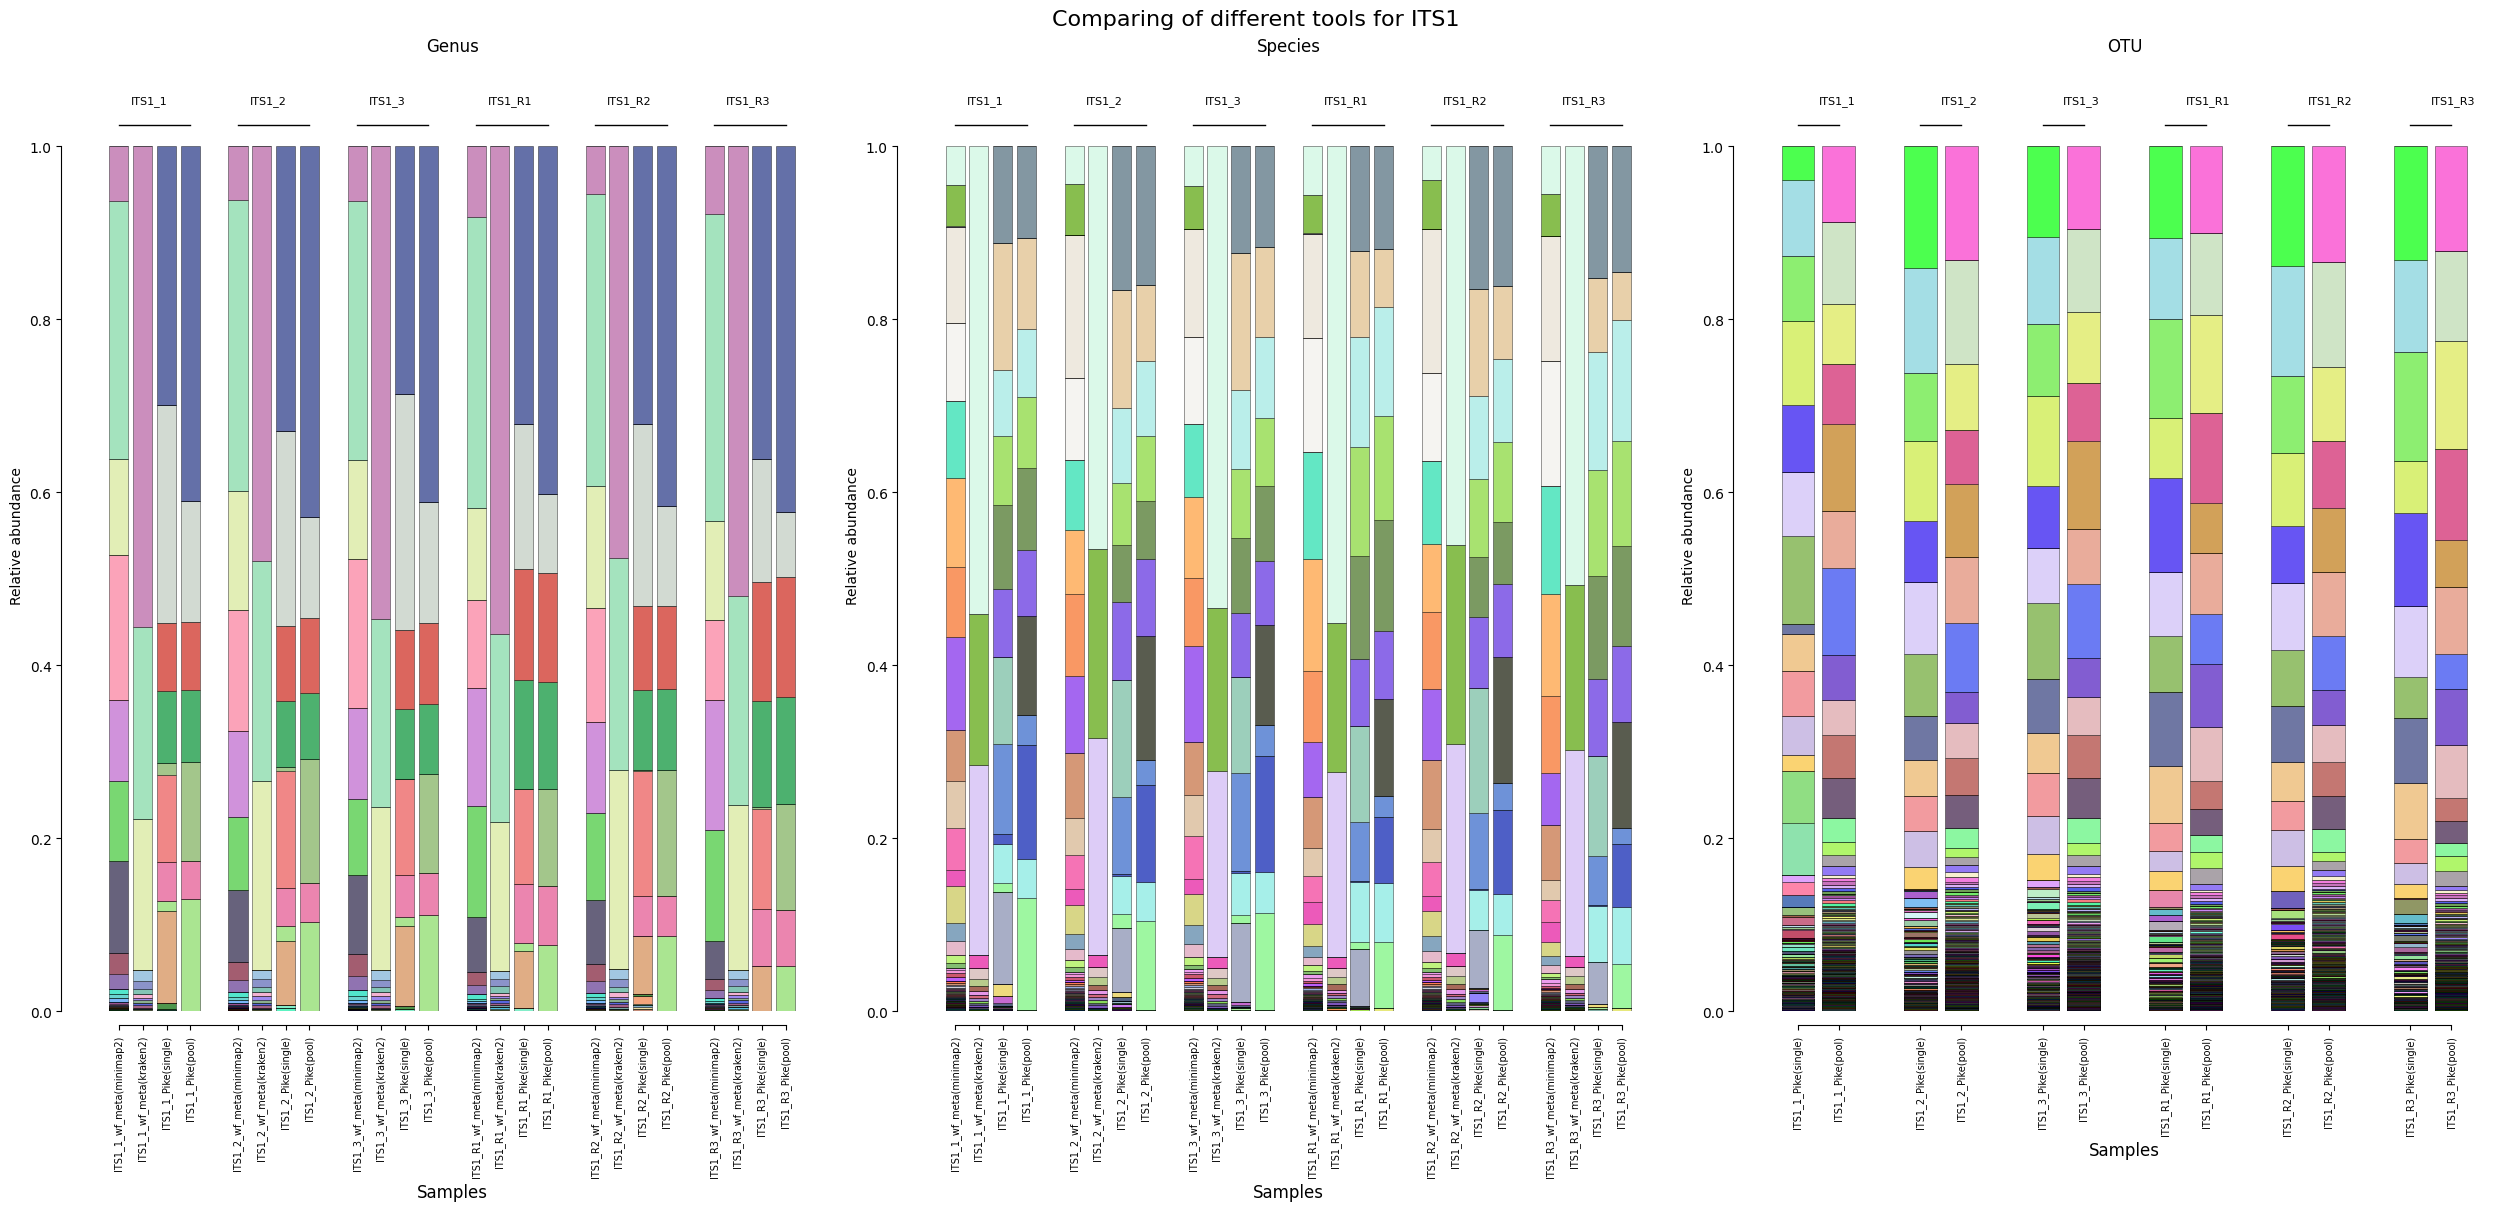

In [1332]:
amplicon = 'ITS1'
composition = 'ITS'
dif_taxlev_data = {}

for taxlevel in ['Genus', 'Species', 'OTU']:
    if taxlevel != 'OTU':
        
        df_minimap = DataFrame(wf_meta_minimap[composition][taxlevel]).fillna(0) 
        df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
        df_minimap = df_minimap/df_minimap.sum(axis=0)
        df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
        
        df_kaken = DataFrame(wf_meta_kraken[composition][taxlevel]).fillna(0) 
        df_kaken = df_kaken.loc[df_kaken.index[df_kaken.index.str.contains('Unknown')!=1]]
        df_kaken = df_kaken/df_kaken.sum(axis=0)
        df_kaken = df_kaken[df_kaken.columns[df_kaken.columns.str.contains(amplicon)]]
    
    
    pike_single = full_data[composition][taxlevel][0]
    pike_single = pike_single[pike_single.columns[pike_single.columns.str.contains(amplicon)]]
    pike_pool = full_data_pool[amplicon][taxlevel]
    
    df_to_viz = {}
    for samp in pike_single.columns:
        
        if '5.8' in samp: 
            #print(samp)
            continue

        if taxlevel != 'OTU':
            df_to_viz[f'{samp}_wf_meta(minimap2)'] = df_minimap[samp]
            df_to_viz[f'{samp}_wf_meta(kraken2)'] = df_kaken[samp]
            
       # df_to_viz[f'{samp}_nanoclust'] = nanoclust_res[samp]
        
        df_to_viz[f'{samp}_Pike(single)'] = pike_single[samp]
        df_to_viz[f'{samp}_Pike(pool)'] = pike_pool[samp]
        
    
    df_to_viz = DataFrame(df_to_viz).fillna(0)
    df_to_viz = df_to_viz.assign(m=df_to_viz.mean(axis=1)).sort_values('m').drop('m', axis=1)#[np.sort(df_to_viz.columns)]
    dif_taxlev_data[taxlevel] = df_to_viz
    
fig, axs = plt.subplots(1, 3, figsize=(25, 12), constrained_layout=True)
x_coord = 0
for taxlevel in ['Genus', 'Species', 'OTU']:

    data_tax_df = dif_taxlev_data[taxlevel]
    
    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 1
    c = []
    fst = True
    st = 1
    s_name = ''
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        if taxlevel == 'OTU':
            if sample_coord%3 == 0 : 
                
                axs[x_coord].text(st+1-0.5, 1.05, s_name, fontsize=8)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
        else:
            if sample_coord%5 == 0 : 

                
                axs[x_coord].text(st+1-.5, 1.05, s_name, fontsize=8)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
            
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
    
            axs[x_coord].bar(sample_coord, 
                          data_tax_df[sample][otu], 
                          width, 
                          bottom=bottom,
                          edgecolor='black',
                          alpha=.7,
                          linewidth=0.4, 
                          color=Color_collection[otu])
            
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
        s_name = '_'.join(sample.split('_')[:2])
        
    if taxlevel == 'OTU':
        if sample_coord%3 == 0 : 

            axs[x_coord].text(st+1-0.5, 1.05, s_name, fontsize=8)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
            
    else:
        if sample_coord%5 == 0 : 

            
            axs[x_coord].text(st+1-.5, 1.05, s_name, fontsize=8)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
    axs[x_coord].set_ylim(0, 1.1)
    #if taxlevel != 'OTU':
    #    axs[x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[x_coord].set_xlabel('Samples', fontsize=12)
    axs[x_coord].set_title(taxlevel, fontsize=12)
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[x_coord])
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)
    
    x_coord += 1
fig.suptitle('Comparing of different tools for ITS1', fontsize=16)
plt.savefig('VIZ/COMAPRE_ALL_ITS1.pdf', bbox_inches='tight')
plt.savefig('VIZ/COMAPRE_ALL_ITS1.png', bbox_inches='tight')
plt.show()

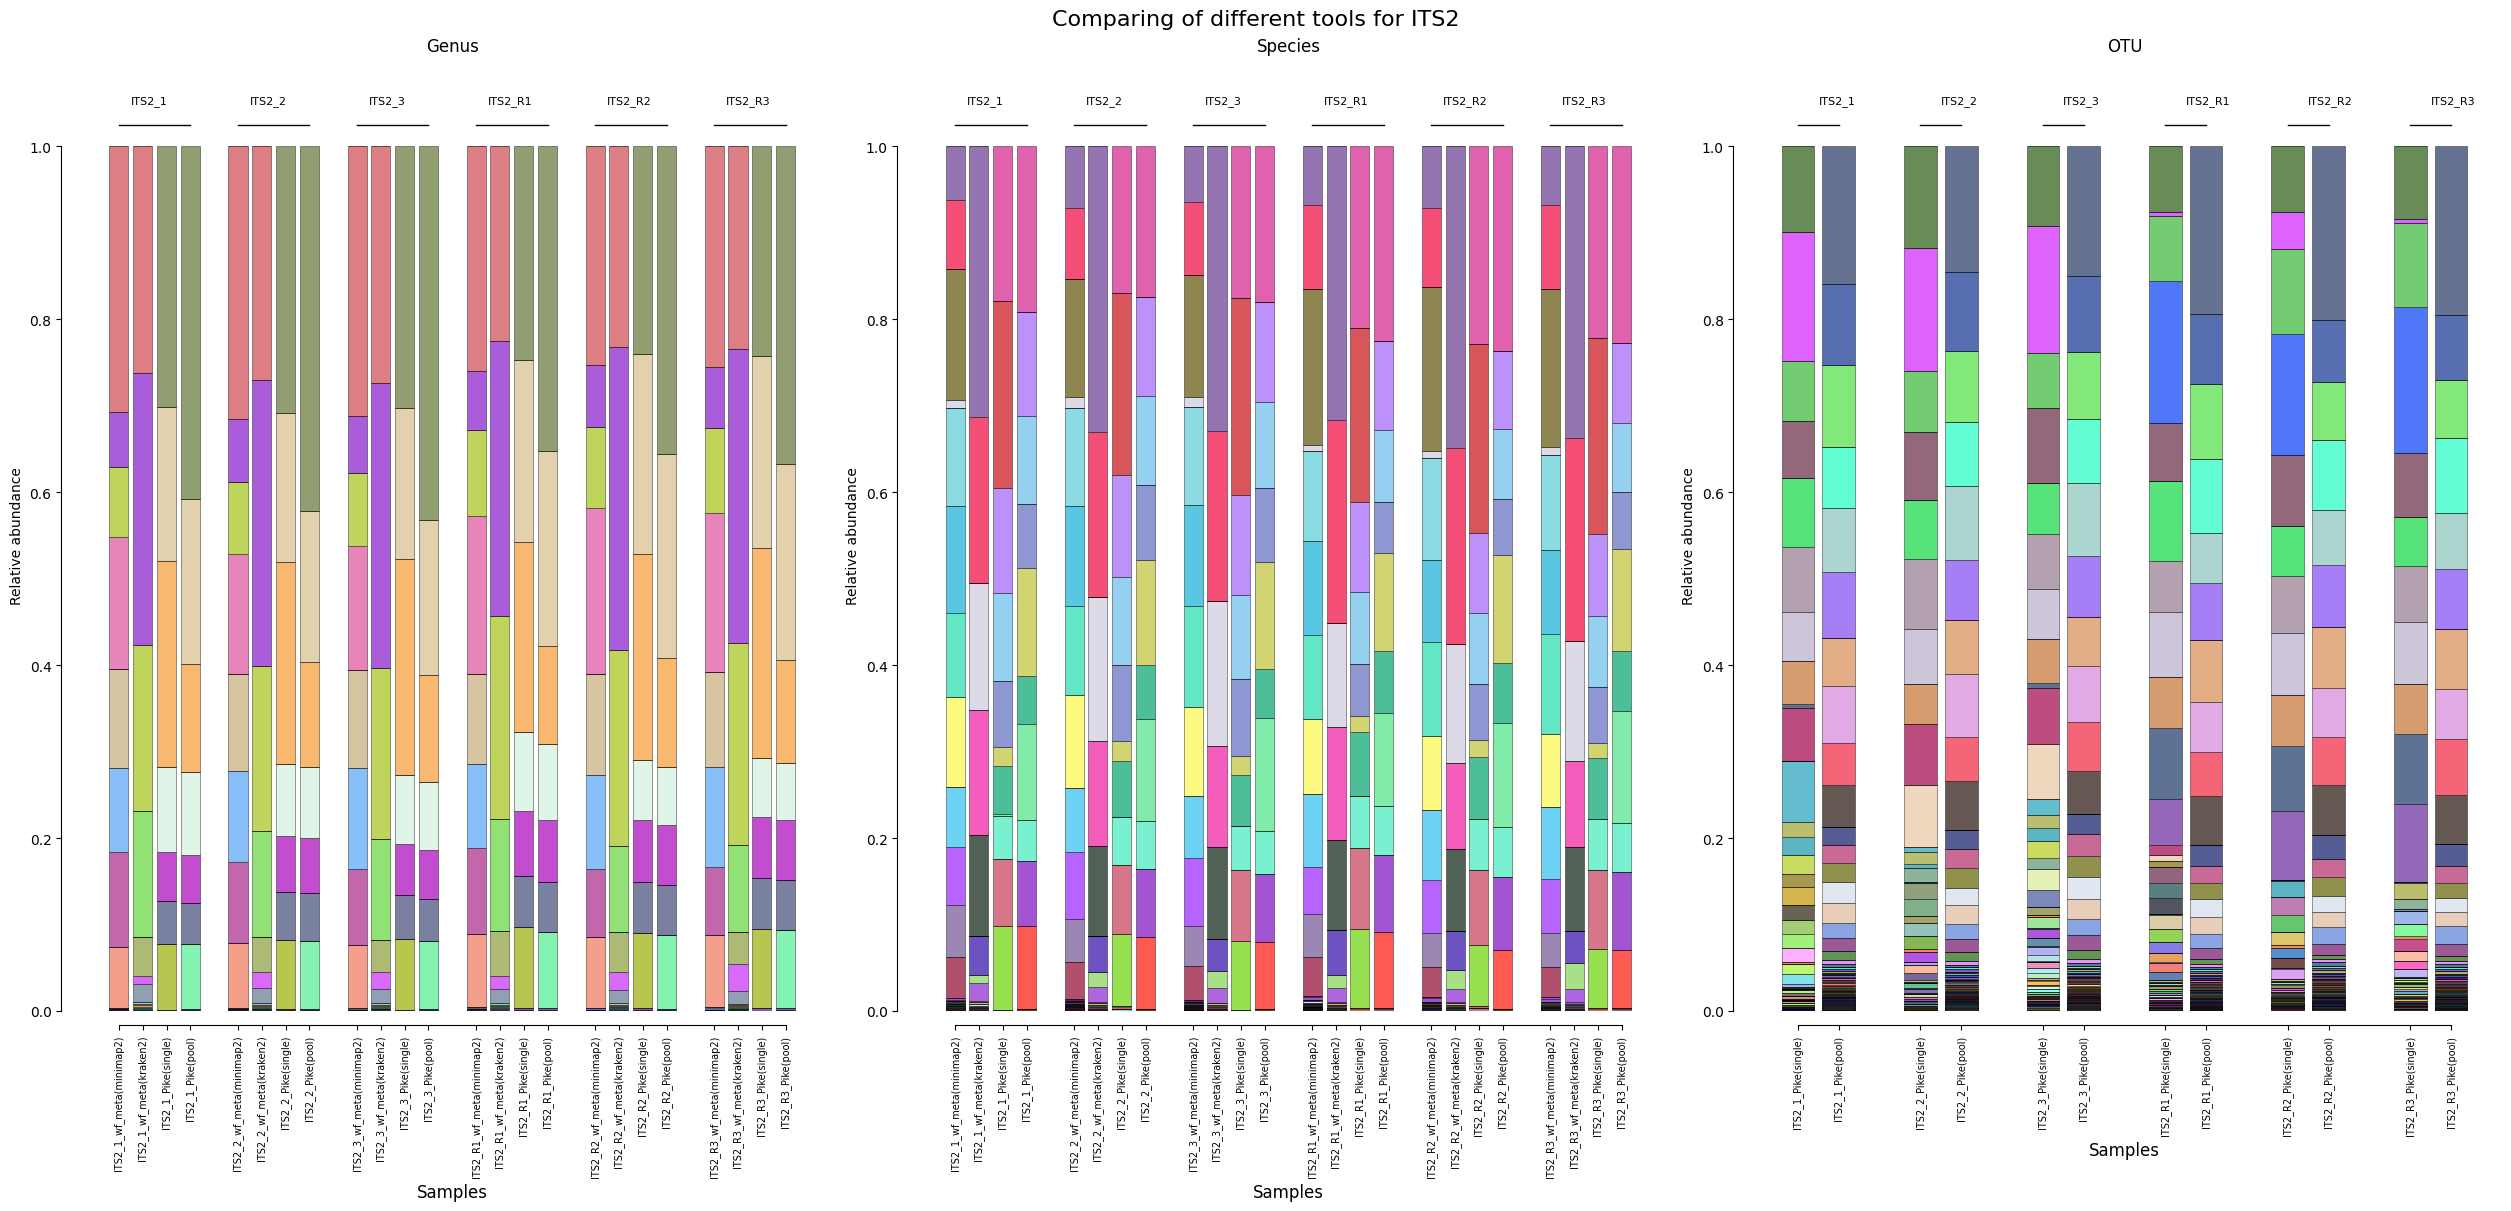

In [1333]:
amplicon = 'ITS2'
composition = 'ITS'
dif_taxlev_data = {}

for taxlevel in ['Genus', 'Species', 'OTU']:
    if taxlevel != 'OTU':
        
        df_minimap = DataFrame(wf_meta_minimap[composition][taxlevel]).fillna(0) 
        df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
        df_minimap = df_minimap/df_minimap.sum(axis=0)
        df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
        
        df_kaken = DataFrame(wf_meta_kraken[composition][taxlevel]).fillna(0) 
        df_kaken = df_kaken.loc[df_kaken.index[df_kaken.index.str.contains('Unknown')!=1]]
        df_kaken = df_kaken/df_kaken.sum(axis=0)
        df_kaken = df_kaken[df_kaken.columns[df_kaken.columns.str.contains(amplicon)]]
    
    
    pike_single = full_data[composition][taxlevel][0]
    pike_single = pike_single[pike_single.columns[pike_single.columns.str.contains(amplicon)]]
    pike_pool = full_data_pool[amplicon][taxlevel]
    
    df_to_viz = {}
    for samp in pike_single.columns:
        
        if '5.8' in samp: 
            #print(samp)
            continue

        if taxlevel != 'OTU':
            df_to_viz[f'{samp}_wf_meta(minimap2)'] = df_minimap[samp]
            df_to_viz[f'{samp}_wf_meta(kraken2)'] = df_kaken[samp]
            
       # df_to_viz[f'{samp}_nanoclust'] = nanoclust_res[samp]
        
        df_to_viz[f'{samp}_Pike(single)'] = pike_single[samp]
        df_to_viz[f'{samp}_Pike(pool)'] = pike_pool[samp]
        
    
    df_to_viz = DataFrame(df_to_viz).fillna(0)
    df_to_viz = df_to_viz.assign(m=df_to_viz.mean(axis=1)).sort_values('m').drop('m', axis=1)#[np.sort(df_to_viz.columns)]
    dif_taxlev_data[taxlevel] = df_to_viz
    
fig, axs = plt.subplots(1, 3, figsize=(25, 12), constrained_layout=True)
x_coord = 0
for taxlevel in ['Genus', 'Species', 'OTU']:

    data_tax_df = dif_taxlev_data[taxlevel]
    
    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 1
    c = []
    fst = True
    st = 1
    s_name = ''
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        if taxlevel == 'OTU':
            if sample_coord%3 == 0 : 
                
                axs[x_coord].text(st+1-0.5, 1.05, s_name, fontsize=8)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
        else:
            if sample_coord%5 == 0 : 

                
                axs[x_coord].text(st+1-.5, 1.05, s_name, fontsize=8)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
            
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
    
            axs[x_coord].bar(sample_coord, 
                          data_tax_df[sample][otu], 
                          width, 
                          bottom=bottom,
                          edgecolor='black',
                          alpha=.7,
                          linewidth=0.4, 
                          color=Color_collection[otu])
            
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
        s_name = '_'.join(sample.split('_')[:2])
        
    if taxlevel == 'OTU':
        if sample_coord%3 == 0 : 

            axs[x_coord].text(st+1-0.5, 1.05, s_name, fontsize=8)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
            
    else:
        if sample_coord%5 == 0 : 

            
            axs[x_coord].text(st+1-.5, 1.05, s_name, fontsize=8)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
    axs[x_coord].set_ylim(0, 1.1)
    #if taxlevel != 'OTU':
    #    axs[x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[x_coord].set_xlabel('Samples', fontsize=12)
    axs[x_coord].set_title(taxlevel, fontsize=12)
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[x_coord])
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)
    
    x_coord += 1
fig.suptitle('Comparing of different tools for ITS2', fontsize=16)
plt.savefig('VIZ/COMAPRE_ALL_ITS2.pdf', bbox_inches='tight')
plt.savefig('VIZ/COMAPRE_ALL_ITS2.png', bbox_inches='tight')
plt.show()

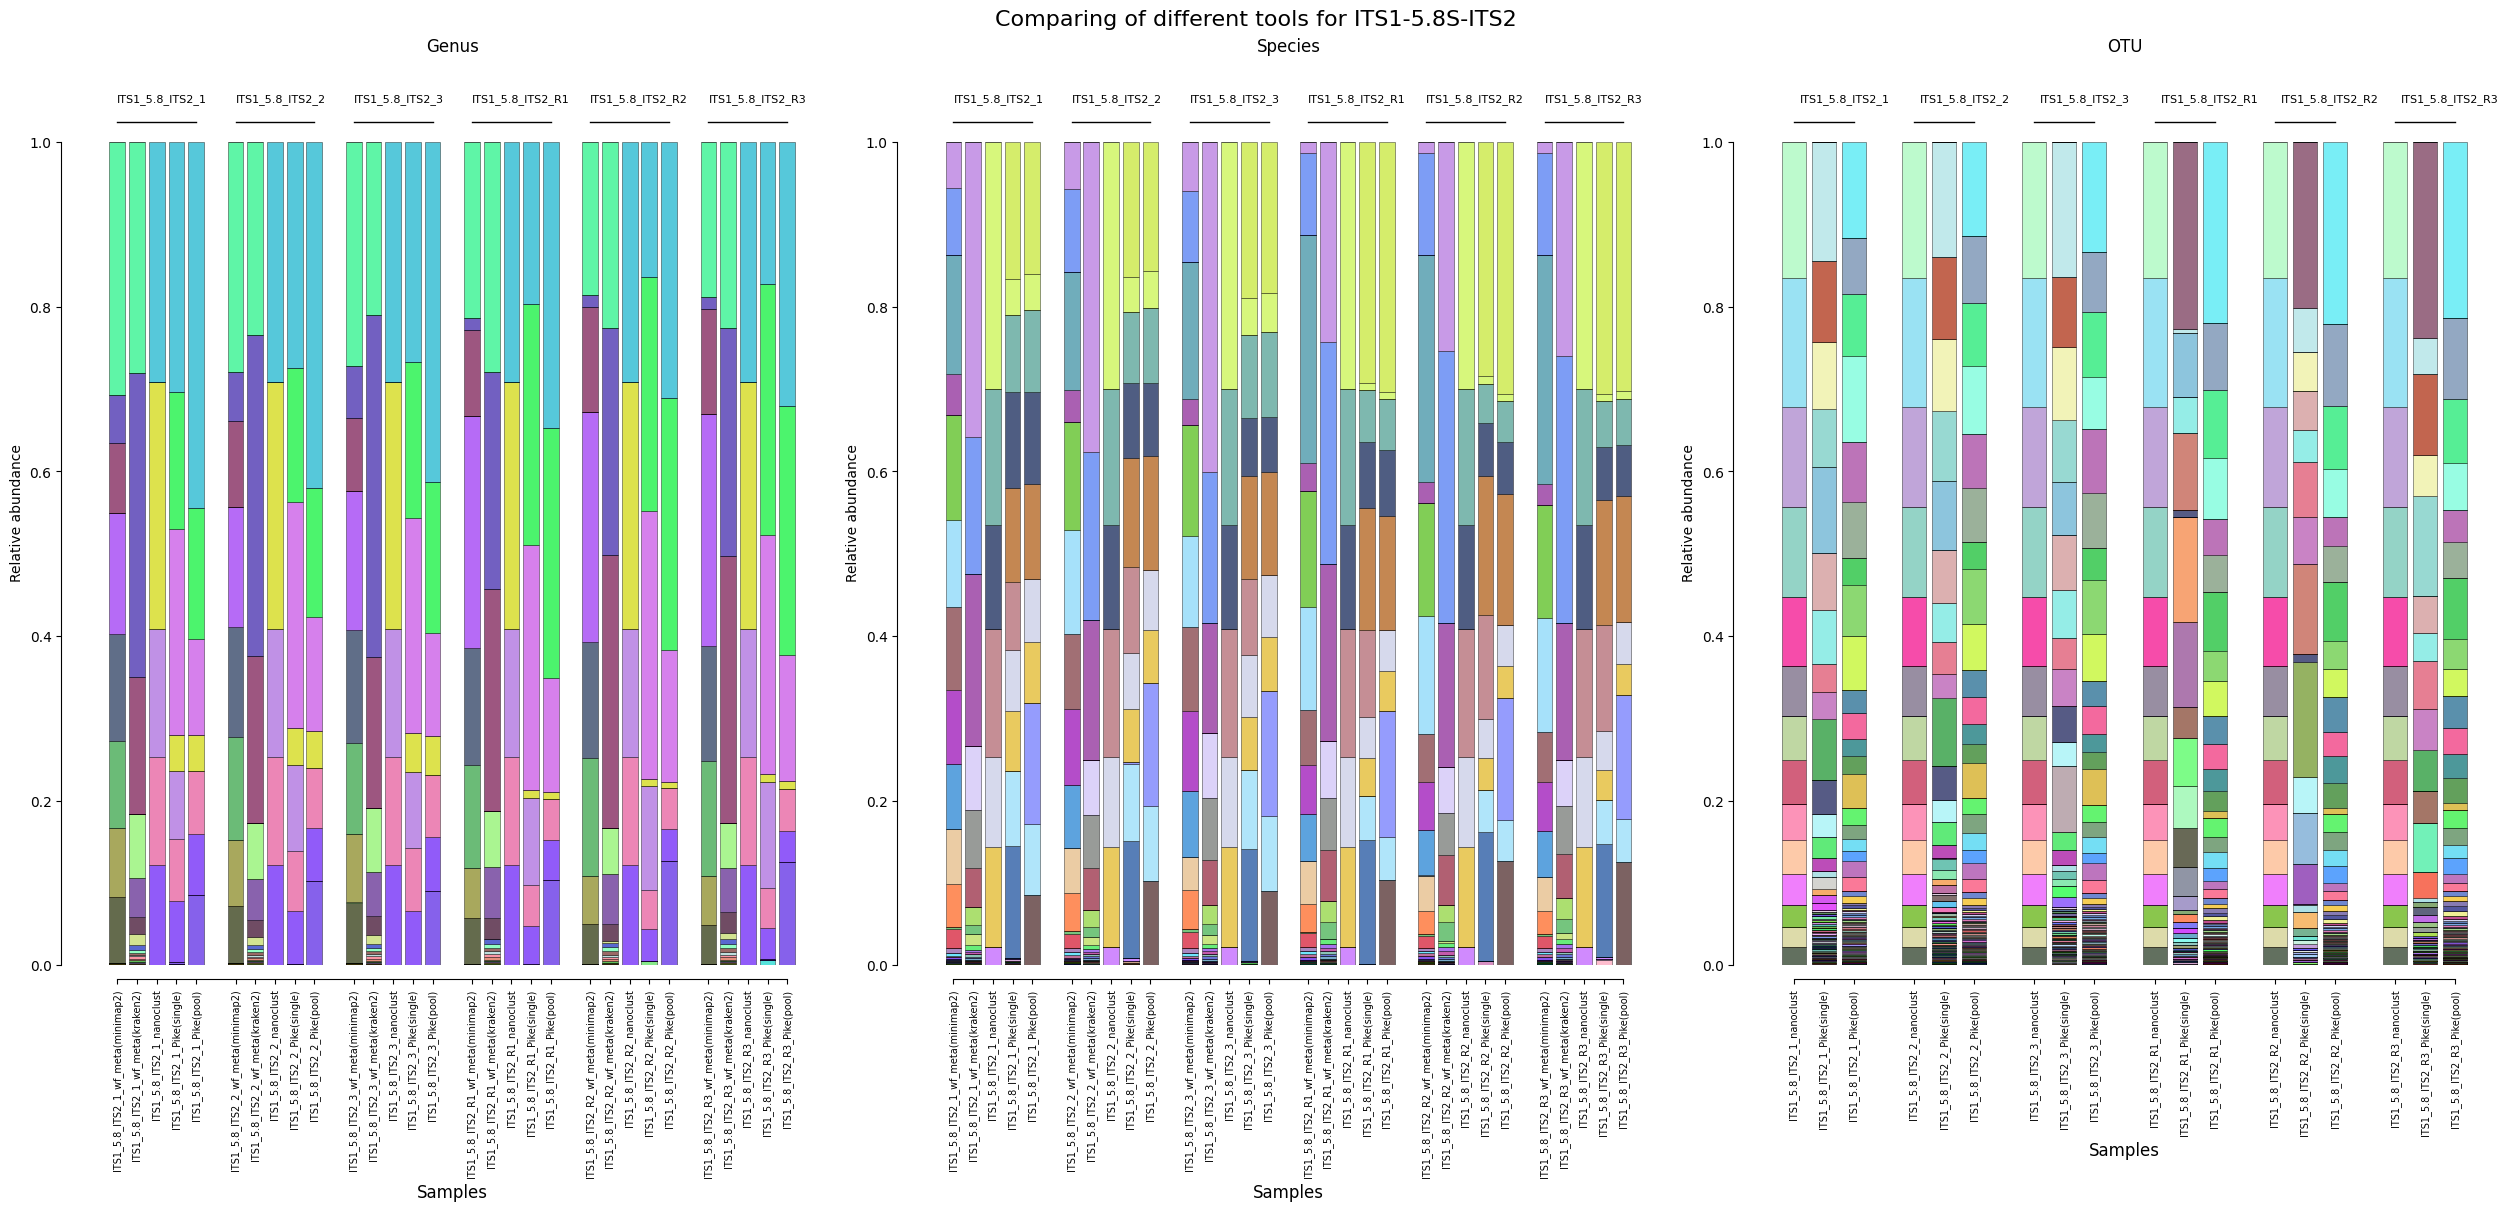

In [1348]:
amplicon = 'ITS1_5.8'
composition = 'ITS'
dif_taxlev_data = {}

for taxlevel in ['Genus', 'Species', 'OTU']:
    if taxlevel != 'OTU':
        
        df_minimap = DataFrame(wf_meta_minimap[composition][taxlevel]).fillna(0) 
        df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
        df_minimap = df_minimap/df_minimap.sum(axis=0)
        df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
        
        df_kaken = DataFrame(wf_meta_kraken[composition][taxlevel]).fillna(0) 
        df_kaken = df_kaken.loc[df_kaken.index[df_kaken.index.str.contains('Unknown')!=1]]
        df_kaken = df_kaken/df_kaken.sum(axis=0)
        df_kaken = df_kaken[df_kaken.columns[df_kaken.columns.str.contains(amplicon)]]
    
    nanoclust_res = nanoclust[composition][taxlevel]
    
    pike_single = full_data[composition][taxlevel][0]
    pike_single = pike_single[pike_single.columns[pike_single.columns.str.contains(amplicon)]]
    pike_pool = full_data_pool['ITS_full'][taxlevel]
    
    df_to_viz = {}
    for samp in pike_single.columns:
        if taxlevel != 'OTU':
            df_to_viz[f'{samp}_wf_meta(minimap2)'] = df_minimap[samp]
            df_to_viz[f'{samp}_wf_meta(kraken2)'] = df_kaken[samp]
            
        df_to_viz[f'{samp}_nanoclust'] = nanoclust_res['8S'.join('ITS1_5.8_ITS2_1'.replace('_', '-').split('8'))[:-2]+'_'+'ITS1_5.8_ITS2_1'[-1]]
        
        df_to_viz[f'{samp}_Pike(single)'] = pike_single[samp]
        df_to_viz[f'{samp}_Pike(pool)'] = pike_pool[samp]
        
    
    df_to_viz = DataFrame(df_to_viz).fillna(0)
    df_to_viz = df_to_viz.assign(m=df_to_viz.mean(axis=1)).sort_values('m').drop('m', axis=1)#[np.sort(df_to_viz.columns)]
    dif_taxlev_data[taxlevel] = df_to_viz
    
fig, axs = plt.subplots(1, 3, figsize=(25, 12), constrained_layout=True)
x_coord = 0
for taxlevel in ['Genus', 'Species', 'OTU']:

    data_tax_df = dif_taxlev_data[taxlevel]
    
    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 1
    c = []
    fst = True
    st = 1
    s_name = ''
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        if taxlevel == 'OTU':
            if sample_coord%4 == 0 : 
                
                axs[x_coord].text(st+0.2, 1.05, s_name, fontsize=8)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
        else:
            if sample_coord%6 == 0 : 

                
                axs[x_coord].text(st, 1.05, s_name, fontsize=8)
                axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
                sample_coord += 1
                st = sample_coord
            
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
    
            axs[x_coord].bar(sample_coord, 
                          data_tax_df[sample][otu], 
                          width, 
                          bottom=bottom,
                          edgecolor='black',
                          alpha=.7,
                          linewidth=0.4, 
                          color=Color_collection[otu])
            
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
        s_name = '_'.join(sample.split('_')[:4])
        
    if taxlevel == 'OTU':
        if sample_coord%4 == 0 : 

            axs[x_coord].text(st+0.2, 1.05, s_name, fontsize=8)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
            
    else:
        if sample_coord%6 == 0 : 

            
            axs[x_coord].text(st, 1.05, s_name, fontsize=8)
            axs[x_coord].plot([st, sample_coord-1], [1.025, 1.025], linewidth=1, color='black')
            sample_coord += 1
            st = sample_coord
    axs[x_coord].set_ylim(0, 1.1)
    #if taxlevel != 'OTU':
    #    axs[x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[x_coord].set_xlabel('Samples', fontsize=12)
    axs[x_coord].set_title(taxlevel, fontsize=12)
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[x_coord])
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)
    
    x_coord += 1
fig.suptitle('Comparing of different tools for ITS1-5.8S-ITS2', fontsize=16)
plt.savefig('VIZ/COMAPRE_ALL_ITS1_5.8S_ITS2.pdf', bbox_inches='tight')
plt.savefig('VIZ/COMAPRE_ALL_ITS1_5.8S_ITS2.png', bbox_inches='tight')
plt.show()

In [1329]:
s_name

'V3_V4_R3'

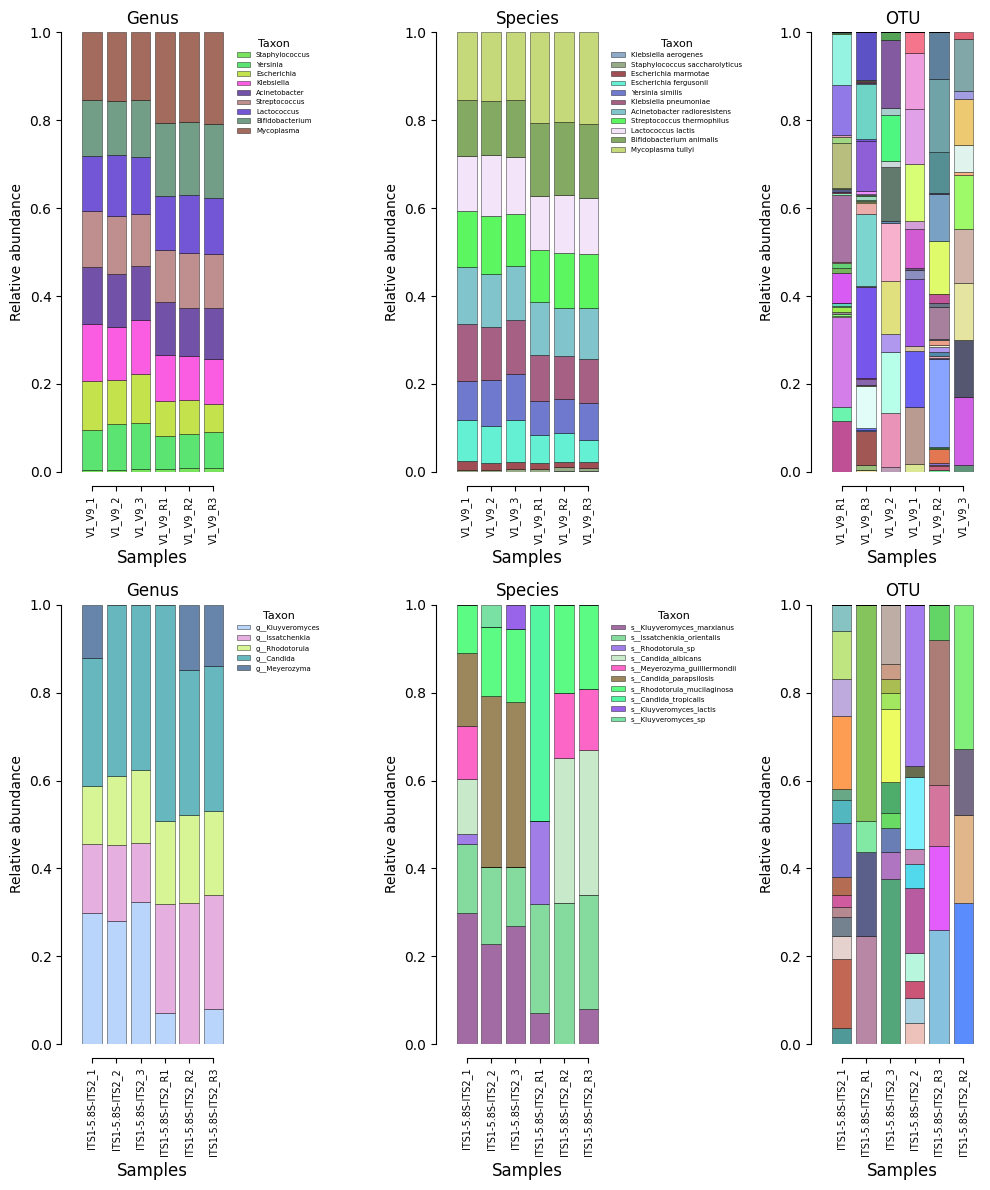

In [1355]:
fig, axs = plt.subplots(2, 3, figsize=(10, 12))

x_coord = 0
y_coord = 0
for taxlevel in nanoclust['16S'].keys():
    
    data_tax_df = nanoclust['16S'][taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[y_coord][x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[y_coord][x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[y_coord][x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[y_coord][x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[y_coord][x_coord].set_xlabel('Samples', fontsize=12)
    axs[y_coord][x_coord].set_title(taxlevel, fontsize=12)
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[y_coord][x_coord])
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1



x_coord = 0
y_coord += 1

for taxlevel in nanoclust['ITS'].keys():
    
    data_tax_df = nanoclust['ITS'][taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[y_coord][x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[y_coord][x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[y_coord][x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[y_coord][x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[y_coord][x_coord].set_xlabel('Samples', fontsize=12)
    axs[y_coord][x_coord].set_title(taxlevel, fontsize=12)
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[y_coord][x_coord])
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1

plt.tight_layout()
plt.savefig('VIZ/NANOCLUST_FUNGI.pdf')
plt.savefig('VIZ/NANOCLUST_FUNGI.png', dpi=800)
plt.show()

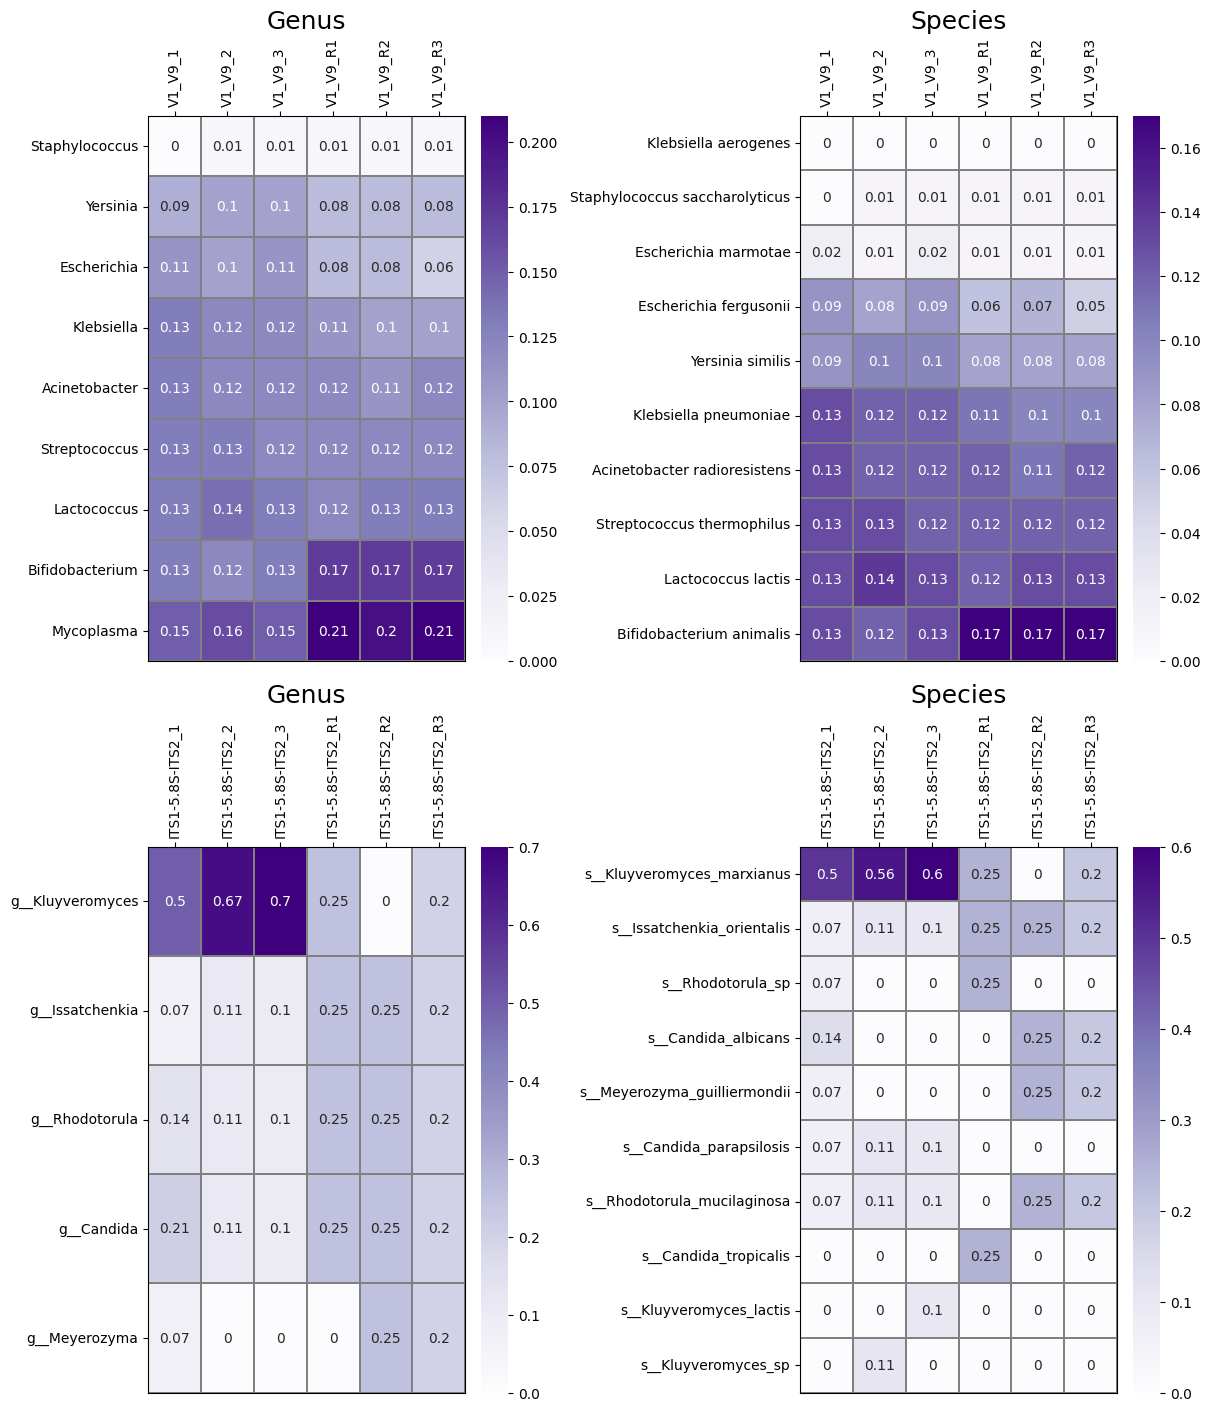

In [1323]:
fig, axs = plt.subplots(2, 2, figsize=(12, 14), constrained_layout=True)

x_coord = 0
for taxlevel in ['Genus', 'Species']:

    data_tax_df = nanoclust['16S'][taxlevel]
    
    sns.heatmap(np.round(data_tax_df, 2)[:10], 
                        ax=axs[0][x_coord], cmap='Purples', linewidths=.1, linecolor='grey',
                        annot=True)
    axs[0][x_coord].xaxis.tick_top()
    axs[0][x_coord].set_title(taxlevel, fontsize=18)
    axs[0][x_coord].set_xlabel('')
    
    for spine in axs[0][x_coord].spines.values():
        spine.set_visible(True)
    for spine in axs[0][x_coord].spines.values():
        spine.set(visible=True, lw=.8, edgecolor="black")
    
    axs[0][x_coord].tick_params(axis='x', labelrotation=90)
    axs[0][x_coord].tick_params(axis='y', labelrotation=360)
    x_coord += 1


x_coord = 0
for taxlevel in ['Genus', 'Species']:

    data_tax_df = nanoclust['ITS'][taxlevel]
    
    sns.heatmap(np.round(data_tax_df, 2)[:10], 
                        ax=axs[1][x_coord], cmap='Purples', linewidths=.1, linecolor='grey',
                        annot=True)
    axs[1][x_coord].xaxis.tick_top()
    axs[1][x_coord].set_title(taxlevel, fontsize=18)
    axs[1][x_coord].set_xlabel('')
    
    for spine in axs[1][x_coord].spines.values():
        spine.set_visible(True)
    for spine in axs[1][x_coord].spines.values():
        spine.set(visible=True, lw=.8, edgecolor="black")
    
    axs[1][x_coord].tick_params(axis='x', labelrotation=90)
    axs[1][x_coord].tick_params(axis='y', labelrotation=360)
    x_coord += 1
plt.savefig('VIZ/Nanoclust_res_heatmap.pdf', bbox_inches='tight')
plt.savefig('VIZ/Nanoclust_res_heatmap.png', dpi=800, bbox_inches='tight')
plt.show()

TypeError: unsupported operand type(s) for *: 'dict' and 'float'

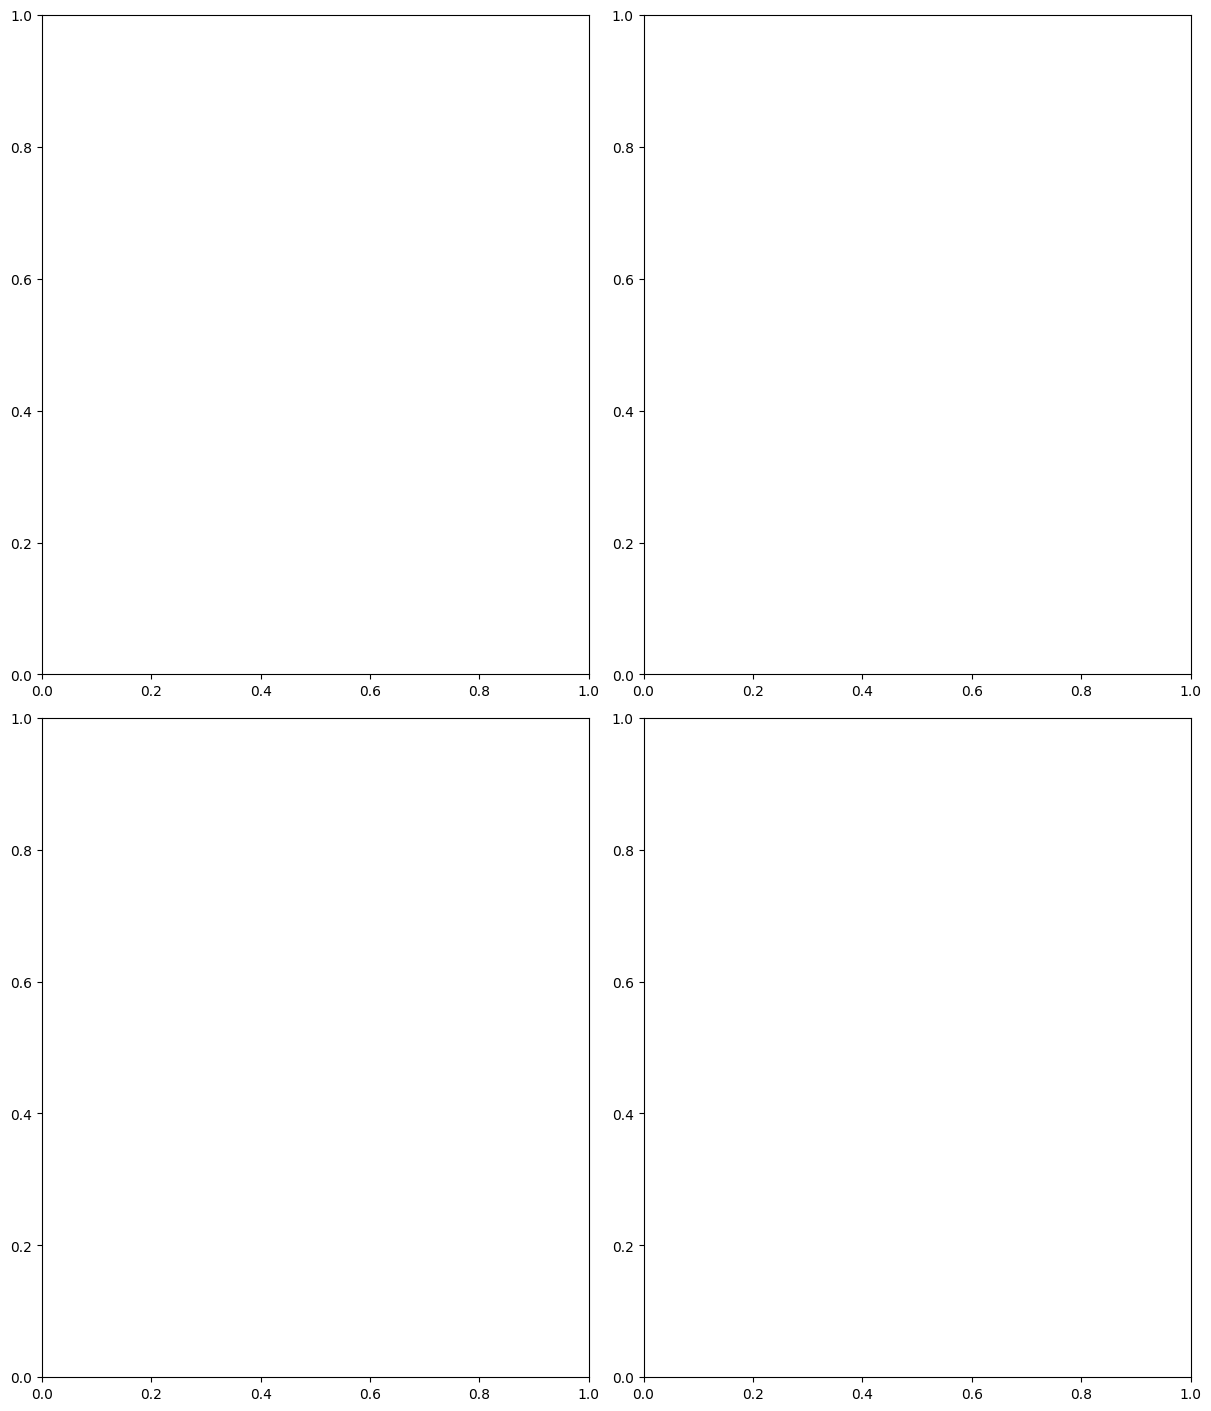

In [1324]:
fig, axs = plt.subplots(2, 2, figsize=(12, 14), constrained_layout=True)

x_coord = 0
for taxlevel in ['Genus', 'Species']:

    data_tax_df = wf_meta_minimap['16S'][taxlevel]
    
    sns.heatmap(np.round(data_tax_df, 2)[:10], 
                        ax=axs[0][x_coord], cmap='Purples', linewidths=.1, linecolor='grey',
                        annot=True)
    axs[0][x_coord].xaxis.tick_top()
    axs[0][x_coord].set_title(taxlevel, fontsize=18)
    axs[0][x_coord].set_xlabel('')
    
    for spine in axs[0][x_coord].spines.values():
        spine.set_visible(True)
    for spine in axs[0][x_coord].spines.values():
        spine.set(visible=True, lw=.8, edgecolor="black")
    
    axs[0][x_coord].tick_params(axis='x', labelrotation=90)
    axs[0][x_coord].tick_params(axis='y', labelrotation=360)
    x_coord += 1


x_coord = 0
for taxlevel in ['Genus', 'Species']:

    data_tax_df = nanoclust['ITS'][taxlevel]
    
    sns.heatmap(np.round(data_tax_df, 2)[:10], 
                        ax=axs[1][x_coord], cmap='Purples', linewidths=.1, linecolor='grey',
                        annot=True)
    axs[1][x_coord].xaxis.tick_top()
    axs[1][x_coord].set_title(taxlevel, fontsize=18)
    axs[1][x_coord].set_xlabel('')
    
    for spine in axs[1][x_coord].spines.values():
        spine.set_visible(True)
    for spine in axs[1][x_coord].spines.values():
        spine.set(visible=True, lw=.8, edgecolor="black")
    
    axs[1][x_coord].tick_params(axis='x', labelrotation=90)
    axs[1][x_coord].tick_params(axis='y', labelrotation=360)
    x_coord += 1
#plt.savefig('VIZ/Nanoclust_res_heatmap.pdf', bbox_inches='tight')
#plt.savefig('VIZ/Nanoclust_res_heatmap.png', dpi=800, bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 12))

x_coord = 0
y_coord = 0

df_minimap = DataFrame(wf_meta_minimap[composition][taxlevel]).fillna(0) 
df_minimap = df_minimap.loc[df_minimap.index[df_minimap.index.str.contains('Unknown')!=1]]
df_minimap = df_minimap/df_minimap.sum(axis=0)
df_minimap = df_minimap[df_minimap.columns[df_minimap.columns.str.contains(amplicon)]]
for taxlevel in wf_meta_minimap['16S'].keys():
    
    data_tax_df = wf_meta_minimap['16S'][taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[y_coord][x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[y_coord][x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[y_coord][x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[y_coord][x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[y_coord][x_coord].set_xlabel('Samples', fontsize=12)
    axs[y_coord][x_coord].set_title(taxlevel, fontsize=12)
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[y_coord][x_coord])
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1



x_coord = 0
y_coord += 1

for taxlevel in wf_meta_minimap['ITS'].keys():
    
    data_tax_df = wf_meta_minimap['ITS'][taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[y_coord][x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[y_coord][x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[y_coord][x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[y_coord][x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[y_coord][x_coord].set_xlabel('Samples', fontsize=12)
    axs[y_coord][x_coord].set_title(taxlevel, fontsize=12)
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[y_coord][x_coord])
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1

plt.tight_layout()
#plt.savefig('VIZ/NANOCLUST_FUNGI.pdf')
#plt.savefig('VIZ/NANOCLUST_FUNGI.png', dpi=800)
plt.show()

In [ ]:
a= pd.read_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pool_diff_kmers/ITS/pool_ITS_full_k_3/merged_otu_table.tsv', sep='\t', index_col=0).T
b= pd.read_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pool_diff_kmers/ITS/pool_ITS_full_k_5/merged_otu_table.tsv', sep='\t', index_col=0).T

In [1024]:
a

ITS1_5.8_ITS2_R1_k3  \
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.003111   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCAAACTTGTTTG...             0.004077   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000465   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.070019   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.187813   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTGT...             0.095945   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGTCAAAGTTTGAAG...             0.075919   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCGACAACAAAACG...             0.001323   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000286   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.005114   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.002467   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCGACAACAAAACG...             0.136926   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000393   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCAAACTTGTTTG...             0.040767   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGATCTAATCTTAAAA...             0.004685   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGTCGAATTTGGAAG...             0.000322   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.005686   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGTCAAAGTTATGAA...             0.047740   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGATCTAATCTTAAAA...             0.000608   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGAAGTAATTTTCA...             0.000358   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...             0.000715   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCGACAACAAAACG...             0.000429   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTGT...             0.000429   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTGT...             0.001109   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.001216   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...             0.000179   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.029538   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGTCGAATTTGGAAG...             0.054248   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCGACAACAAAACG...             0.005042   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.001645   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...             0.001645   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.002432   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.007939   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTGT...             0.000501   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000572   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000787   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.008654   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000358   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCGACAACAAAACG...             0.000250   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGTCAAAGTTTGAAG...             0.001323   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGTCAAAGTTATGAA...             0.000608   
TTAAGTTCAGCGGGTACTCCTACCTGATTTGAGGTCAAACTTTGAGA...             0.007188   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGATCTAATCTTAAAA...             0.044343   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...             0.127771   
TTAAGTTCAGCGGGTATTCCTACCTGATTTGAGGTCGAGCTTTTTGT...             0.000822   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...             0.000966   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAAATGTCGTG...             0.001144   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCCACAACAAACGA...             0.002718   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCGAATGTCAACA...             0.004220   
TTAAGTTCAGCGGGTAATCTCGGATGAAGGAGGTGAAATGACGTAAT...             0.000322   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGGCAAATGTCGTGC...             0.006508   
TTAAGTTCAGCGGGTAGTCCTACCTGATTTGAGGCGACAACAAAACG...             0.000358   

                                                    ITS1_5.8_ITS2_R3_k3  \
T

In [1038]:
t = pd.read_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pool_diff_kmers/ITS/pool_ITS_full_k_3/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)
retax_data = {}

for seq in a.index:
    try:
        tax = t['Species'][seq]
        
        if tax not in retax_data.keys():
            
            retax_data[tax] = {samp :0 for samp in a.columns}
            
        for samp in a.columns:
            retax_data[tax][samp] += a[samp][seq]
    except:continue
retax_data = DataFrame(retax_data).T
retax_data = retax_data/retax_data.sum(axis=0)

In [1045]:
retax_data = retax_data.assign(m=retax_data.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(retax_data.columns)]


ITS1_5.8_ITS2_1_k3
ITS1_5.8_ITS2_2_k3
ITS1_5.8_ITS2_3_k3
ITS1_5.8_ITS2_R1_k3
ITS1_5.8_ITS2_R2_k3
ITS1_5.8_ITS2_R3_k3


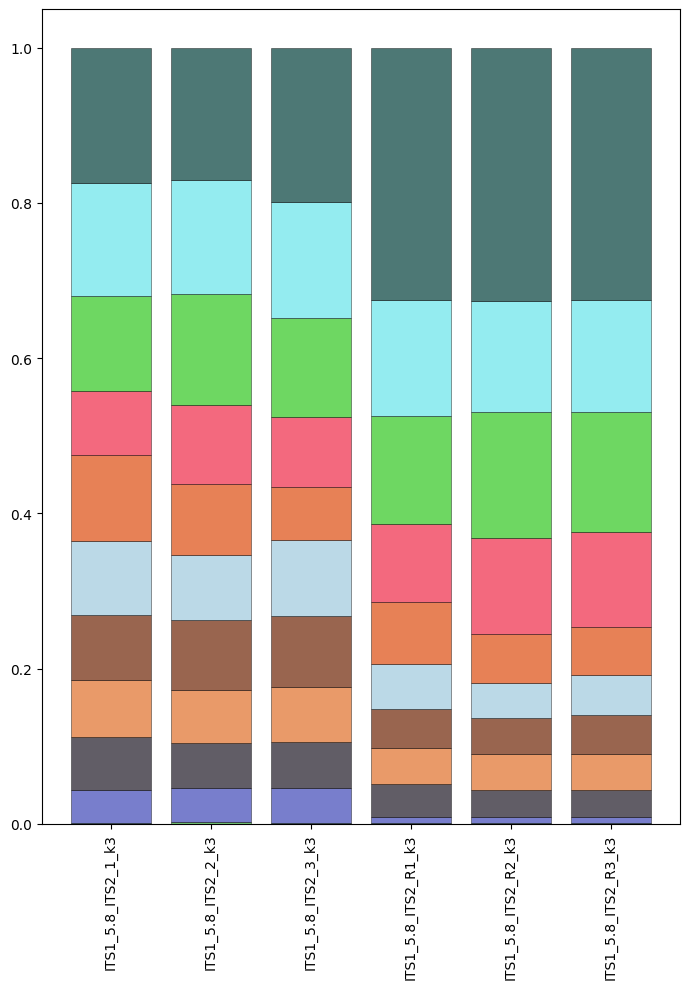

In [1047]:
plt.figure(figsize=(7, 10))
x_coord = 0
data_tax_df = retax_data

Color_collection = {}      
all_coords = []
width = 0.8
sample_coord = 0 
c = []
fst = True

for i in data_tax_df.index:
    
    Color_collection[i] = get_color(Color_collection)
    
for sample in data_tax_df.columns:
    print(sample)
    bottom = 0
    all_coords.append(sample_coord)
    
    for otu in data_tax_df.index:

        plt.bar(sample_coord, 
                      data_tax_df[sample][otu], 
                      width, 
                      bottom=bottom,
                      edgecolor='black',
                      alpha=.7,
                      linewidth=0.4, 
                      color=Color_collection[otu], label=otu)
            
        bottom += data_tax_df[sample][otu]
    fst = False
    sample_coord += 1

x_coord += 1
plt.xticks(all_coords, data_tax_df.columns, fontsize=10, rotation=90)
#plt.legend()
plt.tight_layout()
plt.show()

In [1018]:
a = a/a.sum(axis=0)
b = b/b.sum(axis=0)

a = a.rename(columns={i:f'{i}_k3' for i in a.columns})
b = b.rename(columns={i:f'{i}_k5' for i in b.columns})

z = pd.concat([a, b], axis=1).fillna(0)
z = z.assign(m=z.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(z.columns)]


ITS1_5.8_ITS2_1_k3
ITS1_5.8_ITS2_1_k5
ITS1_5.8_ITS2_2_k3
ITS1_5.8_ITS2_2_k5
ITS1_5.8_ITS2_3_k3
ITS1_5.8_ITS2_3_k5
ITS1_5.8_ITS2_R1_k3
ITS1_5.8_ITS2_R1_k5
ITS1_5.8_ITS2_R2_k3
ITS1_5.8_ITS2_R2_k5
ITS1_5.8_ITS2_R3_k3
ITS1_5.8_ITS2_R3_k5


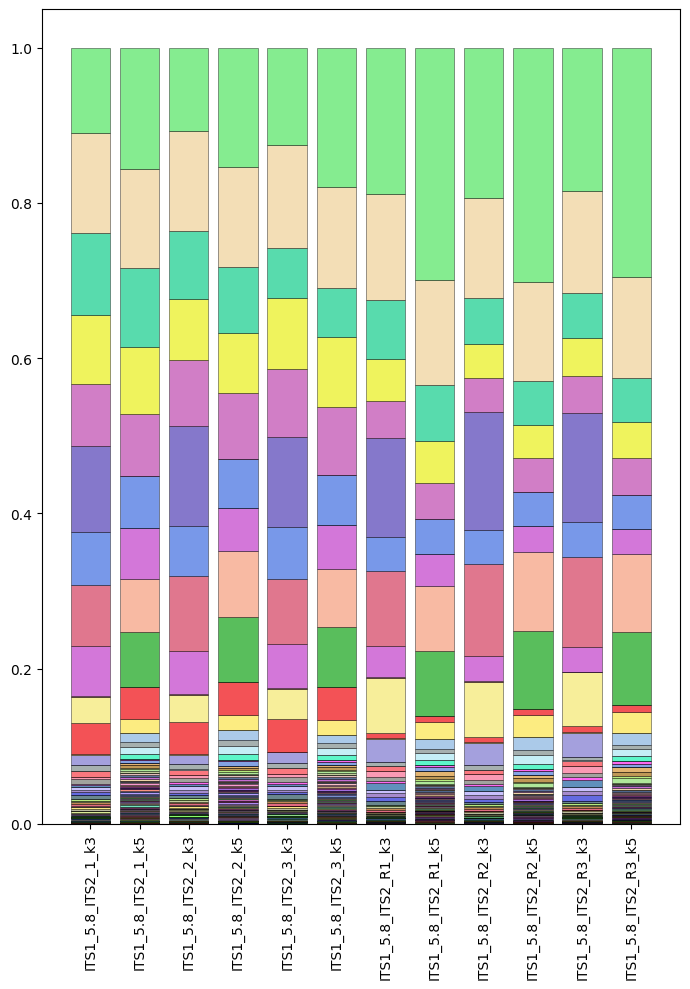

In [1020]:
plt.figure(figsize=(7, 10))
x_coord = 0
data_tax_df = z

Color_collection = {}      
all_coords = []
width = 0.8
sample_coord = 0 
c = []
fst = True

for i in data_tax_df.index:
    
    Color_collection[i] = get_color(Color_collection)
    
for sample in data_tax_df.columns:
    print(sample)
    bottom = 0
    all_coords.append(sample_coord)
    
    for otu in data_tax_df.index:

        plt.bar(sample_coord, 
                      data_tax_df[sample][otu], 
                      width, 
                      bottom=bottom,
                      edgecolor='black',
                      alpha=.7,
                      linewidth=0.4, 
                      color=Color_collection[otu])
            
        bottom += data_tax_df[sample][otu]
    fst = False
    sample_coord += 1

x_coord += 1
plt.xticks(all_coords, data_tax_df.columns, fontsize=10, rotation=90)

plt.tight_layout()
plt.show()

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

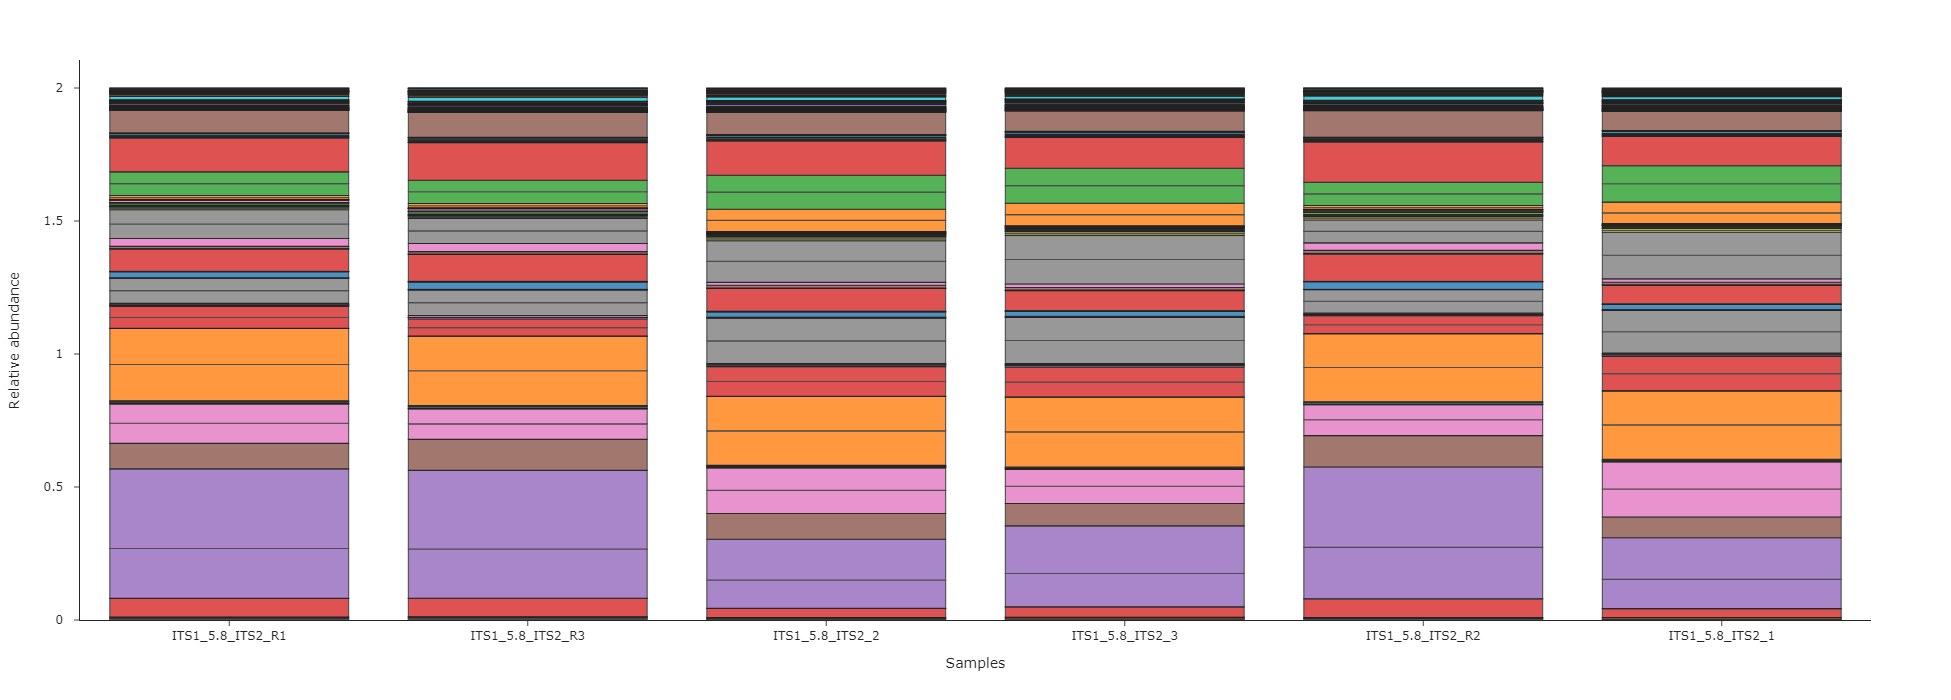

In [981]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(z.T, 
             y=z.index, 
             x=z.columns,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
fig. update_layout(showlegend=False)
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

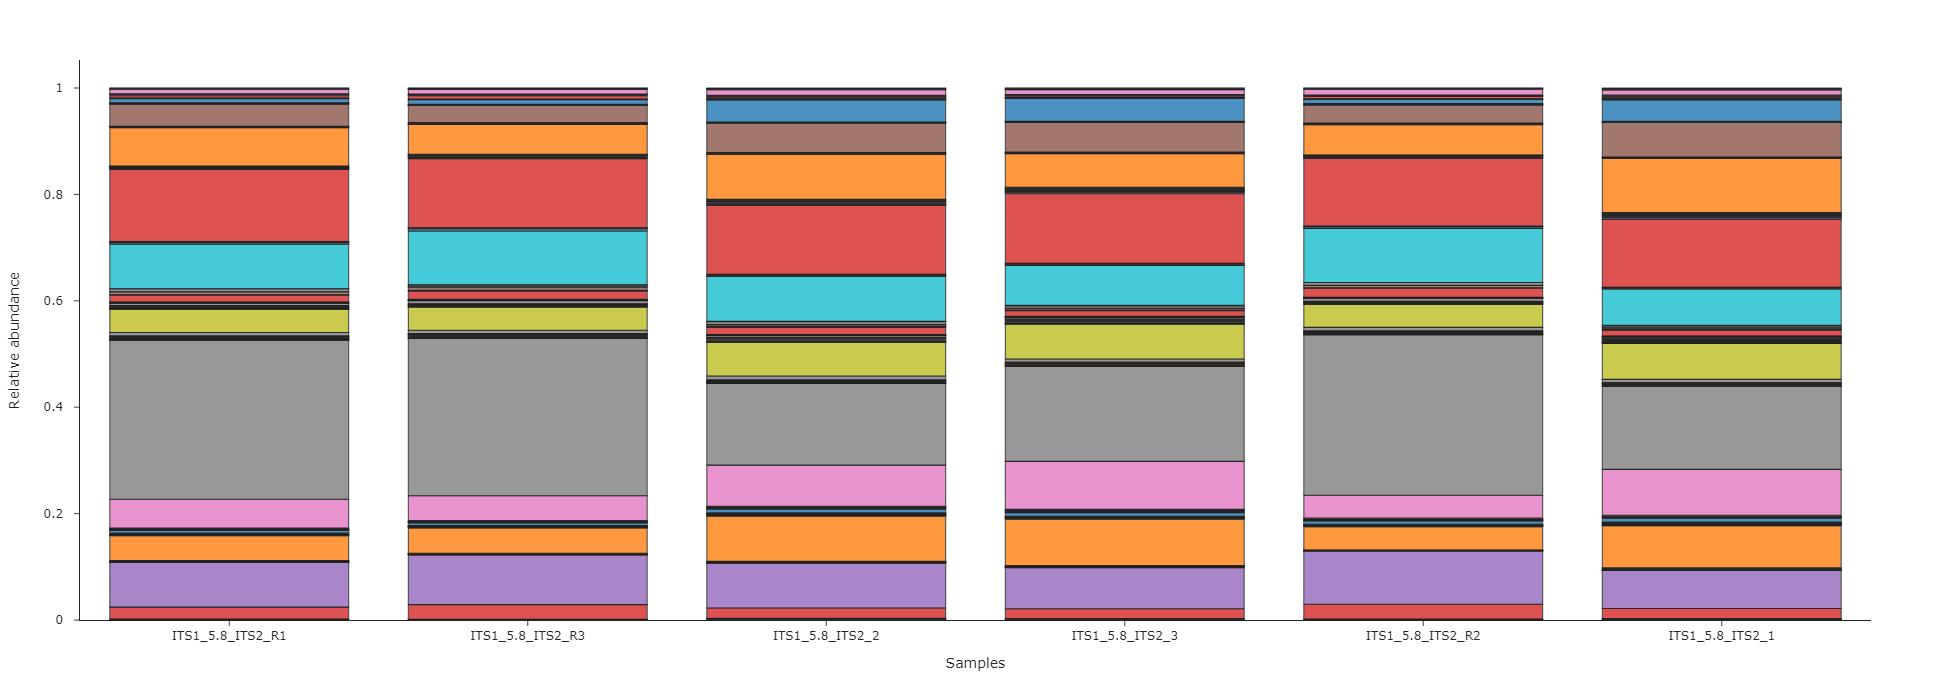

In [974]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(b.T, 
             y=b.index, 
             x=b.columns,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
fig. update_layout(showlegend=False)
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

In [811]:
all_samples_levels = {}

In [812]:
path = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/output/'
all_samps = {}

for samp in listdir(path):
    if 'work' in samp: continue
    samp = samp.split('.')[0]
    tax_tab = read_csv(f'{path}/{samp}.fastq/{samp}/rel_abundance_{samp}_S.csv', index_col=0)
    
    all_samps[samp] = tax_tab['rel_abundance'].to_dict()

all_samps = DataFrame(all_samps).fillna(0)
all_samps = all_samps.assign(m=all_samps.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(all_samps.columns)]


In [813]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(all_samps.T, 
             y=all_samps.index, 
             x=all_samps.columns,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

ValueError: 
    Invalid value of type 'builtins.str' received for the 'side' property of layout.legend.title
        Received value: 'top center'

    The 'side' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['top', 'left', 'top left']

In [814]:
path = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/output/'
all_samps = {}

for samp in listdir(path):
    if 'work' in samp: continue
    
    samp = samp.split('.')[0]
    all_samps[samp] = {}
    opn_nanoclust_tab = read_csv(f'{path}/{samp}.fastq/{samp}/{samp}.nanoclust_out.txt', sep=';', index_col=0)
     
    for i in listdir(f'{path}/{samp}.fastq/{samp}'):
        if 'cluster' not in i: continue
        
        cluster_id = int(i[7:])
        opn_fasta = parse(f'{path}/{samp}.fastq/{samp}/{i}/consensus_medaka.fasta/consensus.fasta', 'fasta')

        for line in opn_fasta:
            
            seq = str(line.seq)
            
            if seq not in all_samps[samp].keys():
                
                all_samps[samp][seq] = int(opn_nanoclust_tab.reads_in_cluster[0])
            
all_samps = DataFrame(all_samps).fillna(0)
            
            
            
            
    #tax_tab = read_csv(f'{path}/{samp}.fastq/{samp}/rel_abundance_{samp}_S.csv', index_col=0)
    #all_samps[samp] = tax_tab['rel_abundance'].to_dict()

#all_samps = DataFrame(all_samps).fillna(0)
#all_samps = all_samps.assign(m=all_samps.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(all_samps.columns)]


In [815]:
all_samps_norm

NameError: name 'all_samps_norm' is not defined

In [816]:
all_samps_norm = all_samps / all_samps.sum()


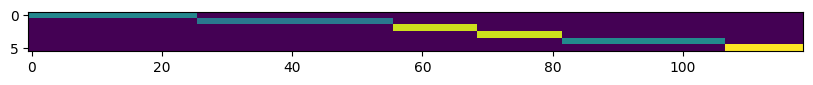

In [817]:
plt.figure(figsize=(10, 20))
plt.imshow(all_samps_norm.T)
plt.show()

In [818]:
all_samps_norm

V1_V9_R1  V1_V9_R3  \
ACGTATTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCA...  0.038462       0.0   
TTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACCTAG...  0.038462       0.0   
GTATTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACC...  0.038462       0.0   
TGTACTTCGTTCAGTTACGTATTGCTAAGGTTAAACCACTGCCATGT...  0.038462       0.0   
TAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACCTCGGTTA...  0.038462       0.0   
...                                                      ...       ...   
CCTCTCATTGTCCGTTCTCTACAGCACCTCGGTTACCTTGTTACGAC...  0.000000       0.0   
GTTCAGTTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCT...  0.000000       0.0   
TTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCTCTACAG...  0.000000       0.0   
CTTCGTTCAGTTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCG...  0.000000       0.0   
CGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCTCTACAGCAC...  0.000000       0.0   

                                                    V1_V9_2  V1_V9_1  \
ACGTATTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCA...      0.0      0.0   
TTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACCTAG...      0.0      0.0   
GTATTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACC...      0.0      0.0   
TGTACTTCGTTCAGTTACGTATTGCTAAGGTTAAACCACTGCCATGT...      0.0      0.0   
TAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACCTCGGTTA...      0.0      0.0   
...                                                     ...      ...   
CCTCTCATTGTCCGTTCTCTACAGCACCTCGGTTACCTTGTTACGAC...      0.0      0.0   
GTTCAGTTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCT...      0.0      0.0   
TTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCTCTACAG...      0.0      0.0   
CTTCGTTCAGTTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCG...      0.0      0.0   
CGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCTCTACAGCAC...      0.0      0.0   

                                                    V1_V9_R2   V1_V9_3  
ACGTATTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCA...       0.0  0.000000  
TTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACCTAG...       0.0  0.000000  
GTATTGCTAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACC...       0.0  0.000000  
TGTACTTCGTTCAGTTACGTATTGCTAAGGTTAAACCACTGCCATGT...       0.0  0.000000  
TAAGGTTAAACCACTGCCATGTATCAAAGTACGCAGCACCTCGGTTA...       0.0  0.000000  
...                                                      ...       ...  
CCTCTCATTGTCCGTTCTCTACAGCACCTCGGTTACCTTGTTACGAC...       0.0  0.083333  
GTTCAGTTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCT...       0.0  0.083333  
TTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCTCTACAG...       0.0  0.083333  
CTTCGTTCAGTTACGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCG...       0.0  0.083333  
CGTATTGCTAAGGTTAAGAGCCTCTCATTGTCCGTTCTCTACAGCAC...       0.0  0.083333  

[119 rows x 6 columns]

In [819]:
import random
def get_color(obj_dict):
    
    color = ''
    
    while color not in obj_dict.values() and color == '':
        
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    
    return color

In [820]:
Color_collection = {}

for idx in all_samps_norm.index:
    
    Color_collection[idx] = get_color(Color_collection)

In [821]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(all_samps_norm.T, 
             y=all_samps_norm.index, 
             x=all_samps_norm.columns,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',
             color_discrete_map=Color_collection)
fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.update_layout(showlegend=False)
#fig.update_xaxes(range=[-1, len(otu_tab_viz.T)+0.2], autorangeoptions_clipmax=len(data_tax_df.T))

#fig.update_layout(showlegend=False)

#fig.write_image(f"VIZ/V1_V9_pool_{taxonomy_level}.pdf")
#fig.write_image(f"VIZ/V1_V9_pool_{taxonomy_level}.png", scale=3)
fig.show()

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

ValueError: 
    Invalid value of type 'builtins.str' received for the 'side' property of layout.legend.title
        Received value: 'top center'

    The 'side' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['top', 'left', 'top left']

In [860]:
path = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/output/'
all_samps = {}

for samp in listdir(path):
    if 'work' in samp: continue
    
    samp = samp.split('.')[0]
    all_samps[samp] = {}
    opn_nanoclust_tab = read_csv(f'{path}/{samp}.fastq/{samp}/{samp}.nanoclust_out.txt', sep=';', index_col=0)
     
    for i in listdir(f'{path}/{samp}.fastq/{samp}'):
        if 'cluster' not in i: continue
        
        cluster_id = int(i[7:])
        opn_fasta = parse(f'{path}/{samp}.fastq/{samp}/{i}/consensus_medaka.fasta/consensus.fasta', 'fasta')

        for line in opn_fasta:
            
            seq = str(line.seq)
            
            if seq not in all_samps[samp].keys():
                
                all_samps[samp][seq] = int(opn_nanoclust_tab.reads_in_cluster[0])
            
all_samps = DataFrame(all_samps).fillna(0)
all_samps = all_samps/ all_samps.sum()
all_samples_levels['OTU'] = all_samps

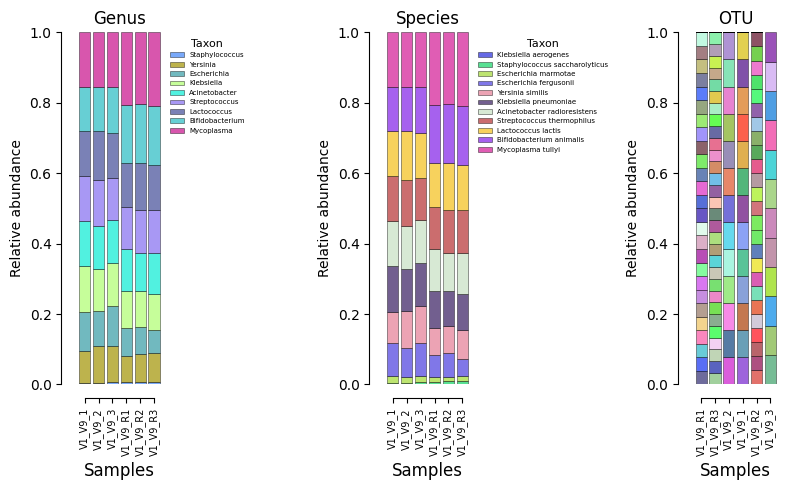

In [861]:
fig, axs = plt.subplots(1, 3, figsize=(8, 5))
x_coord = 0
for taxlevel in all_samples_levels.keys():
    
    data_tax_df = all_samples_levels[taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[x_coord].set_xlabel('Samples', fontsize=12)
    axs[x_coord].set_title(taxlevel, fontsize=12)
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[x_coord])
    axs[x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1

plt.tight_layout()
plt.savefig('VIZ/NANOCLUST_BACTER.pdf')
plt.savefig('VIZ/NANOCLUST_BACTER.png', dpi=800)
plt.show()

In [1346]:
otu_tab = read_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_res.tsv', sep='\t', index_col=0)
tax_tab = read_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_taxtab.tsv/tax_table.tsv', sep='\t', index_col=0)
ll_samples_levels_fung = {}

for taxlevel  in ['Genus', 'Species']:
    
    all_samps = {}
    
    for i in otu_tab.columns:
        try:
            if tax_tab[taxlevel][i] not in all_samps.keys():
                
                all_samps[tax_tab[taxlevel][i]] = {samp : 0 for samp in otu_tab.index}
            
            for samp in otu_tab.index:
                
                all_samps[tax_tab[taxlevel][i]][samp] += otu_tab[i][samp]
        except:
            #print(i)
            continue
    
    all_samps = DataFrame(all_samps)
    all_samps = (all_samps.T / all_samps.sum(axis=1)).T
    all_samps = all_samps.loc[np.sort(all_samps.index)].T
    all_samples_levels_fung[taxlevel] = all_samps
all_samples_levels_fung['OTU'] = (otu_tab.T / otu_tab.sum(axis=1))

In [831]:
all_samples_levels_fung['OTU'] = (otu_tab.T / otu_tab.sum(axis=1))

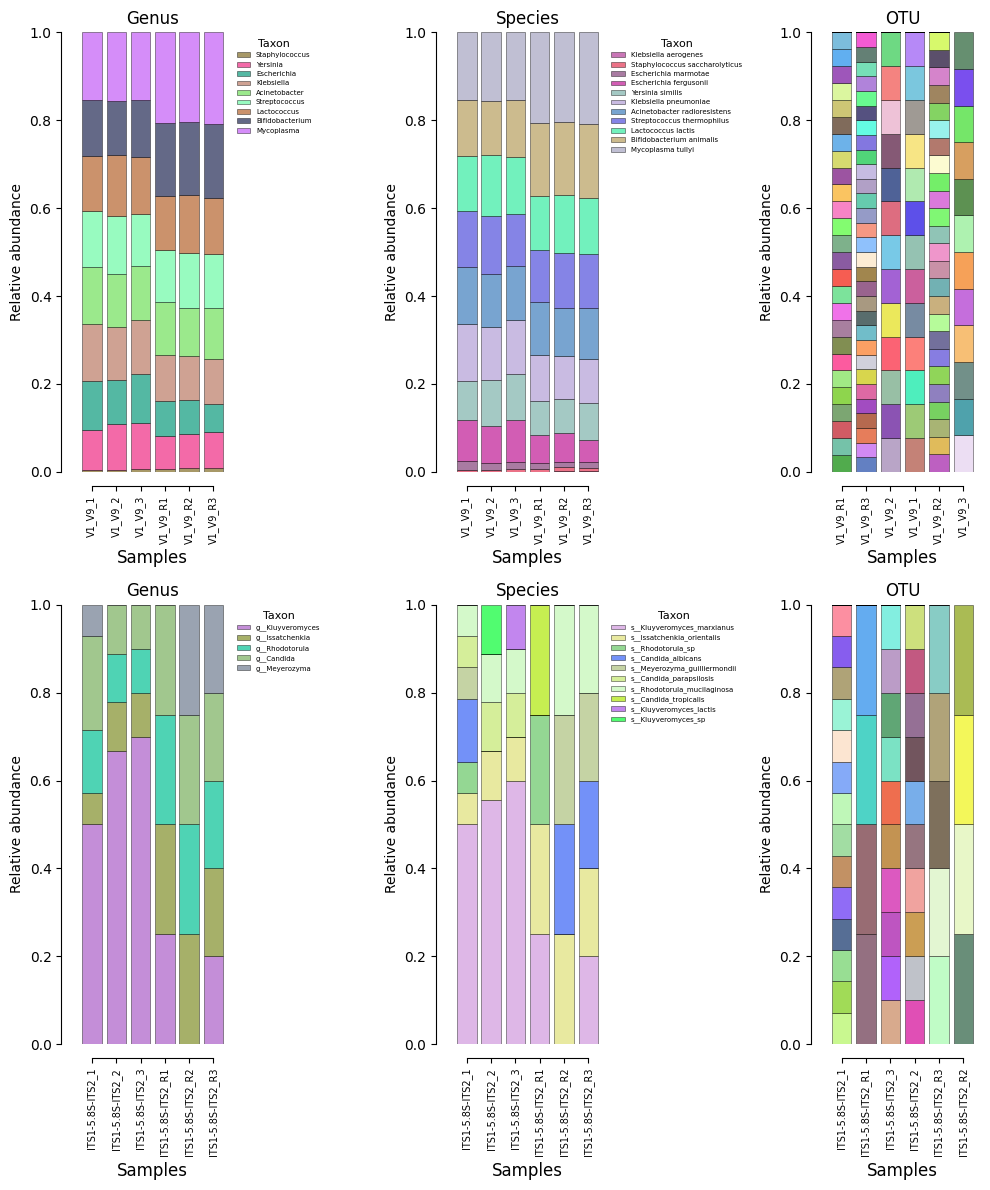

In [842]:
fig, axs = plt.subplots(2, 3, figsize=(10, 12))

x_coord = 0
y_coord = 0
for taxlevel in all_samples_levels.keys():
    
    data_tax_df = all_samples_levels[taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[y_coord][x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[y_coord][x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[y_coord][x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[y_coord][x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[y_coord][x_coord].set_xlabel('Samples', fontsize=12)
    axs[y_coord][x_coord].set_title(taxlevel, fontsize=12)
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[y_coord][x_coord])
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1



x_coord = 0
y_coord += 1

for taxlevel in all_samples_levels_fung.keys():
    
    data_tax_df = all_samples_levels_fung[taxlevel]

    Color_collection = {}      
    all_coords = []
    width = 0.8
    sample_coord = 0 
    c = []
    fst = True
    
    for i in data_tax_df.index:
        
        Color_collection[i] = get_color(Color_collection)
        
    for sample in data_tax_df.columns:
        
        bottom = 0
        all_coords.append(sample_coord)
        
        for otu in data_tax_df.index:
            if fst == True:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              label=otu, 
                              bottom=bottom,
                              edgecolor='black',
                              linewidth=0.4, 
                              alpha=.7,
                              color=Color_collection[otu])
            else:
                axs[y_coord][x_coord].bar(sample_coord, 
                              data_tax_df[sample][otu], 
                              width, 
                              bottom=bottom,
                              edgecolor='black',
                              alpha=.7,
                              linewidth=0.4, 
                              color=Color_collection[otu])
                
            bottom += data_tax_df[sample][otu]
        fst = False
        sample_coord += 1
    axs[y_coord][x_coord].set_ylim(0, 1.0)
    if taxlevel != 'OTU':
        axs[y_coord][x_coord].legend(fontsize=5, bbox_to_anchor=(1, 1), title='Taxon', title_fontsize=8, frameon=False)
    axs[y_coord][x_coord].set_xticks(all_coords, data_tax_df.columns, fontsize=5)
    axs[y_coord][x_coord].set_ylabel('Relative abundance', fontsize=10)
    axs[y_coord][x_coord].set_xlabel('Samples', fontsize=12)
    axs[y_coord][x_coord].set_title(taxlevel, fontsize=12)
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90)
    sns.despine(offset=10, trim=True, ax=axs[y_coord][x_coord])
    axs[y_coord][x_coord].set_xticklabels(data_tax_df.columns, rotation=90, fontsize=7)

    x_coord += 1

plt.tight_layout()
plt.savefig('VIZ/NANOCLUST_FUNGI.pdf')
plt.savefig('VIZ/NANOCLUST_FUNGI.png', dpi=800)
plt.show()

In [833]:
for i in range(10):
    try: 1+'1'
    except: i
    
    else: 
        print(i)

In [857]:
wf_meta_all = {}

for samp in listdir('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/output/minimap2/16s//'):
    if 'fastq' not in samp: continue

    if 'work' in samp:continue
    wf_meta = read_csv(f'/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/output/minimap2/16s/{samp}/abundance_table_species.tsv', sep='\t', index_col=0)
    wf_meta_all[samp[:-6]] = wf_meta[samp.split('.')[0]].to_dict()
wf_meta_all = DataFrame(wf_meta_all).fillna(0)

V1_V9_R1.fastq


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/output/minimap2/16s/V1_V9_R1.fastq/abundance_table_species.tsv'

In [ ]:
wf_meta_all = {}

for samp in listdir('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/output/kraken2///'):
    if 'work' in samp:continue
    if 'store_dir' in samp:continue
    wf_meta = read_csv(f'/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/wf-meta/output/kraken2//{samp}/abundance_table_species.tsv', sep='\t', index_col=0)
    wf_meta_all[samp[:-6]] = wf_meta[samp.split('.')[0]].to_dict()
wf_meta_all = DataFrame(wf_meta_all).fillna(0)


In [ ]:
wf_meta_all_sp = {}

for tax in wf_meta_all.index:
    if 'Fungi' not in tax.split(';'):continue
    wf_meta_all_sp[tax.split(';')[-1]] = wf_meta_all.loc[tax].to_dict()
wf_meta_all_sp = DataFrame(wf_meta_all_sp).T
#wf_meta_all_sp = wf_meta_all_sp.drop('Unknown', axis=0)
wf_meta_all_sp = wf_meta_all_sp / wf_meta_all_sp.sum(axis=0)
wf_meta_all_sp = wf_meta_all_sp[np.sort(wf_meta_all_sp.columns)]
wf_meta_all_sp = wf_meta_all_sp.assign(m=wf_meta_all_sp.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(wf_meta_all_sp.columns)]

  0%|                                                                                | 0/2 [00:00<?, ?it/s]


KeyError: 0

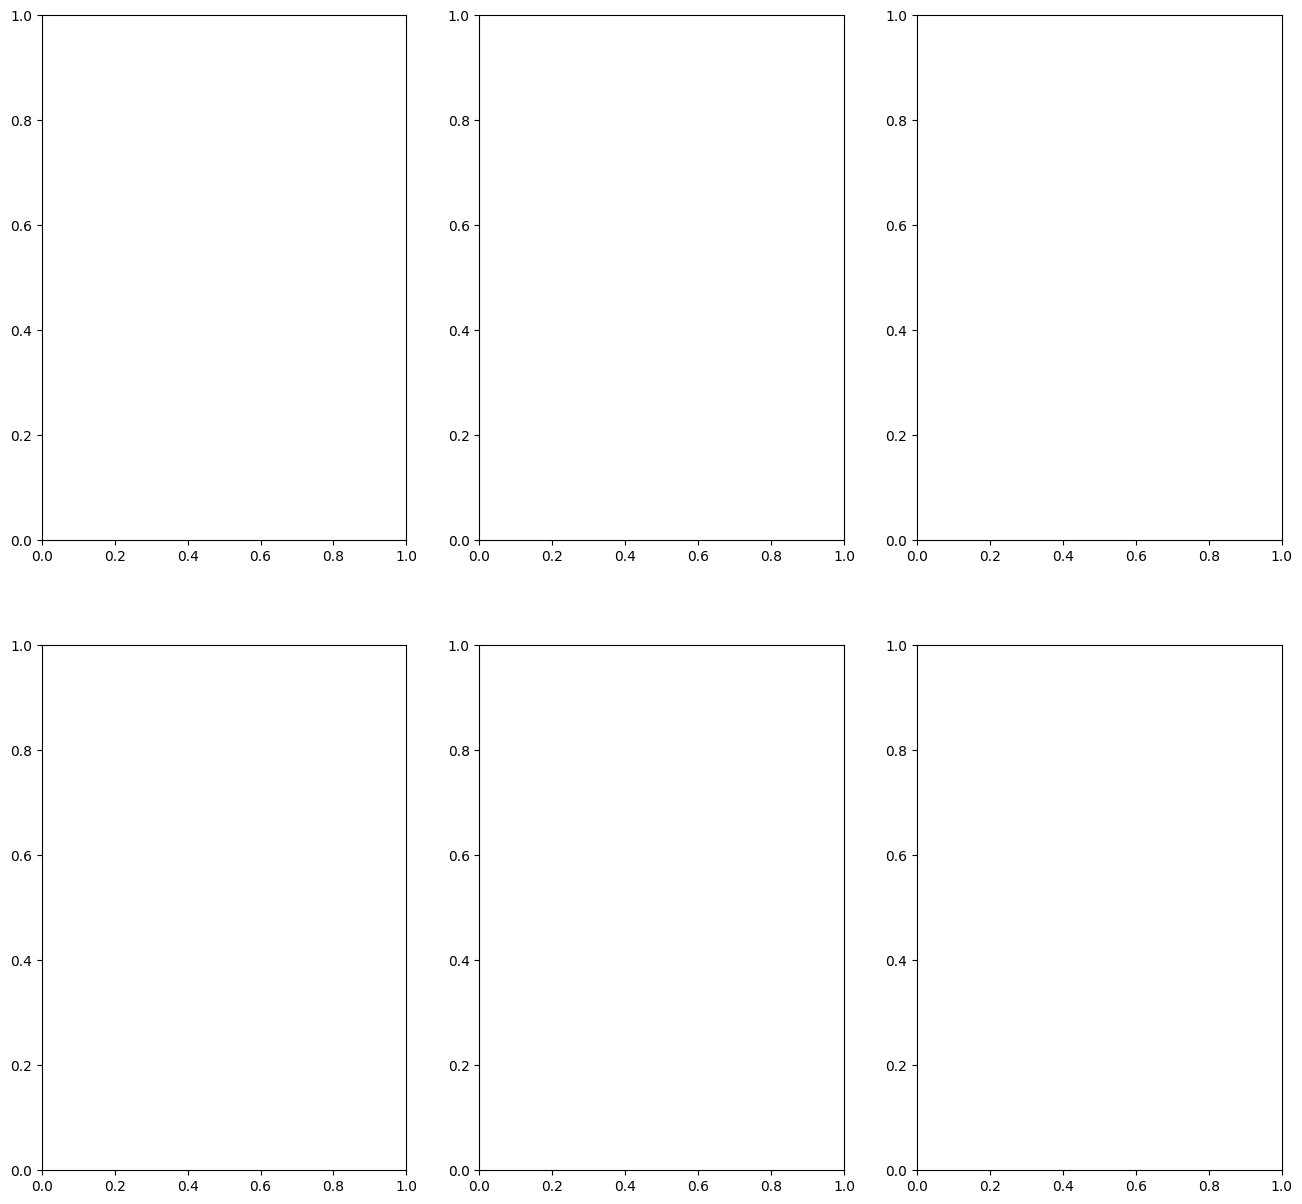

In [835]:
fig, axs = plt.subplots(2, 3, figsize=(16, 15))
subplots_coord_y = 0
subplots_coord_x = 0

for at in tqdm(full_data.keys()):
    for taxlevel in full_data[at].keys():
        
        data_tax_df = full_data[at][taxlevel][0]
        
        if '16S' in at:
            subplots_coord_y = 0
        else: 
            subplots_coord_y = 1
            data_tax_df = data_tax_df[['ITS1_1', 'ITS1_2', 'ITS1_3', 'ITS1_R1', 'ITS1_R2', 'ITS1_R3', 'ITS2_1', 'ITS2_2', 'ITS2_3', 'ITS2_R1', 'ITS2_R2', 'ITS2_R3', 'ITS1_5.8_ITS2_1', 'ITS1_5.8_ITS2_2', 'ITS1_5.8_ITS2_3', 'ITS1_5.8_ITS2_R1', 'ITS1_5.8_ITS2_R2', 'ITS1_5.8_ITS2_R3']]
            
        if 'Genus' in taxlevel:
            subplots_coord_x = 0
        if 'Species' in taxlevel:
            subplots_coord_x = 1            
        if 'OTU' in taxlevel:
            subplots_coord_x = 2
            
        all_coords = []
        width = 0.8
        sample_coord = 0 
        c = []
        fst = True
        
        Color_collection = {}
        
        
        for i in data_tax_df.index:
            
            Color_collection[i] = get_color(Color_collection)
            
        for sample in data_tax_df.columns:
            
            bottom = 0
            all_coords.append(sample_coord)
            
            for otu in data_tax_df.index:
                if fst == True:
                    axs[subplots_coord_y][subplots_coord_x].bar(sample_coord, 
                                  data_tax_df[sample][otu], 
                                  width, 
                                  label=otu, 
                                  bottom=bottom,
                                  edgecolor='black',
                                  linewidth=0.4, 
                                  alpha=.7,
                                  color=Color_collection[otu])
                else:
                    axs[subplots_coord_y][subplots_coord_x].bar(sample_coord, 
                                  data_tax_df[sample][otu], 
                                  width, 
                                  bottom=bottom,
                                  edgecolor='black',
                                  alpha=.7,
                                  linewidth=0.4, 
                                  color=Color_collection[otu])
                    
                bottom += data_tax_df[sample][otu]
            fst = False
            sample_coord += 1
        axs[subplots_coord_y][subplots_coord_x].set_ylim(0, 1.1)
       # if 'ITS' in at: axs[subplots_coord_y][subplots_coord_x].set_xlim(-0.8, sample_coord + 2)
     #   else: axs[subplots_coord_y][subplots_coord_x].set_xlim(-0.8, sample_coord + 0.8)
    
        if taxlevel != 'OTU':
            
            legend=axs[subplots_coord_y][subplots_coord_x].legend(fontsize=5, bbox_to_anchor=(1, .95), title='Taxon', title_fontsize=8)
            #legend.get_title().set_fontsize('8')
        axs[subplots_coord_y][subplots_coord_x].set_xticks(all_coords, data_tax_df.columns, fontsize=7)
        axs[subplots_coord_y][subplots_coord_x].set_ylabel('Relative abundance', fontsize=12)
        axs[subplots_coord_y][subplots_coord_x].set_xlabel('Samples', fontsize=12)
        
        axs[subplots_coord_y][subplots_coord_x].set_title(taxlevel, fontsize=18)
        sns.despine(offset=10, trim=True, ax=axs[subplots_coord_y][subplots_coord_x])
        
        axs[subplots_coord_y][subplots_coord_x].set_xticklabels(data_tax_df.columns, rotation=90)

for idxx in range(len(full_data[at].keys())):
    
    axs[0][idxx].text(2, 1.05, 'V1-V9', fontsize=8)
    axs[0][idxx].plot([0, 5], [1.025, 1.025], linewidth=1, color='black')
    axs[0][idxx].text(2+6, 1.05, 'V3-V4', fontsize=8)
    axs[0][idxx].plot([6, 11], [1.025, 1.025], linewidth=1, color='black')


    axs[1][idxx].text(2, 1.05, 'ITS1', fontsize=8)
    axs[1][idxx].plot([0, 5], [1.025, 1.025], linewidth=1, color='black')
    axs[1][idxx].text(2+6, 1.05, 'ITS2', fontsize=8)
    axs[1][idxx].plot([6, 11], [1.025, 1.025], linewidth=1, color='black')

    axs[1][idxx].text(1.5+6+4, 1.05, 'ITS1-5.8S-ITS2', fontsize=8)
    axs[1][idxx].plot([12, 17], [1.025, 1.025], linewidth=1, color='black')

axs[0][0].text(-8, 0.15, 'Bacterial mock community', fontsize=20, rotation=90)
axs[1][0].text(-12, 0.17, 'Fungal mock community', fontsize=20, rotation=90)

plt.tight_layout()
#plt.savefig('VIZ/PIKE_fig2.pdf')
#plt.savefig('VIZ/PIKE_fig2.png', dpi=800)
plt.show()

In [537]:
at_meat = {}
q_mean = {}

for at in listdir('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/GUPPI_BARCODE/'):
    
    at_meat[at] = 0
    q_mean[at] = [] 
    
    for sample in listdir(f"/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/GUPPI_BARCODE/{at}/{at.split('GUPPI_BARCODE_')[1]}_trimmed"):
        for line in parse(f"/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/GUPPI_BARCODE/{at}/{at.split('GUPPI_BARCODE_')[1]}_trimmed/{sample}", 'fastq'):
            quallist = np.array(list(map(ord,list(line.format('fastq').split('\n')[-2]))))-33
            q_mean[at] = np.mean(quallist)
            
            at_meat[at] += 1
    at_meat[at] = at_meat[at]/6
    q_mean[at] = q_mean[at]/6

In [538]:
q_mean

{'GUPPI_BARCODE_V3_V4': 3.3681818181818186,
 'GUPPI_BARCODE_ITS1_5.8_ITS2': 4.127282211789254,
 'GUPPI_BARCODE_ITS2': 3.3055555555555554,
 'GUPPI_BARCODE_V1_V9': 3.974798387096774,
 'GUPPI_BARCODE_ITS1': 2.2440225035161743}

In [1344]:
path = '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/output_its/'
all_samps = {}

for samp in listdir(path):
    if 'work' in samp: continue
    
    samp = samp[:-6]
    all_samps[samp] = {}
    opn_nanoclust_tab = read_csv(f'{path}/{samp}.fastq/{samp}/{samp}.nanoclust_out.txt', sep=';', index_col=0)
     
    for i in listdir(f'{path}/{samp}.fastq/{samp}'):
        if 'cluster' not in i: continue
        
        cluster_id = int(i[7:])
        opn_fasta = parse(f'{path}/{samp}.fastq/{samp}/{i}/consensus_medaka.fasta/consensus.fasta', 'fasta')

        for line in opn_fasta:
            
            seq = str(line.seq)
            
            if seq not in all_samps[samp].keys():
                
                all_samps[samp][seq] = int(opn_nanoclust_tab.reads_in_cluster[cluster_id])
            
all_samps = DataFrame(all_samps).fillna(0)

In [1345]:
all_samps.T.to_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_res.tsv', sep='\t')


In [368]:
otu_tab = read_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_res.tsv', sep='\t', index_col=0)
tax_tab = read_csv('/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_taxtab.tsv', sep='\t', index_col=0)
rel_tab = {}
otu_count = 0

for col in otu_tab.columns:
    try:
        
        rel_tab[f"OTU{otu_count}_{tax_tab['Species'][col]}"] = otu_tab[col].to_dict()
        otu_count += 1
        
    except: continue
rel_tab = DataFrame(rel_tab)
rel_tab = rel_tab.T/rel_tab.sum(axis=1)

IsADirectoryError: [Errno 21] Is a directory: '/mnt/iscsidisk1/runs/runs-krivonos/PROJECTS/NANOPORE_PROJECT/NanoCLUST_validation/ITS_full_taxtab.tsv'

In [582]:
read_csv('ITS_12_data_tax_df_species_orig.csv', index_col=0, sep='\t')

ITS1_5.8_ITS2_1_100000_reads  \
s__Candida_dubliniensis                           0.000000   
s__Rhodotorula_dairenensis                        0.000000   
s__Candida_intermedia                             0.000000   
s__Candida_africana                               0.000000   
s__Meyerozyma_carpophila                          0.000000   
s__Candida_sp                                     0.002593   
s__Meyerozyma_caribbica                           0.000000   
s__Candida_orthopsilosis                          0.000000   
s__Yarrowia_deformans                             0.000000   
s__Fungi_sp                                       0.000000   
s__Candida_auris                                  0.000000   
s__Pichia_sp                                      0.000000   
s__Meyerozyma_sp                                  0.001662   
s__Debaryomyces_hansenii                          0.003186   
s__Aureobasidium_pullulans                        0.000000   
s__Rhodotorula_sp                                 0.001326   
s__Kluyveromyces_marxianus                        0.044093   
s__Meyerozyma_guilliermondii                      0.070532   
s__Rhodotorula_mucilaginosa                       0.072472   
s__Candida_tropicalis                             0.092321   
s__Candida_parapsilosis                           0.096933   
s__Candida_albicans                               0.113418   
s__Issatchenkia_orientalis                        0.086780   
s__Clavispora_lusitaniae                          0.112646   
s__Clavispora_sp                                  0.136196   
s__Yarrowia_lipolytica                            0.165842   

                              ITS1_5.8_ITS2_1_10000_reads  \
s__Candida_dubliniensis                          0.000000   
s__Rhodotorula_dairenensis                       0.000000   
s__Candida_intermedia                            0.000000   
s__Candida_africana                              0.000000   
s__Meyerozyma_carpophila                         0.000000   
s__Candida_sp                                    0.000000   
s__Meyerozyma_caribbica                          0.000000   
s__Candida_orthopsilosis                         0.000000   
s__Yarrowia_deformans                            0.000000   
s__Fungi_sp                                      0.000000   
s__Candida_auris                                 0.000000   
s__Pichia_sp                                     0.000000   
s__Meyerozyma_sp                                 0.000000   
s__Debaryomyces_hansenii                         0.000000   
s__Aureobasidium_pullulans                       0.000000   
s__Rhodotorula_sp                                0.000000   
s__Kluyveromyces_marxianus                       0.044304   
s__Meyerozyma_guilliermondii                     0.070158   
s__Rhodotorula_mucilaginosa                      0.074135   
s__Candida_tropicalis                            0.084079   
s__Candida_parapsilosis                          0.100431   
s__Candida_albicans                              0.103524   
s__Issatchenkia_orientalis                       0.081759   
s__Clavispora_lusitaniae                         0.116893   
s__Clavispora_sp                                 0.135344   
s__Yarrowia_lipolytica                           0.189371   

                              ITS1_5.8_ITS2_1_1000_reads  \
s__Candida_dubliniensis                         0.000000   
s__Rhodotorula_dairenensis                      0.000000   
s__Candida_intermedia                           0.000000   
s__Candida_africana                             0.000000   
s__Meyerozyma_carpophila                        0.000000   
s__Candida_sp                                   0.000000   
s__Meyerozyma_caribbica                         0.000000   
s__Candida_orthopsilosis                        0.000000   
s__Yarrowia_deformans                           0.000000   
s__Fungi_sp                                     0.000000   
s__Candida_auris                               

In [649]:
its_tab = read_csv('ITS_12_data_tax_df_species_orig.csv', index_col=0, sep='\t')
lims = {}
limrange = []
otu_count = {}

for i in its_tab.columns:
    
    lim = int(i.split('_')[-2])
    sample = ('_'.join(i.split('_')[:2]))
    limrange.append(lim)
  #  print(lim)
    if lim > 40000:continue
    if sample not in lims:
        lims[sample] = {}
        otu_count[sample] = {}
        
    lims[sample][lim] = its_tab[i]
    otu_count[sample][lim] = len(its_tab[its_tab[i]!= 0])
    #otu_count[sample][lim] = its_tab[its_tab[i]!= 0].index
    
    
for samp in lims.keys():
    lims[samp] = DataFrame(lims[samp])[np.sort(DataFrame(lims[samp]).columns)]

In [655]:
lims['ITS1_5.8']

50     100       150       200       250    \
s__Candida_dubliniensis         0.0    0.0  0.000000  0.000000  0.000000   
s__Rhodotorula_dairenensis      0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_intermedia           0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_africana             0.0    0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_carpophila        0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_sp                   0.0    0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_caribbica         0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_orthopsilosis        0.0    0.0  0.000000  0.000000  0.000000   
s__Yarrowia_deformans           0.0    0.0  0.000000  0.000000  0.000000   
s__Fungi_sp                     0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_auris                0.0    0.0  0.000000  0.000000  0.000000   
s__Pichia_sp                    0.0    0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_sp                0.0    0.0  0.000000  0.000000  0.000000   
s__Debaryomyces_hansenii        0.0    0.0  0.000000  0.000000  0.000000   
s__Aureobasidium_pullulans      0.0    0.0  0.000000  0.000000  0.000000   
s__Rhodotorula_sp               0.0    0.0  0.000000  0.000000  0.000000   
s__Kluyveromyces_marxianus      0.0    0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_guilliermondii    0.0    0.0  0.000000  0.000000  0.000000   
s__Rhodotorula_mucilaginosa     0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_tropicalis           0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_parapsilosis         0.0    0.0  0.000000  0.000000  0.000000   
s__Candida_albicans             0.0    0.0  0.000000  0.000000  0.000000   
s__Issatchenkia_orientalis      0.0    0.0  0.000000  0.000000  0.179348   
s__Clavispora_lusitaniae        0.0    0.0  0.000000  0.000000  0.152174   
s__Clavispora_sp                0.0    0.0  0.282051  0.264706  0.179348   
s__Yarrowia_lipolytica          1.0    1.0  0.717949  0.735294  0.489130   

                                 300       500       1000      3000   \
s__Candida_dubliniensis       0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_dairenensis    0.000000  0.000000  0.000000  0.000000   
s__Candida_intermedia         0.000000  0.000000  0.000000  0.000000   
s__Candida_africana           0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_carpophila      0.000000  0.000000  0.000000  0.000000   
s__Candida_sp                 0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_caribbica       0.000000  0.000000  0.000000  0.000000   
s__Candida_orthopsilosis      0.000000  0.000000  0.000000  0.000000   
s__Yarrowia_deformans         0.000000  0.000000  0.000000  0.000000   
s__Fungi_sp                   0.000000  0.000000  0.000000  0.000000   
s__Candida_auris              0.000000  0.000000  0.000000  0.000000   
s__Pichia_sp                  0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_sp              0.000000  0.000000  0.000000  0.000000   
s__Debaryomyces_hansenii      0.000000  0.000000  0.000000  0.000000   
s__Aureobasidium_pullulans    0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_sp             0.000000  0.000000  0.000000  0.056300   
s__Kluyveromyces_marxianus    0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_guilliermondii  0.000000  0.000000  0.046563  0.045576   
s__Rhodotorula_mucilaginosa   0.000000  0.000000  0.045455  0.000000   
s__Candida_tropicalis         0.000000  0.058524  0.056541  0.058981   
s__Candida_parapsilosis       0.000000  0.000000  0.066519  0.061662   
s__Candida_albicans           0.000000  0.000000  0.055432  0.064726   
s__Issatchenkia_orientalis    0.210526  0.183206  0.145233  0.130984   
s__Clavispora_lusitaniae      0.000000  0.129771  0.151885  0.140942   
s__Clavispora_sp              0.236842  0.185751  0.162971  0.121792   
s__Yarrowia_lipolytica        0.552632  0.442748  0.269401  0.319035   

                                

In [652]:
otu_count = DataFrame(otu_count).fillna(0)
otu_count = otu_count.T[np.sort(otu_count.index)]

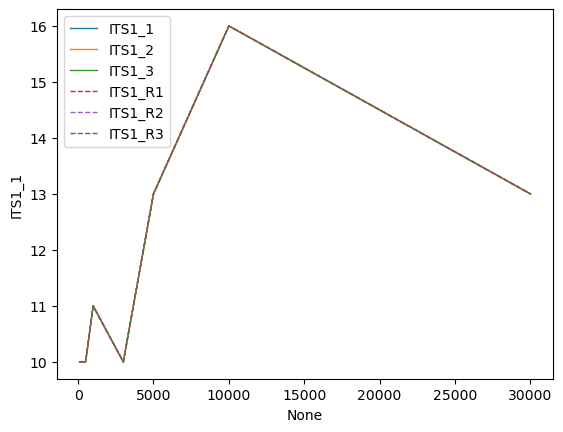

In [599]:
for sp in otu_count.index:
    if 'R' in sp:
        sns.lineplot(x=otu_count.columns, y=otu_count.loc[sp], label=sp, linewidth=1, linestyle='dashed')
        continue
    sns.lineplot(x=otu_count.columns, y=otu_count.loc[sp], label=sp, linewidth=1)
    
#plt.xscale('log')
plt.show()

In [594]:
otu_count

100    150    200    250    300    500    1000   3000   5000   10000  \
ITS1_1      10     11     12     13     12     13     13     24     43     51   
ITS1_2      10     11     12     13     12     13     13     24     43     51   
ITS1_3      10     11     12     13     12     13     13     24     44     51   
ITS1_R1     10     11     12     13     12     13     13     24     44     51   
ITS1_R2     10     11     12     13     12     13     13     23     43     51   
ITS1_R3     10     11     12     13     12     13     13     24     43     51   

         30000  
ITS1_1      38  
ITS1_2      38  
ITS1_3      38  
ITS1_R1     38  
ITS1_R2     38  
ITS1_R3     38

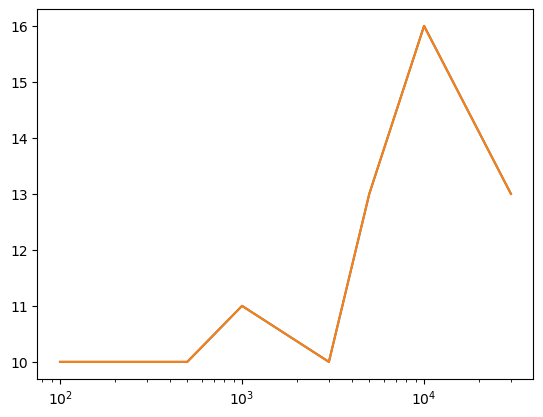

In [601]:
plt.plot(np.mean(otu_count.loc[otu_count.index[otu_count.index.str.contains('R')]], axis=0))
plt.plot(np.mean(otu_count.loc[otu_count.index[1-otu_count.index.str.contains('R')]], axis=0))
plt.xscale('log')

In [306]:
af = []
apf = []

for samp in lims.keys():
    if 'R' not in samp:
        af.append(samp)
    else:
        apf.append(samp)

In [307]:
new_dict_af = []
new_aplf = []

for samp in af:
    
    new_dict_af.append(lims[samp])
new_dict_af = sum(new_dict_af)/3
new_dict_af = new_dict_af.fillna(0)

for samp in apf:
    
    new_aplf.append(lims[samp])
new_aplf = sum(new_aplf)/3
new_aplf = new_aplf.fillna(0)

In [308]:
new_dict_af

100     150       200       250       300     \
s__Candida_dubliniensis          0.0     0.0  0.000000  0.000000  0.000000   
s__Rhodotorula_dairenensis       0.0     0.0  0.000000  0.000000  0.000000   
s__Candida_intermedia            0.0     0.0  0.000000  0.000000  0.000000   
s__Candida_africana              0.0     0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_carpophila         0.0     0.0  0.000000  0.000000  0.000000   
s__Candida_sp                    0.0     0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_caribbica          0.0     0.0  0.000000  0.000000  0.000000   
s__Candida_orthopsilosis         0.0     0.0  0.000000  0.000000  0.000000   
s__Yarrowia_deformans            0.0     0.0  0.000000  0.000000  0.000000   
s__Fungi_sp                      0.0     0.0  0.000000  0.000000  0.000000   
s__Candida_auris                 0.0     0.0  0.000000  0.000000  0.000000   
s__Pichia_sp                     0.0     0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_sp                 0.0     0.0  0.000000  0.000000  0.000000   
s__Debaryomyces_hansenii         0.0     0.0  0.000000  0.000000  0.000000   
s__Aureobasidium_pullulans       0.0     0.0  0.000000  0.000000  0.000000   
s__Rhodotorula_sp                0.0     0.0  0.000000  0.000000  0.000000   
s__Kluyveromyces_marxianus       0.0     0.0  0.000000  0.000000  0.000000   
s__Meyerozyma_guilliermondii     0.0     0.0  0.000000  0.000000  0.000000   
s__Rhodotorula_mucilaginosa      0.0     0.0  0.000000  0.000000  0.000000   
s__Candida_tropicalis            0.0     0.0  0.092949  0.100790  0.134761   
s__Candida_parapsilosis          0.0     0.0  0.000000  0.131676  0.136862   
s__Candida_albicans              0.0     0.0  0.070513  0.121309  0.122248   
s__Issatchenkia_orientalis       0.0     0.0  0.000000  0.107976  0.086677   
s__Clavispora_lusitaniae         0.0     0.0  0.083333  0.045455  0.071134   
s__Clavispora_sp                 0.0     0.0  0.318487  0.209947  0.197416   
s__Yarrowia_lipolytica           0.0     0.0  0.434718  0.282849  0.250902   

                                500       1000      3000      5000    \
s__Candida_dubliniensis       0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_dairenensis    0.000000  0.000000  0.000000  0.000000   
s__Candida_intermedia         0.000000  0.000000  0.000000  0.000000   
s__Candida_africana           0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_carpophila      0.000000  0.000000  0.000000  0.000000   
s__Candida_sp                 0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_caribbica       0.000000  0.000000  0.000000  0.000000   
s__Candida_orthopsilosis      0.000000  0.000000  0.000000  0.000000   
s__Yarrowia_deformans         0.000000  0.000000  0.000000  0.000000   
s__Fungi_sp                   0.000000  0.000000  0.000000  0.000000   
s__Candida_auris              0.000000  0.000000  0.000000  0.000000   
s__Pichia_sp                  0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_sp              0.000000  0.000000  0.000000  0.000000   
s__Debaryomyces_hansenii      0.000000  0.000000  0.000000  0.000000   
s__Aureobasidium_pullulans    0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_sp             0.000000  0.000000  0.000000  0.000000   
s__Kluyveromyces_marxianus    0.000000  0.042704  0.043810  0.045999   
s__Meyerozyma_guilliermondii  0.057534  0.074521  0.064434  0.065758   
s__Rhodotorula_mucilaginosa   0.067609  0.090395  0.082824  0.074314   
s__Candida_tropicalis         0.117009  0.113388  0.094640  0.093876   
s__Candida_parapsilosis       0.089093  0.116016  0.098425  0.096517   
s__Candida_albicans           0.103081  0.104495  0.092832  0.088505   
s__Issatchenkia_orientalis    0.100157  0.116992  0.100195  0.091613   
s__Clavispora_lusitaniae      0.105350  0.163227  0.118551  0.129220   
s__Clavispora_sp              0.145423  0.060326  0.121735  0.139352   
s__Yarrowia_lipolytica        0.214744  0.117936  0

In [349]:
new_aplf[new_aplf[700000]!=0]

50        100       150       200       250     \
s__Yarrowia_deformans            0.0  0.000000  0.000000  0.000000  0.000000   
s__Pichia_sp                     0.0  0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_sp                0.0  0.000000  0.000000  0.000000  0.000000   
s__Kluyveromyces_marxianus       0.0  0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_guilliermondii     0.0  0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_mucilaginosa      0.0  0.000000  0.000000  0.000000  0.000000   
s__Candida_tropicalis            0.0  0.000000  0.000000  0.000000  0.000000   
s__Candida_parapsilosis          0.0  0.000000  0.000000  0.000000  0.000000   
s__Candida_albicans              0.0  0.000000  0.000000  0.101449  0.000000   
s__Issatchenkia_orientalis       0.0  0.000000  0.000000  0.000000  0.188479   
s__Clavispora_lusitaniae         0.0  0.166667  0.140845  0.073394  0.158743   
s__Clavispora_sp                 0.0  0.000000  0.094017  0.164688  0.173517   
s__Yarrowia_lipolytica           0.0  0.833333  0.765138  0.660468  0.479262   

                                300       500       1000      3000    \
s__Yarrowia_deformans         0.000000  0.000000  0.000000  0.000000   
s__Pichia_sp                  0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_sp             0.000000  0.000000  0.000000  0.053416   
s__Kluyveromyces_marxianus    0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_guilliermondii  0.000000  0.000000  0.050168  0.048178   
s__Rhodotorula_mucilaginosa   0.000000  0.000000  0.051587  0.000000   
s__Candida_tropicalis         0.000000  0.019508  0.058149  0.055398   
s__Candida_parapsilosis       0.041667  0.044086  0.068489  0.062673   
s__Candida_albicans           0.044218  0.089307  0.072084  0.071344   
s__Issatchenkia_orientalis    0.188208  0.200896  0.133243  0.125206   
s__Clavispora_lusitaniae      0.040323  0.093522  0.159875  0.155304   
s__Clavispora_sp              0.192317  0.223992  0.167443  0.112643   
s__Yarrowia_lipolytica        0.493268  0.328689  0.238963  0.315838   

                                5000      10000     30000     50000   \
s__Yarrowia_deformans         0.000000  0.000000  0.000000  0.000000   
s__Pichia_sp                  0.000000  0.000000  0.000000  0.000811   
s__Rhodotorula_sp             0.000000  0.000000  0.000636  0.001031   
s__Kluyveromyces_marxianus    0.010229  0.010677  0.009232  0.009310   
s__Meyerozyma_guilliermondii  0.043550  0.046301  0.040623  0.041746   
s__Rhodotorula_mucilaginosa   0.053359  0.052431  0.048199  0.048872   
s__Candida_tropicalis         0.056822  0.056904  0.051809  0.052645   
s__Candida_parapsilosis       0.058870  0.062423  0.055738  0.056312   
s__Candida_albicans           0.068483  0.077807  0.070623  0.070845   
s__Issatchenkia_orientalis    0.127216  0.135298  0.125898  0.123463   
s__Clavispora_lusitaniae      0.155375  0.177128  0.156092  0.155926   
s__Clavispora_sp              0.104904  0.139699  0.142323  0.141877   
s__Yarrowia_lipolytica        0.321192  0.235519  0.296521  0.295306   

                                100000    150000    300000    400000  \
s__Yarrowia_deformans         0.000000  0.001627  0.000000  0.000000   
s__Pichia_sp                  0.000817  0.000801  0.000808  0.000804   
s__Rhodotorula_sp             0.001026  0.001737  0.000968  0.001745   
s__Kluyveromyces_marxianus    0.008778  0.009169  0.009285  0.009267   
s__Meyerozyma_guilliermondii  0.040904  0.039805  0.041110  0.039830   
s__Rhodotorula_mucilaginosa   0.047718  0.047905  0.048755  0.047307   
s__Candida_tropicalis         0.051739  0.052552  0.053104  0.052625   
s__Candida_parapsilosis       0.055701  0.055170  0.056218  0.055759   
s__Candida_albicans           0.070314  0.070334  0.071090  0.070761   
s__Issatchenkia_orientalis    0.124963  0.124901  0.121594  0.124808   
s__Clavispora_lusitaniae      0.150139  0.155711  0.155262  0.153408   
s__Clavispora_sp           

In [ ]:
s__Aureobasidium_pullulans

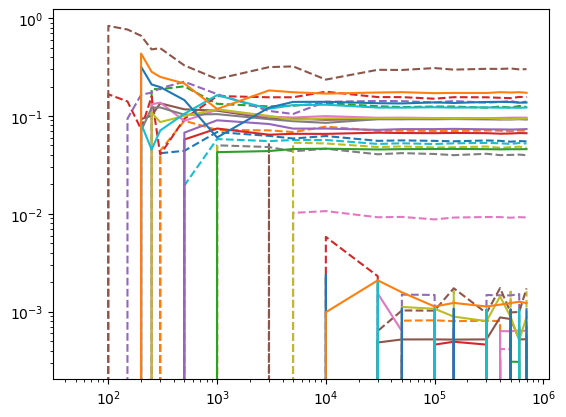

In [351]:
for sp in new_aplf.index:
    plt.plot(new_aplf.columns, new_aplf.loc[sp], linestyle='dashed')
for sp in new_dict_af.index:

    plt.plot(new_dict_af.columns, new_dict_af.loc[sp])
#plt.xlim(1000, )
#plt.ylim(-0.01, 0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

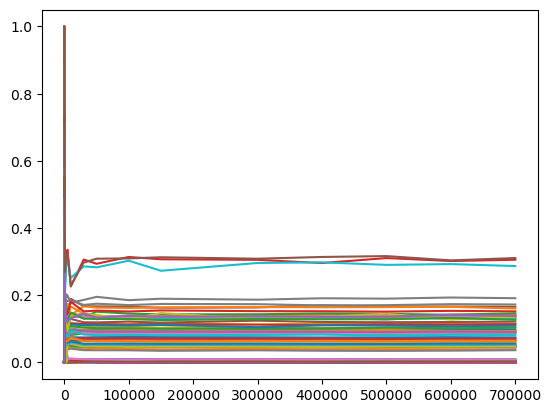

In [311]:
for i in lims.keys():
    for sp in lims[i].index:
        plt.plot(lims[i].loc[sp])


In [171]:
lims[i]['s__Candida_dubliniensis']

KeyError: 's__Candida_dubliniensis'

100000    10000     1000    100     150     \
s__Candida_dubliniensis       0.000000  0.000000  0.000000       0       0   
s__Rhodotorula_dairenensis    0.000000  0.000000  0.000000       0       0   
s__Candida_intermedia         0.000000  0.000000  0.000000       0       0   
s__Candida_africana           0.000000  0.000000  0.000000       0       0   
s__Meyerozyma_carpophila      0.000000  0.000000  0.000000       0       0   
s__Candida_sp                 0.002593  0.000000  0.000000       0       0   
s__Meyerozyma_caribbica       0.000000  0.000000  0.000000       0       0   
s__Candida_orthopsilosis      0.000000  0.000000  0.000000       0       0   
s__Yarrowia_deformans         0.000000  0.000000  0.000000       0       0   
s__Fungi_sp                   0.000000  0.000000  0.000000       0       0   
s__Candida_auris              0.000000  0.000000  0.000000       0       0   
s__Pichia_sp                  0.000000  0.000000  0.000000       0       0   
s__Meyerozyma_sp              0.001662  0.000000  0.000000       0       0   
s__Debaryomyces_hansenii      0.003186  0.000000  0.000000       0       0   
s__Aureobasidium_pullulans    0.000000  0.000000  0.000000       0       0   
s__Rhodotorula_sp             0.001326  0.000000  0.000000       0       0   
s__Kluyveromyces_marxianus    0.044093  0.044304  0.044733       0       0   
s__Meyerozyma_guilliermondii  0.070532  0.070158  0.079365       0       0   
s__Rhodotorula_mucilaginosa   0.072472  0.074135  0.092352       0       0   
s__Candida_tropicalis         0.092321  0.084079  0.139971       0       0   
s__Candida_parapsilosis       0.096933  0.100431  0.109668       0       0   
s__Candida_albicans           0.113418  0.103524  0.106782       0       0   
s__Issatchenkia_orientalis    0.086780  0.081759  0.135642       0       0   
s__Clavispora_lusitaniae      0.112646  0.116893  0.170274       0       0   
s__Clavispora_sp              0.136196  0.135344  0.000000       0       0   
s__Yarrowia_lipolytica        0.165842  0.189371  0.121212       1       1   

                                200       250       30000     3000    \
s__Candida_dubliniensis       0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_dairenensis    0.000000  0.000000  0.000000  0.000000   
s__Candida_intermedia         0.000000  0.000000  0.000000  0.000000   
s__Candida_africana           0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_carpophila      0.000000  0.000000  0.000000  0.000000   
s__Candida_sp                 0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_caribbica       0.000000  0.000000  0.001535  0.000000   
s__Candida_orthopsilosis      0.000000  0.000000  0.000000  0.000000   
s__Yarrowia_deformans         0.000000  0.000000  0.000000  0.000000   
s__Fungi_sp                   0.000000  0.000000  0.000000  0.000000   
s__Candida_auris              0.000000  0.000000  0.002184  0.000000   
s__Pichia_sp                  0.000000  0.000000  0.000000  0.000000   
s__Meyerozyma_sp              0.000000  0.000000  0.000000  0.000000   
s__Debaryomyces_hansenii      0.000000  0.000000  0.003173  0.000000   
s__Aureobasidium_pullulans    0.000000  0.000000  0.000000  0.000000   
s__Rhodotorula_sp             0.000000  0.000000  0.003958  0.000000   
s__Kluyveromyces_marxianus    0.000000  0.000000  0.043401  0.041761   
s__Meyerozyma_guilliermondii  0.000000  0.000000  0.072745  0.069977   
s__Rhodotorula_mucilaginosa   0.000000  0.000000  0.072233  0.078254   
s__Candida_tropicalis         0.000000  0.116162  0.089430  0.098194   
s__Candida_parapsilosis       0.000000  0.156566  0.096083  0.105342   
s__Candida_albicans           0.000000  0.000000  0.110550  0.114372   
s__Issatchenkia_orientalis    0.000000  0.151515  0.086359  0.088789   
s__Clavispora_lusitaniae      0.000000  0.136364  0.114679  0.117005   
s__Clavispora_sp              0.441176  0.186869  0.135970  0.115500   
s__Yarrowia_lipolytica        0.558824  0.252525  0.1

Unnamed: 0  ITS1_1_100000_reads  ITS1_1_10000_reads  \
0         g__Triodiomyces             0.000028            0.000000   
1         g__Nakaseomyces             0.000083            0.000000   
2   g__Rhodosporidiobolus             0.000000            0.000000   
3           g__Dipodascus             0.000000            0.000000   
4         g__unidentified             0.000000            0.001542   
5         g__Debaryomyces             0.011948            0.000000   
6               g__Pichia             0.002323            0.002135   
7        g__Kluyveromyces             0.014437            0.049585   
8          g__Rhodotorula             0.028321            0.094069   
9           g__Meyerozyma             0.031806            0.014591   
10            g__Yarrowia             0.201538            0.154448   
11        g__Issatchenkia             0.186796            0.131910   
12          g__Clavispora             0.308433            0.305694   
13             g__Candida             0.214288            0.246026   

    ITS1_1_1000_reads  ITS1_1_100_reads  ITS1_1_150000_reads  \
0            0.000000            0.0000             0.000000   
1            0.000000            0.0000             0.000062   
2            0.000000            0.0000             0.000000   
3            0.000000            0.0000             0.000000   
4            0.000000            0.0000             0.000000   
5            0.000000            0.0000             0.000000   
6            0.006652            0.0000             0.000000   
7            0.005543            0.0625             0.053161   
8            0.076497            0.0750             0.022825   
9            0.086475            0.0875             0.094101   
10           0.149667            0.1750             0.024983   
11           0.109756            0.0875             0.139004   
12           0.267184            0.1250             0.337974   
13           0.298226            0.3875             0.327890   

    ITS1_1_150_reads  ITS1_1_200_reads  ITS1_1_250_reads  ITS1_1_30000_reads  \
0           0.000000          0.000000          0.000000            0.000000   
1           0.000000          0.000000          0.000000            0.000000   
2           0.000000          0.000000          0.000000            0.000000   
3           0.000000          0.000000          0.000000            0.000000   
4           0.000000          0.000000          0.000000            0.003751   
5           0.000000          0.000000          0.000000            0.000000   
6           0.000000          0.000000          0.000000            0.000000   
7           0.046154          0.060976          0.056995            0.043238   
8           0.069231          0.085366          0.036269            0.082758   
9           0.069231          0.091463          0.077720            0.075089   
10          0.215385          0.201220          0.222798            0.129848   
11          0.130769          0.134146          0.015544            0.111494   
12          0.253846          0.213415          0.362694            0.277413   
13          0.215385          0.213415          0.227979            0.276408   

    ...  ITS1_R3_150000_reads  ITS1_R3_150_reads  ITS1_R3_200_reads  \
0   ...              0.000000           0.000000           0.000000   
1   ...              0.000120           0.000000           0.000000   
2   ...              0.000000           0.000000           0.000000   
3   ...              0.000000           0.000000           0.000000   
4   ...              0.000000           0.000000           0.000000   
5   ...              0.000000           0.000000           0.000000   
6   ...              0.000000           0.000000           0.000000   
7   ...              0.074811           0.063492           0.065476   
8   ...              0.031734           0.166667           0.154762   
9   ...              0.159882           0.174603           0.148810   
10  ...              

In [631]:
read_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pike_pool_mode/ITS_full/pike_ITS1_2_full_trimmed_pool_k6_30000_reads/results/ITS1_5.8_ITS2_1/results.tsv', sep='\t', index_col=0).T.to_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pike_pool_mode/ITS_full/pike_ITS1_2_full_trimmed_pool_k6_30000_reads/results/ITS1_5.8_ITS2_1/new_tab.tsv', sep='\t')

In [11]:
tax_table = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_04_1/TAX_CALL/tax_table.tsv', sep='\t', index_col=0)
tax_table

Kingdom  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...  k__Fungi   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...  k__Fungi   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...  k__Fungi   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATATTTGAGATGAAAATG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTTAATGATTCGA...  k__Fungi   
GAGACCAAGAGATCCGTTGTTGAAGTTTATTAATATGAATAAAATCA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAGCCAAGAGATCCGTTGTTGATAGTTTTGATTTAGATAAAATGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTTAAATGATTC...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTTGTTTTGATTTAGTTG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...  k__Fungi   

                                                              Phylum  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     p__Ascomycota   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...     p__Ascomycota   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...  p__Basidiomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...     p__Ascomycota   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATATTTGAGATGAAAATG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTTAATGATTCGA...     p__Ascomycota   
GAGACCAAGAGATCCGTTGTTGAAGTTTATTAATATGAATAAAATCA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAGCCAAGAGATCCGTTGTTGATAGTTTTGATTTAGATAAAATGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTTAAATGATTC...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTTGTTTTGATTTAGTTG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     p__Ascomycota   

                                                                    Class  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTT

In [16]:
otu_tab_pike = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_04_1/merged_otu_table.tsv', sep='\t', index_col=0).T
otu_tab_pike.loc['GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATAAATCAAGTTTGACTGTAAATAAAAAGTTTGGTTTAGTTATAACCTCTGGCGGTAGGATTGCTCCCGCCACCAAAGAAATTTGTTCAATAAAAAACACATGTGGTGCAATTAAGCAAATCAGTAATGATCCTTCCGCAGGTTCACCTACGGAAA']

ITS1_1     294.0
ITS1_2     453.0
ITS1_3     347.0
ITS1_R1    339.0
ITS1_R2    462.0
ITS1_R3    434.0
Name: GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATAAATCAAGTTTGACTGTAAATAAAAAGTTTGGTTTAGTTATAACCTCTGGCGGTAGGATTGCTCCCGCCACCAAAGAAATTTGTTCAATAAAAAACACATGTGGTGCAATTAAGCAAATCAGTAATGATCCTTCCGCAGGTTCACCTACGGAAA, dtype: float64

In [118]:
otu_tab_pike

ITS1_1  ITS1_2  ITS1_3  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...   294.0   453.0   347.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...   323.0   419.0   374.0   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...   380.0   320.0   293.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...   196.0   246.0   194.0   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...     4.0     4.0     4.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...   274.0   214.0   247.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...   213.0   202.0   252.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...   136.0   127.0   137.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...   147.0   106.0   108.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...   100.0    89.0    99.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...    49.0    44.0    49.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...   108.0    72.0   113.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...    60.0    48.0    64.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...     5.0    16.0     3.0   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATATTTGAGATGAAAATG...     7.0    10.0     6.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTTAATGATTCGA...     6.0    10.0     4.0   
GAGACCAAGAGATCCGTTGTTGAAGTTTATTAATATGAATAAAATCA...     5.0     9.0     3.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     8.0     8.0     5.0   
GAGAGCCAAGAGATCCGTTGTTGATAGTTTTGATTTAGATAAAATGA...    10.0     7.0     3.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...     6.0     7.0    10.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     8.0     7.0     5.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     4.0     7.0     4.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTTAAATGATTC...     5.0     6.0     5.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     6.0     6.0     6.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     4.0     6.0     6.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTTGTTTTGATTTAGTTG...    18.0     6.0     9.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     2.0     4.0     4.0   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     3.0     2.0     3.0   

                                                    ITS1_R1  ITS1_R2  ITS1_R3  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...    339.0    462.0    434.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...    329.0    427.0    337.0  
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...    220.0    244.0    149.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...    253.0    235.0    243.0  
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...      6.0      3.0      4.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...    370.0    232.0    349.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...    318.0    262.0    385.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...    102.0    104.0     76.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...    206.0    136.0    191.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     74.0     81.0     47.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...     38.0     49.0     34.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     68.0     90.0     61.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     32.0     34.0     32.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...      4.0      7.0      5.0  
GAGAGCCAAGAGATCCGTTGTTGATAGTTATATTTGAGATGAAAATG...      5.0      3.0      2.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTTAATGATTCGA...      3.0      3.0      2.0  
GAGACCAAGAGATCCGTTGTTGAAGTTTATTAATATGAATAAAATCA...      4.0      2.0      5.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...      4.0      2.0      2.0  
GAGAGCCAAGAGATCCGTTGTTGATAGTTTTGATTTAGATAAAATGA...      5.0      3.0      5.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...      4.0      2.0      5.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...      4.0      9.0      2.0  
GAGAACCAAGAGATCCGTTGTTGAAAGTT

In [111]:
metadata_df = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_04_1/work_dir/metadata_df.tsv', sep='\t', index_col=0)
metadata_df

Read ID BARCODE  1 UMAP COMPONENT  \
0      3b7516e0-06aa-417e-bbab-11260eafada3  ITS1_2        -54.574734   
1      a946287a-e593-4286-aa6a-97f83e39be89  ITS1_2        -74.835464   
2      dda277f3-f35c-4ca1-9b73-1194039c9a1f  ITS1_2         52.589092   
3      f3c65f93-954b-44aa-aa0a-3fd14f06fa8b  ITS1_2          3.098197   
4      71e7659a-b36e-437f-85d7-3a7e5a1bd774  ITS1_2        -77.585464   
...                                     ...     ...               ...   
17995  91da3a07-4396-424a-8cb1-871e57d805f0  ITS1_3        -58.543045   
17996  db84862d-57c8-4289-9fbc-cf22ee9a11b5  ITS1_3         17.177698   
17997  9fa177e7-f21f-46bd-b0c8-b1c9dd518bc2  ITS1_3        -73.536580   
17998  d8765609-90ae-4eae-ba04-eb3e5773bc07  ITS1_3        -53.213670   
17999  74f9706f-832e-4c82-8897-ee26da505499  ITS1_3        -44.882828   

       2 UMAP COMPONENT  Length  \
0             63.009396     164   
1             -4.734991     200   
2             40.618990     136   
3            -34.809380     195   
4             -3.986650     201   
...                 ...     ...   
17995         64.987940     165   
17996         75.778610     208   
17997         -3.215860     199   
17998         61.438717     166   
17999        -63.734630     121   

                                                  READ_Q  \
0      A=<A=<8<=;>92111558955ECAABC@=:><>=CA@A3,,-311...   
1      @@@?570-,/30(**==??<A@@BAGDE@>8879?;1.--+*((./...   
2      B:>B?@BA@>>>?<;;<<=<<A@>;=@?:::BBDB{@>>BDF>B??...   
3      $%$$'(,'((3+46*1??>>>=?>>:629><2AA===>@@>210:>...   
4      56=@A;734.2{{{{0?=.497:BB=44431/-/00:<===>@CCD...   
...                                                  ...   
17995  78=>G?A@>,/{F<=><;>>BABBCD@=?@DH=;EHC@BBGGC:::...   
17996  9;899:DC?@??>=<<?43223A=><=CD@@??AC?HCFDBCEB>>...   
17997  ::@=?@ACD::?>;554,,,.42&,55/''+,7114B@=@@>>?:5...   
17998  DDA?A@A??:>??<=?BDD=666:664378:>>@>B@CA9,+++,?...   
17999  870-,/.00.4<E=<5,+++----,36'').>A@ABA=>=>@>>?7...   

                                                READ_Seq  GC content  QUALITY  \
0      GAGAACCAAGAGATCCGTTGTTGAGAGTTTTGTTTGTTTTTCTGTA...    0.396341     28.0   
1      GAGAACCAAAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...    0.360000     28.0   
2      GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAG...    0.352941     29.0   
3      AAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAATC...    0.405128     26.0   
4      GAGAACCAAGAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATA...    0.368159     24.0   
...                                                  ...         ...      ...   
17995  GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTA...    0.393939     28.0   
17996  GAGTACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATC...    0.350962     29.0   
17997  GAGAACCAAGAGATCCGTTGTTGAAAAGTTTTGACTATTGTAATAA...    0.361809     22.0   
17998  GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTA...    0.379518     20.0   
17999  GAGAGCCAAGAGATCCAGATGGTGATATTATAATTGAGATAAAATG...    0.355372     25.0   

       Clusters  
0             6  
1             5  
2             8  
3            10  
4             5  
...         ...  
17995         6  
17996         0  
17997         5  
17998         6  
17999         4  

[18000 rows x 10 columns]

In [141]:
new_data = {}

for otu in listdir('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_04_1/work_dir/medaka'):
    
    subset = metadata_df[metadata_df.Clusters == int(otu)]

    opn_seq = parse(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_04_1/work_dir/medaka/{otu}/consensus.fasta', 'fasta')
    for line in opn_seq:
        cons = str(line.seq)
        
    if cons not in new_data.keys():
        
        new_data[cons] = {samp : 0 for samp in metadata_df.BARCODE.unique()}
        

    
    for samp in subset.value_counts('BARCODE').to_dict():
        new_data[cons][samp] += subset.value_counts('BARCODE')[samp]
    
    
new_data = DataFrame(new_data).T

In [161]:
subset = new_data[i][new_data[i] != 0]
subset
DataFrame(index=subset.index, columns=['Count'], data=subset.values)

GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAATTTGACTAACTGTAAAAATAATTAAATTGTGTTTTGTTAAACCTCTGGCCCAACCTATCTCTAGGCCAAACCAAAGCAAGAGTTCTGTATCAAAAAGACACTGTGTGTAAGGTTTTTCGCCGCGCAGTTAAGCGCTGGCAAAAGAATACTGTAATGATCCTTCCGCAGGTTCACCTACGGAAA  \
ITS1_2                                                 202                                                                                                                                                                                        
ITS1_R1                                                318                                                                                                                                                                                        
ITS1_1                                                 213                                                                                                                                                                                        
ITS1_R2                                                262                                                                                                                                                                                        
ITS1_R3                                                385                                                                                                                                                                                        
ITS1_3                                                 252                                                                                                                                                                                        

         GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATAAATCAAGTTTGACAGTAAATAAAAAGTTTGGTTTAGTTATAATCTCTGGCGGTAGGATTGCTCCCGCCACCAAAGAAATTTGTTCAATAAAAAACACATGTGGTGCAATTAAGCAAATCAGTAATGATCCTTCCGCAGGTTCACCTACGGAAACCTTGTTACGACTTTTACTTCCAGCTGCGTTCTTCATCGATGCGAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATAAATCAAGTTTGACTGTAAATAAAAAGTTTGGTTTAGTTATAACCTCTGGCGGTAGGATTGCTCCCGCCACCAAAGAAATTTGTTCAATAAAAAACACATGTGGTGCAATTAAGCAAATCAGTAATGATCCTTCCGCAGGTTCACCTACGGAAA  \
ITS1_2                                                   6                                                                                                                                                                                                                                                                                                                                                                                                             
ITS1_R1                                                  7                                                                                                                                                                                                                                                                                                                                                                                                             
ITS1_1                                                   4                                                                                                                                                                                                                                                                                                                                                                                                             
ITS1_R2                                                  3                                                                                                                                                                                                                                                                                                                                                                                                             
ITS1_R3                    

In [144]:
otu_tab_pike = new_data 

In [171]:
otu_tab_pike = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_05_5/merged_otu_table.tsv', sep='\t', index_col=0).T

In [177]:
tax_table = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/IGNAT_TEST_2024_07_05_5/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)


In [178]:
tax_table

Kingdom  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  k__Fungi   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...  k__Fungi   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...  k__Fungi   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...  k__Fungi   

                                                              Phylum  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     p__Ascomycota   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...  p__Basidiomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...     p__Ascomycota   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...     p__Ascomycota   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...     p__Ascomycota   

                                                                    Class  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     c__Saccharomycetes   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...  c__Microbotryomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...     c__Saccharomycetes   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...     c__Saccharomycetes   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...     c__Saccharomycetes   

                                                                   Order  \
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTGTAATAATA...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  o__Saccharomycetales   
GAGAGCCAAGAGATCCGTTGTTGAAAGTTTTATTTTGTTATAAAATT...    o__Sporidiobolales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAATATTAAATTTTAT...  o__Saccharomycetales   
GAGAGCCAAGAGATCCGTTGTTGATAGTTATAATTGAGATAAAATGA...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAGTAATAAT...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGAAGATTAATTCAAAA...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATTTAAATGATTCGA...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGTTTGTTTTTTCGTAG...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGATATTAAGAAATTCG...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTGACTATTAAATAATCG...  o__Saccharomycetales   
GAGAACCAAGAGATCCGTTGTTGAAAGTTTTATGTTTTTGTTTTAGT...  o__Saccharomycetales   

   

In [179]:
taxtabotu = {}
otu_dict = {}

otu_count = 0

for samp in otu_tab_pike.columns:
    
    taxtabotu[samp] = {}
    
    for i in tax_table.index:
        if i not in otu_dict.keys():
            otu_dict[i] = otu_count
            otu_count += 1
            
        if f"OTU{otu_dict[i]}_{tax_table['Species'][i]}" not in taxtabotu[samp].keys():
            taxtabotu[samp][f"OTU{otu_dict[i]}_{tax_table['Species'][i]}"] = 0
        
        taxtabotu[samp][f"OTU{otu_dict[i]}_{tax_table['Species'][i]}"] += otu_tab_pike[samp][i]


In [180]:
taxtabotu = {}
lens = {}

for samp in otu_tab_pike.columns:
    
    taxtabotu[samp] = {}
    
    for i in tax_table.index:

        if tax_table['Species'][i] not in taxtabotu[samp].keys():
            taxtabotu[samp][tax_table['Species'][i]] = 0
            lens[tax_table['Species'][i]] = []
            
        taxtabotu[samp][tax_table['Species'][i]] += otu_tab_pike[samp][i]
        lens[tax_table['Species'][i]].append(len(i))

<Axes: >

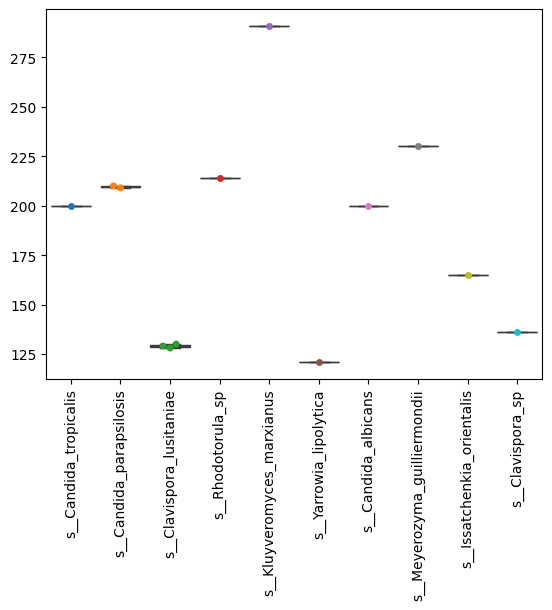

In [181]:
sns.boxplot(lens)
plt.tick_params(axis='x', labelrotation=90)
sns.swarmplot(lens)
#axs [0][x_coord].tick_params(axis='y', labelrotation=360)

In [182]:
all_samps = DataFrame(taxtabotu)
# = all_samps/all_samps.sum(axis=1)
all_samps = (all_samps/all_samps.sum(axis=0))[::-1]
all_samps = all_samps.assign(m=all_samps.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(all_samps.columns)]


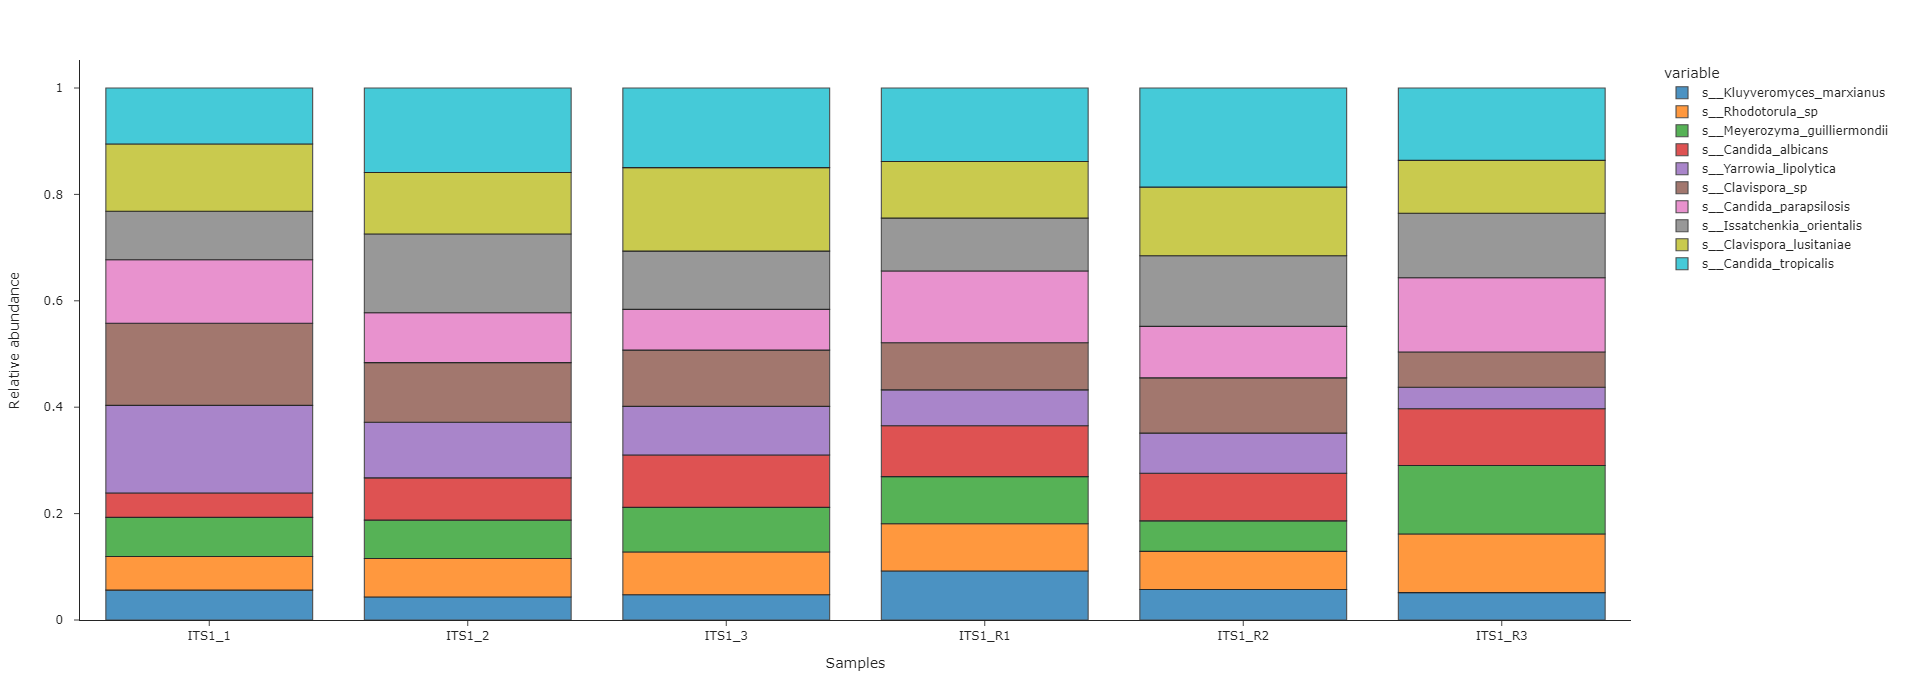

In [183]:

import plotly.express as px
import plotly.subplots as sp

fig = px.bar(all_samps.T, 
             y=all_samps.index, 
             x=all_samps.columns,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

In [66]:
from sklearn.metrics import silhouette_score

In [67]:
silhouette_score

<function sklearn.metrics.cluster._unsupervised.silhouette_score(X, labels, *, metric='euclidean', sample_size=None, random_state=None, **kwds)>

In [90]:
for i in metadata_df.value_counts('BARCODE').index:
    print(i)
    print(metadata_df[metadata_df.BARCODE == i].value_counts('Clusters')[:10])

ITS1_1
Clusters
4     380
6     323
5     294
0     274
8     245
11    214
2     213
10    196
3     147
7     136
Name: count, dtype: int64
ITS1_2
Clusters
5     453
6     419
4     320
10    246
11    220
0     214
2     202
8     189
7     127
3     106
Name: count, dtype: int64
ITS1_3
Clusters
6     374
5     347
4     293
2     252
0     247
8     245
11    221
10    194
7     137
14    113
Name: count, dtype: int64
ITS1_R1
Clusters
0     370
5     339
6     329
11    318
2     318
10    253
4     220
3     206
8     144
7     102
Name: count, dtype: int64
ITS1_R2
Clusters
5     462
6     427
2     262
11    255
4     244
10    235
0     232
8     173
3     136
7     104
Name: count, dtype: int64
ITS1_R3
Clusters
5     434
2     385
0     349
11    342
6     337
10    243
3     191
4     149
8     126
7      76
Name: count, dtype: int64


In [708]:
otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new_new_new_new/merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new_new_new_new/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

In [502]:
otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R10_pool_new//merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R10_pool_new/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

In [744]:
otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_single_new_new_new_new///merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_single_new_new_new_new//TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

In [749]:
otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/R9_single_2/merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/R9_single_2/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

In [787]:
otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_pool/merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_pool//TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

In [780]:
otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_single/merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_single//TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

In [793]:
full_data = {'single': {}, 
             'pool' : {}}


otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_single/merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_single//TAXONOMY/tax_table.tsv', sep='\t', index_col=0)


for taxlevel in ['Genus', 'Species', 'OTU']:
    
    full_data['single'][taxlevel] = []
    metadata = {samp : {} for samp in otutab.index}
    otu_count = 0
    
    for i in otutab.columns:
        try:
            
            taxon = taxtab[taxlevel][i]
            
            if taxlevel == 'OTU':
                
                taxon = ' '.join(taxtab['Species'][i].split(' ')[:2])
                taxon = f'OTU{otu_count}_{taxon}' 
                otu_count += 1
            
    
        #    taxon = taxtab['Genus'][i]
    
        except:continue
        
        for samp in otutab.index:
                
            if taxon not in metadata[samp].keys():
                
                metadata[samp][taxon] = 0
            
            metadata[samp][taxon] += otutab[i][samp]
            
    metadata = DataFrame(metadata)   
    metadata_df = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/R9_single_2//work_dir/mock4_run3bc08_5000//metadata_df.tsv', sep='\t', index_col=0)
    metadata_df = metadata_df[metadata_df.Clusters != -1]
    full_data['single'][taxlevel] = metadata

otutab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_pool/merged_otu_table.tsv', sep='\t', index_col=0)
taxtab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/mock_Zymo_pool//TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

for taxlevel in ['Genus', 'Species', 'OTU']:
    
    full_data['pool'][taxlevel] = []
    metadata = {samp : {} for samp in otutab.index}
    otu_count = 0
    
    for i in otutab.columns:
        try:
            
            taxon = taxtab[taxlevel][i]
            
            if taxlevel == 'OTU':
                
                taxon = ' '.join(taxtab['Species'][i].split(' ')[:2])
                taxon = f'OTU{otu_count}_{taxon}' 
                otu_count += 1
            
    
        #    taxon = taxtab['Genus'][i]
    
        except:continue
        
        for samp in otutab.index:
                
            if taxon not in metadata[samp].keys():
                
                metadata[samp][taxon] = 0
            
            metadata[samp][taxon] += otutab[i][samp]
            
    metadata = DataFrame(metadata)
    metadata_df = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/R9_single_2//work_dir/mock4_run3bc08_5000//metadata_df.tsv', sep='\t', index_col=0)
    metadata_df = metadata_df[metadata_df.Clusters != -1]
    full_data['pool'][taxlevel] = metadata

In [795]:

fig, axs = plt.subplots(1, 6, figsize=((12+12)*1.1, (13+2.5)*1.1), 
                        gridspec_kw={'height_ratios': [1, 0.3]}, constrained_layout=True)
x_coord = 0

for mode in full_data.keys():
    
    
    for taxlevel in tqdm(['Genus', 'Species', 'OTU']):
        
        otu_tab_viz = full_data[mode][taxlevel][0].T
        otu_tab_viz['Sample Name'] = sample_data['Sample Name']
        otu_tab_viz = otu_tab_viz.set_index('Sample Name')
        otu_tab_viz = otu_tab_viz.loc[np.sort(otu_tab_viz.index)]
        otu_tab_viz = otu_tab_viz[otu_tab_viz.index.str.contains('Zymo')]
        data_tax_df = otu_tab_viz.T
        data_tax_df = data_tax_df.assign(m=data_tax_df.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(data_tax_df.columns)]
        data_tax_df_viz = data_tax_df[::-1][:20]
    
        sns.heatmap(np.round(data_tax_df_viz, 2), 
                    ax=axs[0][x_coord], cmap='Purples', linewidths=.1, linecolor='grey',
                    annot=True)
        axs[0][x_coord].xaxis.tick_top()
        axs[0][x_coord].set_title(taxlevel, fontsize=18)
        axs[0][x_coord].set_xlabel('')
        
        for spine in axs[0][x_coord].spines.values():
            spine.set_visible(True)
        for spine in axs[0][x_coord].spines.values():
            spine.set(visible=True, lw=.8, edgecolor="black")
        
        axs[0][x_coord].tick_params(axis='x', labelrotation=90)
    
    
        
        #matrix = np.triu(np.round(data_tax_df.corr('spearman'), 2))
       # viz = DataFrame(data=np.round(squareform(pdist(clr(data_tax_df.T + 0.0001)), 'euclidean'), 2), index=data_tax_df.columns, columns=data_tax_df.columns)
        viz = np.round(data_tax_df.corr('spearman'), 2)
        
        g = sns.heatmap(viz, 
                    ax=axs[1][x_coord], cmap='Purples', annot=True)
    
    
    
        axs[1][x_coord].set_xlabel('')
        axs[1][x_coord].set_ylabel('')
        for spine in axs[1][x_coord].spines.values():
            spine.set_visible(True)
        for spine in axs[1][x_coord].spines.values():
            spine.set(visible=True, lw=.8, edgecolor="black")
        x_coord += 1

data_tax_df_viz = rel_tab
sns.heatmap(np.round(data_tax_df_viz, 2), 
            ax=axs[0][x_coord], cmap='Purples', linewidths=.1, linecolor='grey',
            annot=True)
axs[0][x_coord].xaxis.tick_top()
axs[0][x_coord].set_title('OTU (pool mode)', fontsize=18)
axs[0][x_coord].set_xlabel('')

for spine in axs[0][x_coord].spines.values():
    spine.set_visible(True)
for spine in axs[0][x_coord].spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

axs[0][x_coord].tick_params(axis='x', labelrotation=90)



#matrix = np.triu(np.round(data_tax_df.corr('spearman'), 2))
# viz = DataFrame(data=np.round(squareform(pdist(clr(data_tax_df.T + 0.0001)), 'euclidean'), 2), index=data_tax_df.columns, columns=data_tax_df.columns)
viz = np.round(data_tax_df.corr('spearman'), 2)

g = sns.heatmap(viz, 
            ax=axs[1][x_coord], cmap='Purples', annot=True)



axs[1][x_coord].set_xlabel('')
axs[1][x_coord].set_ylabel('')
for spine in axs[1][x_coord].spines.values():
    spine.set_visible(True)
for spine in axs[1][x_coord].spines.values():
    spine.set(visible=True, lw=.8, edgecolor="black")

#plt.tight_layout(w_pad=5)
#plt.savefig('VIZ/Exteranal_zymo_pool.png', dpi=800, bbox_inches='tight')
#plt.savefig('VIZ/Exteranal_zymo_pool.pdf', bbox_inches='tight')
plt.show()

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 2640x1705 with 0 Axes>

In [732]:
taxtab

Empty DataFrame
Columns: []
Index: []

In [718]:
taxtab[taxtab.Genus == 'Salmonella']

Kingdom          Phylum  \
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Bacteria  Proteobacteria   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Bacteria  Proteobacteria   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Bacteria  Proteobacteria   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Bacteria  Proteobacteria   
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGGACAGA...  Bacteria  Proteobacteria   

                                                                  Class  \
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Gammaproteobacteria   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Gammaproteobacteria   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Gammaproteobacteria   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Gammaproteobacteria   
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGGACAGA...  Gammaproteobacteria   

                                                               Order  \
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacterales   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacterales   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacterales   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacterales   
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGGACAGA...  Enterobacterales   

                                                                Family  \
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacteriaceae   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacteriaceae   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacteriaceae   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Enterobacteriaceae   
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGGACAGA...  Enterobacteriaceae   

                                                         Genus  \
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella   
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella   
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGGACAGA...  Salmonella   

                                                                                              Species  
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella enterica subsp. enterica serovar Ch...  
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella enterica subsp. enterica serovar Ch...  
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella enterica subsp. enterica serovar Pa...  
ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACA...  Salmonella enterica subsp. enterica serovar Or...  
GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGGACAGA...  Salmonella enterica subsp. enterica serovar Ty...

In [591]:
otutab.T.loc[taxtab[taxtab.Species == 'Bacillus sp.'].index]

Empty DataFrame
Columns: [SRR23176493, SRR23176494, SRR23176495]
Index: []

In [592]:
[len(i) for i in taxtab]

[7, 6, 5, 5, 6, 5, 7]

In [711]:
metadata = {samp : {} for samp in otutab.index}

for i in otutab.columns:
    try:
        
        taxon = ' '.join(taxtab['Species'][i].split(' ')[:2])
     #   taxon = taxtab['Species'][i]

       # taxon = taxtab['Genus'][i]

    except:continue
    
    for samp in otutab.index:
            
        if taxon not in metadata[samp].keys():
            
            metadata[samp][taxon] = 0
        
        metadata[samp][taxon] += otutab[i][samp]
        
metadata = DataFrame(metadata)    

In [788]:
metadata = {samp : {} for samp in otutab.index}
otu_count = 0

for i in otutab.columns:
    try:
        
        taxon = ' '.join(taxtab['Species'][i].split(' ')[:2])
        taxon = f'OTU{otu_count}_{taxon}' 
        otu_count += 1
        #taxon = taxtab['Species'][i]

    #    taxon = taxtab['Genus'][i]

    except:continue
    
    for samp in otutab.index:
            
        if taxon not in metadata[samp].keys():
            
            metadata[samp][taxon] = 0
        
        metadata[samp][taxon] += otutab[i][samp]
        
metadata = DataFrame(metadata)    

In [601]:
metadata_df = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/R10/Pike_out/work_dir/SRR23176495/metadata_df.tsv', sep='\t', index_col=0)
metadata_df = metadata_df[metadata_df.Clusters != -1]

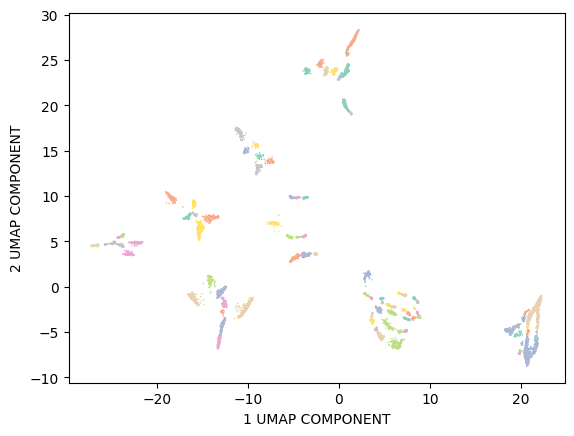

In [602]:
sns.scatterplot(metadata_df, x='1 UMAP COMPONENT', y='2 UMAP COMPONENT', hue='Clusters', s=1, palette='Set2', legend=False)
plt.show()

In [754]:
metadata_df = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/R9_single_2//work_dir/mock4_run3bc08_5000//metadata_df.tsv', sep='\t', index_col=0)
metadata_df = metadata_df[metadata_df.Clusters != -1]

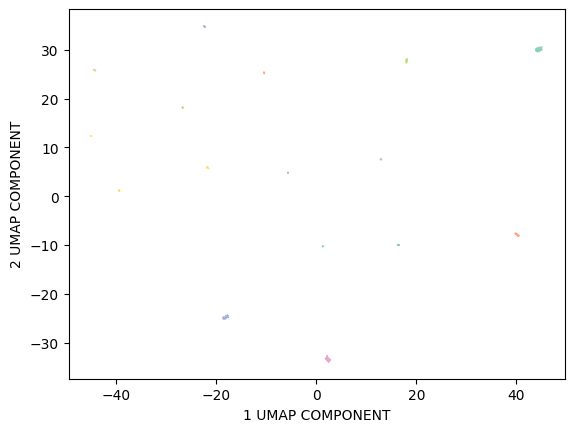

In [755]:
sns.scatterplot(metadata_df, x='1 UMAP COMPONENT', y='2 UMAP COMPONENT', hue='Clusters', s=1, palette='Set2', legend=False)
plt.show()

In [665]:
metadata_df = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new_new_new_new///work_dir/metadata_df.tsv', sep='\t', index_col=0)
metadata_df = metadata_df[metadata_df.Clusters != -1]

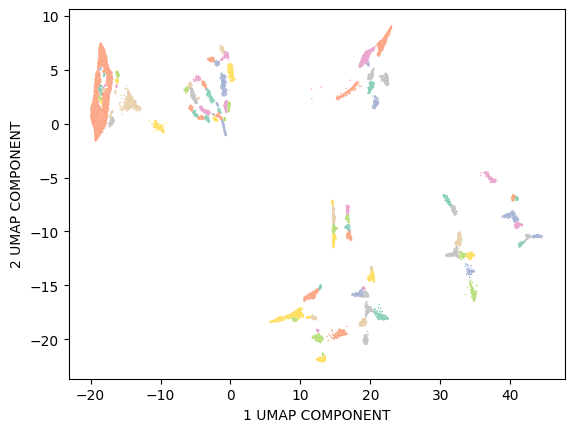

In [666]:
sns.scatterplot(metadata_df, x='1 UMAP COMPONENT', y='2 UMAP COMPONENT', hue='Clusters', s=1, palette='Set2', legend=False)
plt.show()

In [702]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=10,
                  cluster_selection_epsilon=0.001, 
                  gen_min_span_tree=True,
                  metric='euclidean')
clusters = hdbscan.fit_predict(np.array([metadata_df['1 UMAP COMPONENT'].values, metadata_df['2 UMAP COMPONENT'].values]).T)
metadata_df_new = metadata_df[clusters != -1]
clusters = clusters[clusters != -1]

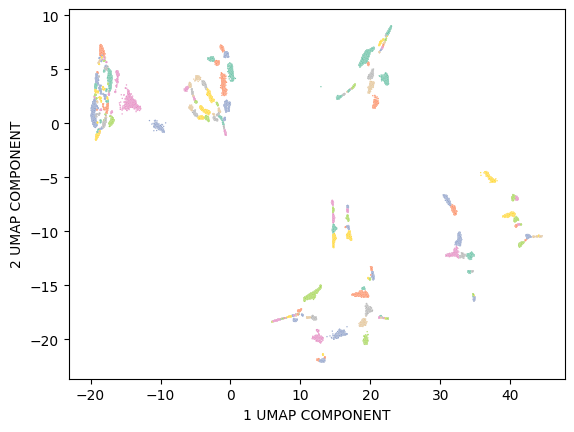

In [703]:
sns.scatterplot(metadata_df_new, x='1 UMAP COMPONENT', y='2 UMAP COMPONENT', hue=clusters, s=1, palette='Set2', legend=False)
plt.show()

In [789]:
metadata = (metadata/metadata.sum(axis=0))#.sum(axis=0)
metadata = metadata.assign(m=metadata.mean(axis=1)).sort_values('m').drop('m', axis=1)[np.sort(metadata.columns)]

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/home/krivonos_dv/.local/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

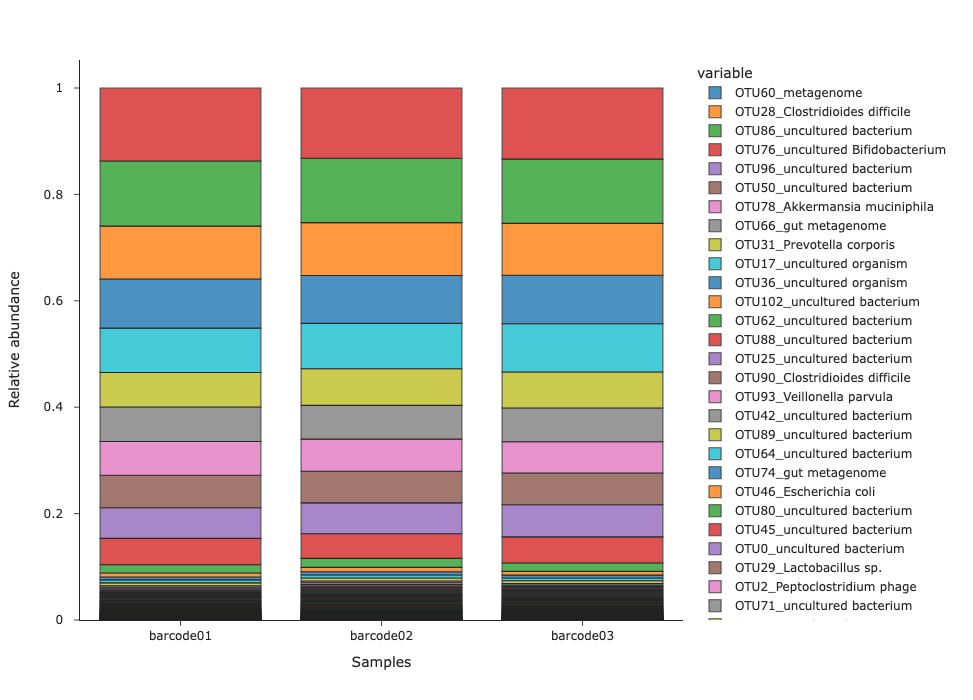

In [790]:

import plotly.express as px
import plotly.subplots as sp

fig = px.bar(metadata.T, 
             y=metadata.index, 
             x=metadata.columns,
             width=400, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

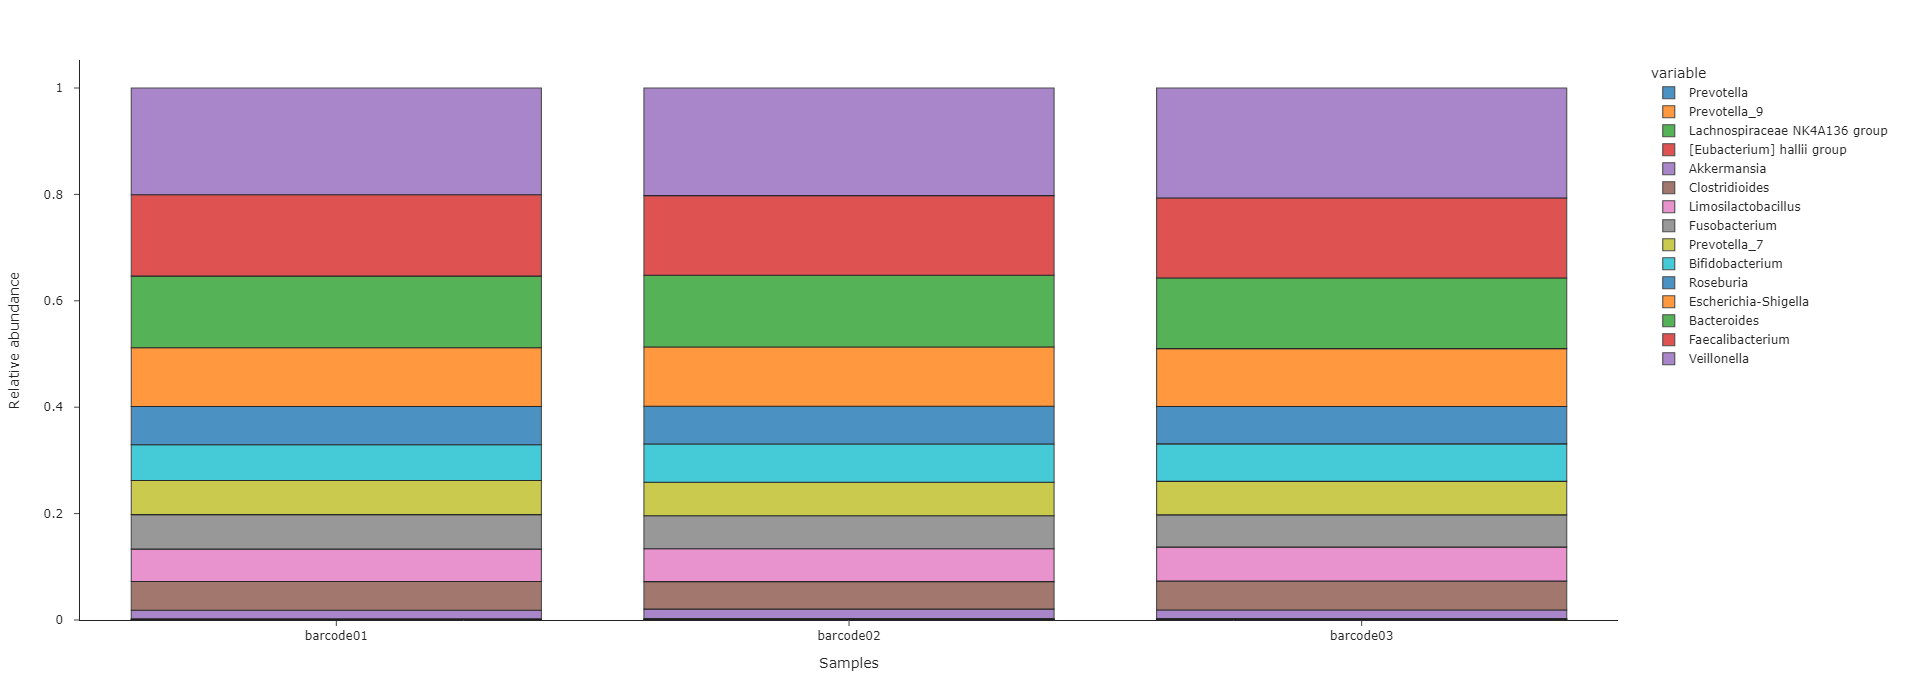

In [779]:

import plotly.express as px
import plotly.subplots as sp

fig = px.bar(metadata.T, 
             y=metadata.index, 
             x=metadata.columns,
             width=400, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

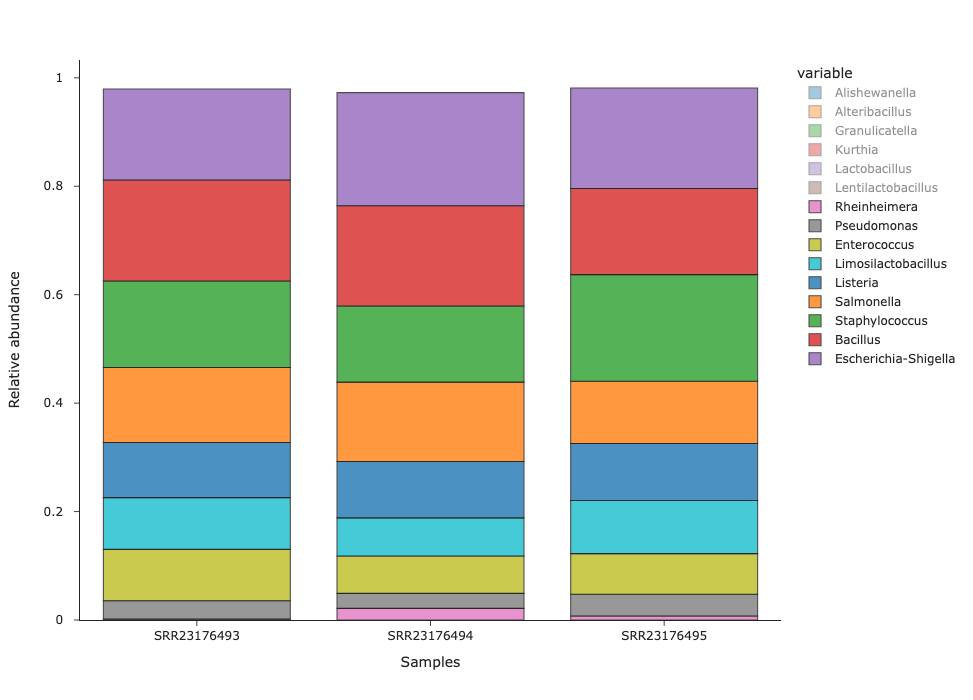

In [623]:

import plotly.express as px
import plotly.subplots as sp

fig = px.bar(metadata.T, 
             y=metadata.index, 
             x=metadata.columns,
             width=350, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

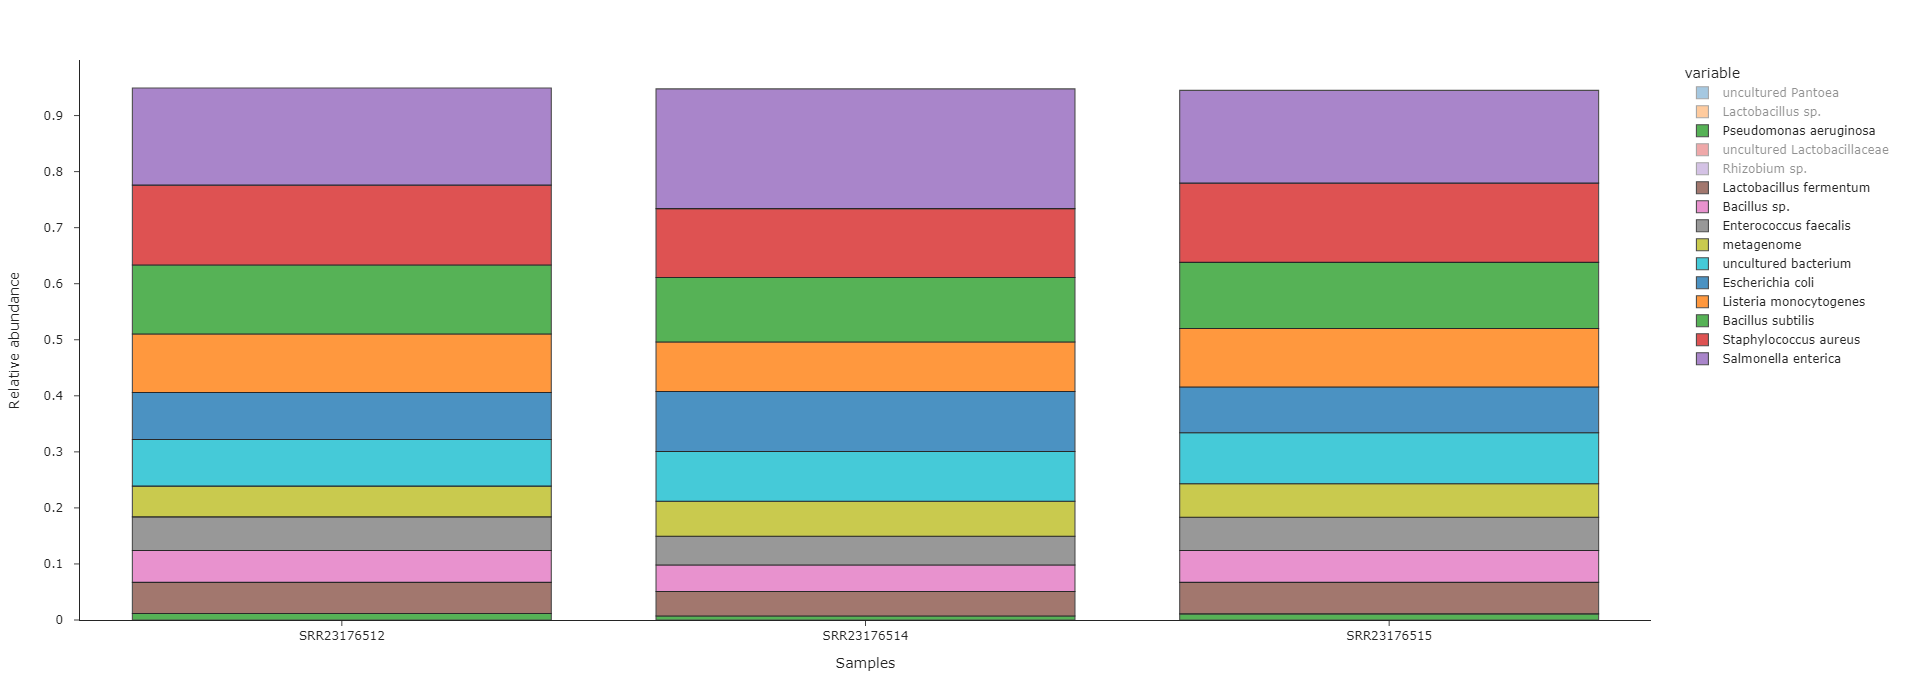

In [409]:

import plotly.express as px
import plotly.subplots as sp

fig = px.bar(metadata.T, 
             y=metadata.index, 
             x=metadata.columns,
             width=450, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

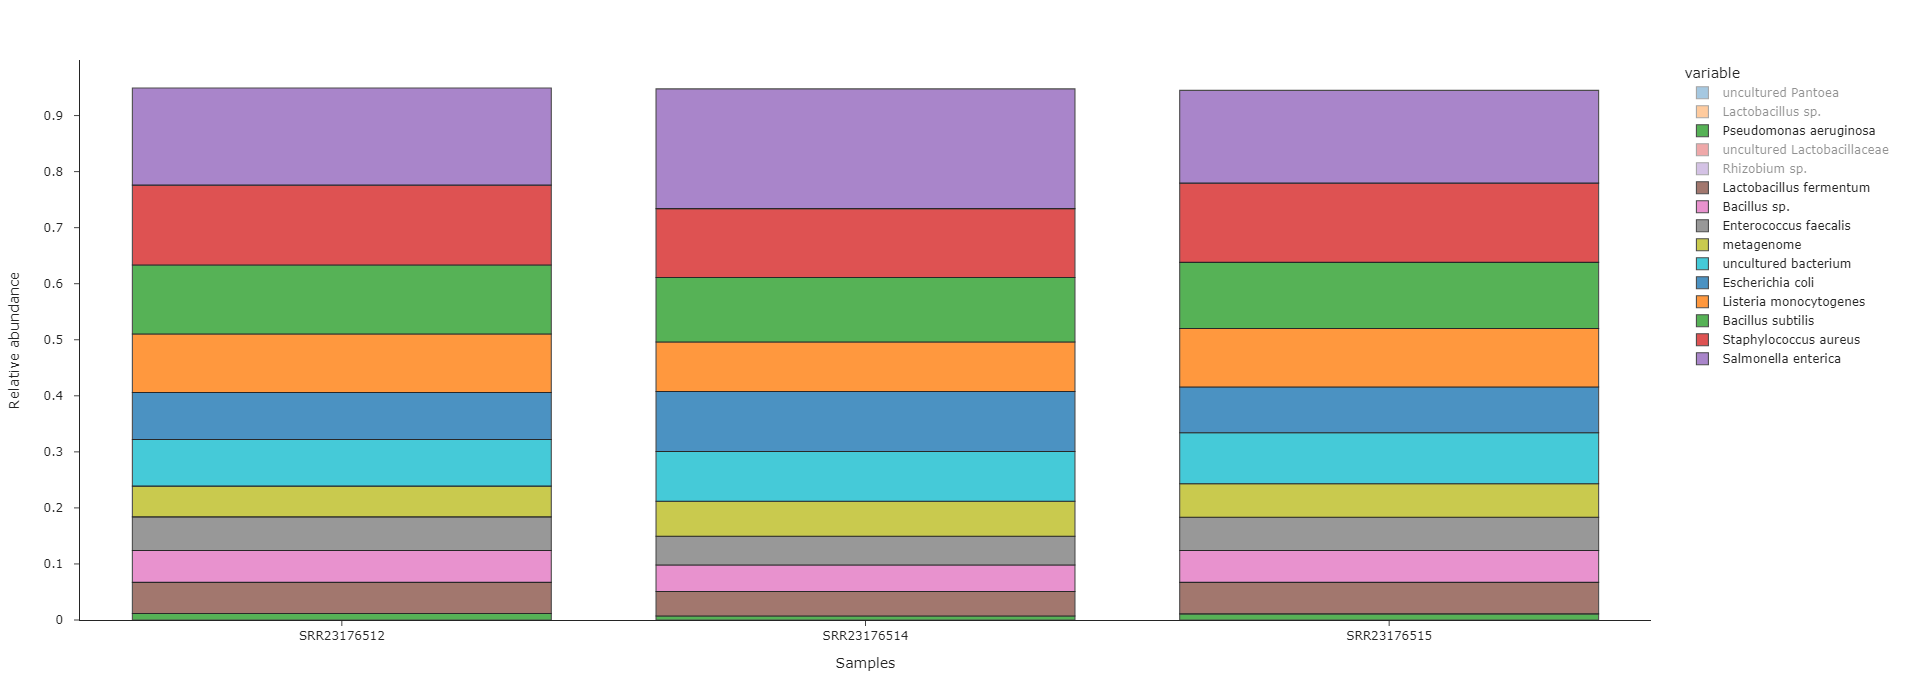

In [378]:
import plotly.express as px
import plotly.subplots as sp

fig = px.bar(metadata.T, 
             y=metadata.index, 
             x=metadata.columns,
             width=500, 
             height=700, 
            # color=data_tax_df.index,
             labels={'value': 'Relative abundance', 'index':'Samples'}, 
             template='simple_white',)
            # color_discrete_map=Color_collection)
#fig.update_layout(yaxis_range=[0, 1], legend_title_text='Taxon', legend_title_side='top center')
fig.update_traces(marker_line_width=1.1, marker_line_color='#202020', opacity=0.8)
fig.update_yaxes(ticksuffix = "  ")
fig.show()

In [530]:
import pickle

from scipy.sparse import vstack, csr_matrix

K_MERS_FREQs = []

for samp in listdir('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new//work_dir/features/sparse/'):
    with open(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new//work_dir/features/sparse/{samp}', 'rb') as fp:
            
        K_MERS_FREQ_barcode = pickle.load(fp)
    K_MERS_FREQs.append(K_MERS_FREQ_barcode)
K_MERS_FREQ = vstack(K_MERS_FREQs)


NameError: name 'K_MERS_FREQ' is not defined

In [533]:
K_MERS_FREQ = vstack(K_MERS_FREQs)


In [565]:
K_MERS_FREQ.shape

(71505, 15625)

In [566]:
K_MERS_FREQ[K_MERS_FREQ.A.sum(axis=0) > K_MERS_FREQ.shape[0]].shape

(0, 15625)

In [573]:
mat = csr_matrix([[1, 2, 0, 4], [2, 3, 0, 2]])

mat[mat.sum(axis=0) >0]
#csr_matrix(mat/mat.sum(axis=1)).sum(axis=1)

matrix([[1, 2, 4]])

In [576]:
idx = np.argwhere(np.all(mat[..., :] == 0, axis=0))

In [581]:
np.argwhere(np.all(mat.A[..., :] == 0, axis=0))

array([[2]])

In [583]:
np.delete(mat.A, idx, axis=1)

array([[4],
       [2]])

In [540]:
clr_data = csr_matrix(clr(K_MERS_FREQ.A))#clr_data = clr(K_MERS_FREQ)


In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=15,
                    random_state=0, svd_solver='arpack')
pca_data = pca_model.fit_transform(clr_data.A)

In [543]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=15,
                    random_state=0, svd_solver='arpack')
pca_data = pca_model.fit_transform(clr_data.A)

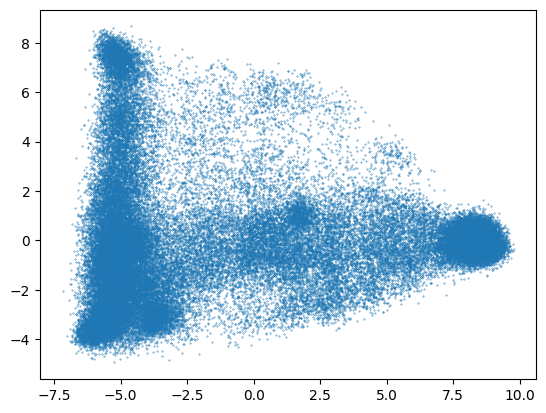

In [609]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], s=.1)

In [441]:
uniq = {}

for i in listdir('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new/work_dir/medaka/'):

    opn_fasta = parse(f'/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/REAL_COMPOSITION/Zymo/R9_pool_new/work_dir/medaka/{i}/consensus.fasta', 'fasta')
    for line in opn_fasta:
        if str(line.seq) not in uniq:
            
            uniq[str(line.seq)] = 0
    
        uniq[str(line.seq)] += int(line.id.split('_')[-1])
     #  if str(line.seq) not in taxtab.index:
       #     print(line.seq)

In [466]:
totaxon = {}

for seq in uniq.keys():
    try:
        
        if taxtab['Genus'][seq] not in totaxon.keys():
            
            totaxon[taxtab['Genus'][seq]] = 0
        if 'Escherichia-Shigella' in taxtab['Genus'][seq]:
            print(uniq[seq])
        totaxon[taxtab['Genus'][seq]] +=  uniq[seq]
    except: 
        print(seq)
        print(uniq[seq])

GACGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAACGAACGGAGGAAGAGCTTGCTCTTCCAAAGTTAGTGGCGGACGGGTGAGTAACACGTGGGCAACCTGCCTGTAAGTTGGGGATAACTTCGGGAAACCGGGGCTAATACCGAATGATAAAGTGTGGCGCATGCCATGCTTTTGAAAGATGGTTTCGGCTATCGCTTACAGATGGGCCCGCGGTGCATTAGCTAGTTGGTAGGGTAATGGCCTACCAAGGCAACGATGCATAGCCGACCTGAGAGGGTGATCGGCCACACTGGGACTGAGACACGGCCCAGACTCCTACGGGAGGCAGCAGTAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGTATGAAGAAGGTTTTCGGATCGTAAAATTCTGTTGTTAGAGAAGAACAAGGATAAGAGTAACTGCTTGTACCTTGACGGTATCTAACCAGAAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTTGCAAGCGTTATTCGGATTTACTGGGCGTAAAGCGAACGCAGGCGGTTTGTTAAGTCTGATGTGAAATCCCCGGGCTTAACCTGGGAACGTCATTTGAAACTGGAAAACTTGAGTGTTGAAGAGGAGAGGTGAATTCCACGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAATACCAGTGGCGAAGGCGACTCTCTGGACTATAACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAAAAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGTCTACTTGGAGGTTGTGCCCTTGAGGCGTGGCTTCCGGAGCTAACGCGTTAAGTAGACCGCCTGGGGAGTACGGCCACAAGGTTAAAACTCAAATGAATTGACAGGGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACAGAACTTTTCAGAGATG

In [464]:
totaxon

{'Enterococcus': 4689,
 'Bacillus': 10607,
 'Limosilactobacillus': 5912,
 'Pseudomonas': 2462,
 'Staphylococcus': 9197,
 'Exiguobacterium': 261,
 'Escherichia-Shigella': 21226,
 'Listeria': 5639,
 'Salmonella': 1766,
 'Alishewanella': 181}

In [ ]:
sratab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/sra/SraRunTable.txt', index_col=0)

for sra in tqdm(sratab.index):
    
    call(f'prefetch {sra} -O /mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/sra/{sra}', shell=True)

  0%|                                                                               | 0/42 [00:00<?, ?it/s]


2024-07-10T17:32:48 prefetch.3.0.10: Current preference is set to retrieve SRA Normalized Format files with full base quality scores.
2024-07-10T17:32:49 prefetch.3.0.10: 1) Downloading 'ERR10318840'...
2024-07-10T17:32:49 prefetch.3.0.10: SRA Normalized Format file is being retrieved, if this is different from your preference, it may be due to current file availability.
2024-07-10T17:32:49 prefetch.3.0.10:  Downloading via HTTPS...


In [768]:

sratab = read_csv('/mnt/AsusShareI2/RUNS/runs-krivonos/PIKE_DATA/EXTERNAL/EXTERNAL_ZYMO/SraRunTable.txt', index_col=0)
sratab.loc['ERR10318833']#.value_counts('Organism')#[sratab.Platform == 'OXFORD_NANOPORE']

Assay Type                                                              AMPLICON
AvgSpotLen                                                                  1582
Bases                                                                  282421828
BioProject                                                            PRJEB56380
BioSample                                                         SAMEA111415837
Bytes                                                                  226263171
Center Name                                                 THE BIO ARTE LIMITED
Collection_Date                                                       2021-02-04
Consent                                                                   public
DATASTORE filetype                                                     fastq,sra
DATASTORE provider                                                    ncbi,s3,gs
DATASTORE region                            ncbi.public,gs.us-east1,s3.us-east-1
ENA-FIRST-PUBLIC (run)      

In [770]:
sratab[sratab['Sample_Name'] == 'mock']

Assay Type  AvgSpotLen      Bases  BioProject       BioSample  \
Run                                                                         
ERR10318833   AMPLICON        1582  282421828  PRJEB56380  SAMEA111415837   
ERR10318834   AMPLICON        1584  286750943  PRJEB56380  SAMEA111415837   
ERR10318835   AMPLICON        1584  257309315  PRJEB56380  SAMEA111415837   
ERR10318977   AMPLICON         448   47094590  PRJEB56380  SAMEA111415837   
ERR10318978   AMPLICON         448   56625958  PRJEB56380  SAMEA111415837   
ERR10318979   AMPLICON         448   61367290  PRJEB56380  SAMEA111415837   

                 Bytes           Center Name Collection_Date Consent  \
Run                                                                    
ERR10318833  226263171  THE BIO ARTE LIMITED      2021-02-04  public   
ERR10318834  229521755  THE BIO ARTE LIMITED      2021-02-04  public   
ERR10318835  206303852  THE BIO ARTE LIMITED      2021-02-04  public   
ERR10318977   15243227  THE BIO ARTE LIMITED      2021-02-04  public   
ERR10318978   18118512  THE BIO ARTE LIMITED      2021-02-04  public   
ERR10318979   19539937  THE BIO ARTE LIMITED      2021-02-04  public   

            DATASTORE filetype  ... LibrarySource                Organism  \
Run                             ...                                         
ERR10318833          fastq,sra  ...   METAGENOMIC  human feces metagenome   
ERR10318834          sra,fastq  ...   METAGENOMIC  human feces metagenome   
ERR10318835          fastq,sra  ...   METAGENOMIC  human feces metagenome   
ERR10318977   sra,fastq,run.zq  ...   METAGENOMIC  human feces metagenome   
ERR10318978   fastq,sra,run.zq  ...   METAGENOMIC  human feces metagenome   
ERR10318979   run.zq,sra,fastq  ...   METAGENOMIC  human feces metagenome   

                    Platform           ReleaseDate           create_date  \
Run                                                                        
ERR10318833  OXFORD_NANOPORE  2022-10-17T00:00:00Z  2022-10-20T23:20:00Z   
ERR10318834  OXFORD_NANOPORE  2022-10-17T00:00:00Z  2022-10-20T23:20:00Z   
ERR10318835  OXFORD_NANOPORE  2022-10-17T00:00:00Z  2022-10-20T23:20:00Z   
ERR10318977         ILLUMINA  2022-10-17T00:00:00Z  2022-10-20T22:11:00Z   
ERR10318978         ILLUMINA  2022-10-17T00:00:00Z  2022-10-20T22:11:00Z   
ERR10318979         ILLUMINA  2022-10-17T00:00:00Z  2022-10-20T22:11:00Z   

            version     Sample Name Sample_Name  SRA Study Submitter_Id  
Run                                                                      
ERR10318833       1  SAMEA111415837        mock  ERP141314         mock  
ERR10318834       1  SAMEA111415837        mock  ERP141314         mock  
ERR10318835       1  SAMEA111415837        mock  ERP141314         mock  
ERR10318977       1  SAMEA111415837        mock  ERP141314         mock  
ERR10318978       1  SAMEA111415837        mock  ERP141314         mock  
ERR10318979       1  SAMEA111415837        mock  ERP141314         mock  

[6 rows x 41 columns]

In [797]:
read_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/16S/V1_V9/pool_V1_V9_k6_1000_reads/TAXONOMY/tax_table.tsv', sep='\t')

Unnamed: 0   Kingdom  \
0  CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTT...  Bacteria   
1  CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTT...  Bacteria   
2  CACCCCAATCATTTGTCCCACCTTCGACGGCTAGCTCCAAATGGTT...  Bacteria   
3  AACTCCAATCACCGGCCCTACCCTAGACATGCGCTTCCTTGCGGTT...  Bacteria   
4  CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTT...  Bacteria   
5  CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTT...  Bacteria   
6  CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTT...  Bacteria   
7  CACCCCAGTCATCGGCCACACCGTGGTAAGCGTCCTCCTTGCGGTT...  Bacteria   
8  CCCCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTT...  Bacteria   
9  AGTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGT...  Bacteria   

             Phylum                Class              Order  \
0        Firmicutes              Bacilli    Lactobacillales   
1    Proteobacteria  Gammaproteobacteria   Enterobacterales   
2        Firmicutes              Bacilli   Staphylococcales   
3        Firmicutes              Bacilli    Mycoplasmatales   
4    Proteobacteria  Gammaproteobacteria   Enterobacterales   
5        Firmicutes              Bacilli    Lactobacillales   
6    Proteobacteria  Gammaproteobacteria   Enterobacterales   
7    Proteobacteria  Gammaproteobacteria    Pseudomonadales   
8    Proteobacteria  Gammaproteobacteria   Enterobacterales   
9  Actinobacteriota       Actinobacteria  Bifidobacteriales   

               Family                 Genus  \
0    Streptococcaceae           Lactococcus   
1  Enterobacteriaceae            Klebsiella   
2   Staphylococcaceae        Staphylococcus   
3    Mycoplasmataceae            Mycoplasma   
4  Enterobacteriaceae  Escherichia-Shigella   
5    Streptococcaceae         Streptococcus   
6        Yersiniaceae              Yersinia   
7       Moraxellaceae         Acinetobacter   
8  Enterobacteriaceae  Escherichia-Shigella   
9  Bifidobacteriaceae       Bifidobacterium   

                                             Species  
0                                 Lactococcus lactis  
1                              Klebsiella pneumoniae  
2                         Staphylococcus epidermidis  
3                        Mycoplasma gallisepticum S6  
4                                   Escherichia coli  
5       Streptococcus salivarius subsp. thermophilus  
6                        Yersinia pseudotuberculosis  
7  Acinetobacter radioresistens DSM 6976 = NBRC 1...  
8                                   Escherichia coli  
9  Bifidobacterium animalis subsp. lactis CNCM I-...

In [802]:
read_csv('/mnt/AsusShareI2/RUNS/runs-sonec/pool_pike/16S/V1_V9/pool_V1_V9_k6_5000_reads/TAXONOMY/tax_table.tsv', sep='\t', index_col=0)

Kingdom  \
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...  Bacteria   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...  Bacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Bacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Bacteria   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...  Bacteria   
AGTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGTC...  Bacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Bacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Bacteria   
CACCCCAGTCATCGGCCACACCGTGGTAAGCGTCCTCCTTGCGGTTA...  Bacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Bacteria   
CACCCCAATCATTTGTCCCACCTTCGACGGCTAGCTCCAAATGGTTA...  Bacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Bacteria   
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...  Bacteria   
AACTCCAATCACCGGCCCTACCCTAGACATGCGCTTCCTTGCGGTTA...  Bacteria   

                                                              Phylum  \
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...        Firmicutes   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...        Firmicutes   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...    Proteobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...    Proteobacteria   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...        Firmicutes   
AGTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGTC...  Actinobacteriota   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...    Proteobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...    Proteobacteria   
CACCCCAGTCATCGGCCACACCGTGGTAAGCGTCCTCCTTGCGGTTA...    Proteobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...    Proteobacteria   
CACCCCAATCATTTGTCCCACCTTCGACGGCTAGCTCCAAATGGTTA...        Firmicutes   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...    Proteobacteria   
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...        Firmicutes   
AACTCCAATCACCGGCCCTACCCTAGACATGCGCTTCCTTGCGGTTA...        Firmicutes   

                                                                  Class  \
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...              Bacilli   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...              Bacilli   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Gammaproteobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Gammaproteobacteria   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...              Bacilli   
AGTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGTC...       Actinobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Gammaproteobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Gammaproteobacteria   
CACCCCAGTCATCGGCCACACCGTGGTAAGCGTCCTCCTTGCGGTTA...  Gammaproteobacteria   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Gammaproteobacteria   
CACCCCAATCATTTGTCCCACCTTCGACGGCTAGCTCCAAATGGTTA...              Bacilli   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...  Gammaproteobacteria   
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...              Bacilli   
AACTCCAATCACCGGCCCTACCCTAGACATGCGCTTCCTTGCGGTTA...              Bacilli   

                                                                Order  \
CACCCCAATCATCTGTCCCACCTTAGGCGGCTGGCTCCAAAAGGTTA...    Lactobacillales   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...    Lactobacillales   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...   Enterobacterales   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...   Enterobacterales   
CACCCCAGTCATCGGTCTTACCTTAGGAAGCGCCCTCCTTGCGGTTA...    Lactobacillales   
AGTCCCAATCACGAGTCTCACCTTAGACGGCTCCCCCCACAAGGGTC...  Bifidobacteriales   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...   Enterobacterales   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...   Enterobacterales   
CACCCCAGTCATCGGCCACACCGTGGTAAGCGTCCTCCTTGCGGTTA...    Pseudomonadales   
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTTA...   Enterobacterales   
CACCCCAATCATTTGTCCCACCTTCGACGGCTAGCTCCAAATGGTTA...   Staphylococcales   
CACCCCAGT

In [ ]:
CACCCCAGTCATGAATCACAAAGTGGTAAGCGCCCTCCCGAAGGTT